# Word Embedding approach for predictive maintenance of electrical machines in Factories.

This work is an attempt to create a word map that describes the influence of different aspects in an industrial installation whether motor, boards, electric machines, protection systems, etc. described in the daily reports by the workers of a factory X over the years

## Imports

In [2]:
import nltk
#nltk.download()
from nltk.tokenize import sent_tokenize, word_tokenize
import pandas as pd
import itertools
import tensorflow as tf

/home/stanlee321/.virtualenvs/workenv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Import custom libs

In [1]:
from skipgram_tensorflow import utils


# Used imports in the NLP BOok
from matplotlib import pylab

import random
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.sparse import lil_matrix
import nltk # for standard preprocessing
import operator # sorting items in dictionary by value
#nltk.download() #tokenizers/punkt/PY3/english.pickle
from math import ceil
import collections
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Data Preparation

Read Data from disk. This data is a marge of all the reports from every tecnichian worker over the years. The data mining process is descrived in another notebook.

In [14]:
data = pd.read_csv('data/reports/all_reports.csv')
example_data = data.reports[665]
print(sent_tokenize(example_data))
print(len(data))

['  Falla en la body I, para la maquina constantemente por short can, cambio de parametros en varidor se verifico circuito del aire strip, posible causa falla en alimentador']
21463


Tokenize the dataset

In [15]:
def tokenize(data):
    tokenized_data = []
    for doc in data.reports:
        tokens = word_tokenize(doc)
        tokenized_data.extend(tokens)
    return tokenized_data

words = tokenize(data)

In [5]:
print('Example words (start): ',words[:10])
print('Example words (end): ',words[-10:])

Example words (start):  ['Falla', 'en', 'la', 'body', 'III', ',', 'error', '19', 'en', 'varias']
Example words (end):  ['artificial', ',', 'se', 'reviso', 'cadena', 'trancada', ',', 'se', 'repuso', '.']


We sorted all the words in a unique word list and get character to index and index to character mapping.

In [6]:
# Unique contains all the unique characters in the file
unique = sorted(set(words))
print(len(unique))
# Create a mapping form unique characters to indices
char2idx = {u:i for i, u in enumerate(unique)}
idx2char = {i:u for i, u in enumerate(unique)}

17323


In [7]:
# we restrict our vocabulary size to all the unique workds -1 , -1 because the more none frec words is
# replaced with UNK

vocabulary_size = len(unique)- 1 

def build_dataset(words):
  count = [['UNK', -1]]
  # Gets only the vocabulary_size most common words as the vocabulary
  # All the other words will be replaced with UNK token
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()

  # Create an ID for each word by giving the current length of the dictionary
  # And adding that item to the dictionary
  for word, _ in count:
    dictionary[word] = len(dictionary)
    
  data = list()
  unk_count = 0
  # Traverse through all the text we have and produce a list
  # where each element corresponds to the ID of the word found at that index
  for word in words:
    # If word is in the dictionary use the word ID,
    # else use the ID of the special token "UNK"
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
    
  # update the count variable with the number of UNK occurences
  count[0][1] = unk_count
  
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  # Make sure the dictionary is of size of the vocabulary
  assert len(dictionary) == vocabulary_size
    
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 2], ('de', 31265), ('se', 24456), ('en', 19710), (',', 17066)]
Sample data [7, 3, 8, 19, 42, 4, 306, 1164, 3, 81]


## Generating Batches of Data for GloVe
Generates a batch or target words (`batch`) and a batch of corresponding context words (`labels`). It reads `2*window_size+1` words at a time (called a `span`) and create `2*window_size` datapoints in a single span. The function continue in this manner until `batch_size` datapoints are created. Everytime we reach the end of the word sequence, we start from beginning. 

In [27]:
data_index = 0

def generate_batch(batch_size, window_size):
  # data_index is updated by 1 everytime we read a data point
  global data_index 
    
  # two numpy arras to hold target words (batch)
  # and context words (labels)
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  weights = np.ndarray(shape=(batch_size), dtype=np.float32)

  # span defines the total window size, where
  # data we consider at an instance looks as follows. 
  # [ skip_window target skip_window ]
  span = 2 * window_size + 1 
    
  # The buffer holds the data contained within the span
  buffer = collections.deque(maxlen=span)
  
  # Fill the buffer and update the data_index
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  
  # This is the number of context words we sample for a single target word
  num_samples = 2*window_size 

  # We break the batch reading into two for loops
  # The inner for loop fills in the batch and labels with 
  # num_samples data points using data contained withing the span
  # The outper for loop repeat this for batch_size//num_samples times
  # to produce a full batch
  for i in range(batch_size // num_samples):
    k=0
    # avoid the target word itself as a prediction
    # fill in batch and label numpy arrays
    for j in list(range(window_size))+list(range(window_size+1,2*window_size+1)):
      batch[i * num_samples + k] = buffer[window_size]
      labels[i * num_samples + k, 0] = buffer[j]
      weights[i * num_samples + k] = abs(1.0/(j - window_size))
      k += 1 
    
    # Everytime we read num_samples data points,
    # we have created the maximum number of datapoints possible
    # withing a single span, so we need to move the span by 1
    # to create a fresh new span
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels, weights

print('data:', [reverse_dictionary[di] for di in data[:8]])

for window_size in [2, 4]:
    data_index = 0
    batch, labels, weights = generate_batch(batch_size=8, window_size=window_size)
    print('\nwith window_size = %d:' %window_size)
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])
    print('    weights:', [w for w in weights])

data: ['Falla', 'en', 'la', 'body', 'III', ',', 'error', '19']

with window_size = 2:
    batch: ['la', 'la', 'la', 'la', 'body', 'body', 'body', 'body']
    labels: ['Falla', 'en', 'body', 'III', 'en', 'la', 'III', ',']
    weights: [0.5, 1.0, 1.0, 0.5, 0.5, 1.0, 1.0, 0.5]

with window_size = 4:
    batch: ['III', 'III', 'III', 'III', 'III', 'III', 'III', 'III']
    labels: ['Falla', 'en', 'la', 'body', ',', 'error', '19', 'en']
    weights: [0.25, 0.33333334, 0.5, 1.0, 1.0, 0.5, 0.33333334, 0.25]


## Creating the Word Co-Occurance Matrix
Why GloVe shine above context window based method is that it employs global statistics of the corpus in to the model (according to authors). This is done by using information from the word co-occurance matrix to optimize the word vectors. Basically, the X(i,j) entry of the co-occurance matrix says how frequent word i to appear near j. We also use a weighting mechanishm to give more weight to words close together than to ones further-apart (from experiments section of the paper).

In [31]:
# We are creating the co-occurance matrix as a compressed sparse colum matrix from scipy. 
cooc_data_index = 0
dataset_size = len(data) # We iterate through the full text
skip_window = 4 # How many words to consider left and right.

# The sparse matrix that stores the word co-occurences
cooc_mat = lil_matrix((vocabulary_size, vocabulary_size), dtype=np.float32)

print(cooc_mat.shape)
def generate_cooc(batch_size,skip_window):
    '''
    Generate co-occurence matrix by processing batches of data
    '''
    data_index = 0
    print('Running %d iterations to compute the co-occurance matrix'%(dataset_size//batch_size))
    for i in range(dataset_size//batch_size):
        # Printing progress
        if i>0 and i%100000==0:
            print('\tFinished %d iterations'%i)
            
        # Generating a single batch of data
        batch, labels, weights = generate_batch(batch_size, skip_window)
        labels = labels.reshape(-1)
        
        # Incrementing the sparse matrix entries accordingly
        for inp,lbl,w in zip(batch,labels,weights):            
            cooc_mat[inp,lbl] += (1.0*w)

# Generate the matrix
generate_cooc(8,skip_window)    

# Just printing some parts of co-occurance matrix
print('Sample chunks of co-occurance matrix')


# Basically calculates the highest cooccurance of several chosen word
for i in range(10):
    idx_target = i
    
    # get the ith row of the sparse matrix and make it dense
    ith_row = cooc_mat.getrow(idx_target)     
    ith_row_dense = ith_row.toarray('C').reshape(-1)        
    
    # select target words only with a reasonable words around it.
    while np.sum(ith_row_dense)<10 or np.sum(ith_row_dense)>50000:
        # Choose a random word
        idx_target = np.random.randint(0,vocabulary_size)
        
        # get the ith row of the sparse matrix and make it dense
        ith_row = cooc_mat.getrow(idx_target) 
        ith_row_dense = ith_row.toarray('C').reshape(-1)    
        
    print('\nTarget Word: "%s"'%reverse_dictionary[idx_target])
        
    sort_indices = np.argsort(ith_row_dense).reshape(-1) # indices with highest count of ith_row_dense
    sort_indices = np.flip(sort_indices,axis=0) # reverse the array (to get max values to the start)

    # printing several context words to make sure cooc_mat is correct
    print('Context word:',end='')
    for j in range(10):        
        idx_context = sort_indices[j]       
        print('"%s"(id:%d,count:%.2f), '%(reverse_dictionary[idx_context],idx_context,ith_row_dense[idx_context]),end='')
    print()

(17322, 17322)
Running 46950 iterations to compute the co-occurance matrix
Sample chunks of co-occurance matrix

Target Word: "385"
Context word:"384"(id:5327,count:2.00), "a"(id:11,count:1.50), "latas"(id:65,count:1.25), "de"(id:1,count:1.08), "linea"(id:101,count:1.00), "voltios"(id:835,count:1.00), "389V"(id:12655,count:1.00), "los"(id:55,count:1.00), "tension"(id:156,count:0.83), "sobrepaso"(id:6597,count:0.50), 

Target Word: "de"
Context word:"de"(id:1,count:866.33), ","(id:4,count:542.50), "en"(id:3,count:539.67), "la"(id:8,count:450.92), "se"(id:2,count:403.17), "y"(id:6,count:253.00), "motor"(id:14,count:214.25), "."(id:5,count:210.83), "Cambio"(id:39,count:156.08), "a"(id:11,count:146.83), 

Target Word: "se"
Context word:","(id:4,count:987.25), "de"(id:1,count:417.34), "se"(id:2,count:383.00), "y"(id:6,count:372.00), "en"(id:3,count:354.00), "realizo"(id:13,count:332.92), "reseteo"(id:21,count:317.17), "restauro"(id:22,count:279.00), "reviso"(id:29,count:191.58), "."(id:5,co

## GloVe Algorithm

### Defining Hyperparameters

Here we define several hyperparameters including `batch_size` (amount of samples in a single batch) `embedding_size` (size of embedding vectors) `window_size` (context window size).

In [8]:
batch_size = 128 # Data points in a single batch
embedding_size = 128 # Dimension of the embedding vector.
window_size = 4 # How many words to consider left and right.

# We pick a random validation set to sample nearest neighbors
valid_size = 16 # Random set of words to evaluate similarity on.
# We sample valid datapoints randomly from a large window without always being deterministic
valid_window = 50

# When selecting valid examples, we select some of the most frequent words as well as
# some moderately rare words as well
valid_examples = np.array(random.sample(range(valid_window), valid_size))
valid_examples = np.append(valid_examples,random.sample(range(1000, 1000+valid_window), valid_size),axis=0)

num_sampled = 32 # Number of negative examples to sample.

epsilon = 1 # used for the stability of log in the loss function

### Defining Inputs and Outputs

Here we define placeholders for feeding in training inputs and outputs (each of size `batch_size`) and a constant tensor to contain validation examples.

In [35]:
tf.reset_default_graph()

# Training input data (target word IDs).
train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
# Training input label data (context word IDs)
train_labels = tf.placeholder(tf.int32, shape=[batch_size])
# Validation input data, we don't need a placeholder
# as we have already defined the IDs of the words selected
# as validation data
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

### Defining Model Parameters and Other Variables
We now define four TensorFlow variables which is composed of an embedding layer, a bias for each input and output words.

In [36]:
# Variables.
in_embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0),name='embeddings')
in_bias_embeddings = tf.Variable(tf.random_uniform([vocabulary_size],0.0,0.01,dtype=tf.float32),name='embeddings_bias')

out_embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0),name='embeddings')
out_bias_embeddings = tf.Variable(tf.random_uniform([vocabulary_size],0.0,0.01,dtype=tf.float32),name='embeddings_bias')

### Defining the Model Computations

We first defing a lookup function to fetch the corresponding embedding vectors for a set of given inputs. Then we define a placeholder that takes in the weights for a given batch of data points (`weights_x`) and co-occurence matrix weights (`x_ij`). `weights_x` measures the importance of a data point with respect to how much those two words co-occur and `x_ij` denotes the co-occurence matrix value for the row and column denoted by the words in a datapoint. With these defined, we can define the loss as shown below. For exact details refer Chapter 4 text.

In [37]:
# Look up embeddings for inputs and outputs
# Have two seperate embedding vector spaces for inputs and outputs
embed_in = tf.nn.embedding_lookup(in_embeddings, train_dataset)
embed_out = tf.nn.embedding_lookup(out_embeddings, train_labels)
embed_bias_in = tf.nn.embedding_lookup(in_bias_embeddings,train_dataset)
embed_bias_out = tf.nn.embedding_lookup(out_bias_embeddings,train_labels)

# weights used in the cost function
weights_x = tf.placeholder(tf.float32,shape=[batch_size],name='weights_x') 
# Cooccurence value for that position
x_ij = tf.placeholder(tf.float32,shape=[batch_size],name='x_ij')

# Compute the loss defined in the paper. Note that 
# I'm not following the exact equation given (which is computing a pair of words at a time)
# I'm calculating the loss for a batch at one time, but the calculations are identical.
# I also made an assumption about the bias, that it is a smaller type of embedding
loss = tf.reduce_mean(
    weights_x * (tf.reduce_sum(embed_in*embed_out,axis=1) + embed_bias_in + embed_bias_out - tf.log(epsilon+x_ij))**2)


### Calculating Word Similarities 
We calculate the similarity between two given words in terms of the cosine distance. To do this efficiently we use matrix operations to do so, as shown below.

In [38]:
# Compute the similarity between minibatch examples and all embeddings.
# We use the cosine distance:
embeddings = (in_embeddings + out_embeddings)/2.0
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(
normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

### Model Parameter Optimizer

We then define a constant learning rate and an optimizer which uses the Adagrad method. Feel free to experiment with other optimizers listed [here](https://www.tensorflow.org/api_guides/python/train).

In [39]:
# Optimizer.
optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

## Running the GloVe Algorithm

Here we run the GloVe algorithm we defined above. Specifically, we first initialize variables, and then train the algorithm for many steps (`num_steps`). And every few steps we evaluate the algorithm on a fixed validation set and print out the words that appear to be closest for a given set of words.

In [40]:
num_steps = 100001
glove_loss = []

average_loss = 0
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as session:
    
    tf.global_variables_initializer().run()
    print('Initialized')
    
    for step in range(num_steps):
        
        # generate a single batch (data,labels,co-occurance weights)
        batch_data, batch_labels, batch_weights = generate_batch(
            batch_size, skip_window) 
        
        # Computing the weights required by the loss function
        batch_weights = [] # weighting used in the loss function
        batch_xij = [] # weighted frequency of finding i near j
        
        # Compute the weights for each datapoint in the batch
        for inp,lbl in zip(batch_data,batch_labels.reshape(-1)):     
            point_weight = (cooc_mat[inp,lbl]/100.0)**0.75 if cooc_mat[inp,lbl]<100.0 else 1.0 
            batch_weights.append(point_weight)
            batch_xij.append(cooc_mat[inp,lbl])
        batch_weights = np.clip(batch_weights,-100,1)
        batch_xij = np.asarray(batch_xij)
        
        # Populate the feed_dict and run the optimizer (minimize loss)
        # and compute the loss. Specifically we provide
        # train_dataset/train_labels: training inputs and training labels
        # weights_x: measures the importance of a data point with respect to how much those two words co-occur
        # x_ij: co-occurence matrix value for the row and column denoted by the words in a datapoint
        feed_dict = {train_dataset : batch_data.reshape(-1), train_labels : batch_labels.reshape(-1),
                    weights_x:batch_weights,x_ij:batch_xij}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        
        # Update the average loss variable
        average_loss += l
        if step % 2000 == 0:
          if step > 0:
            average_loss = average_loss / 2000
          # The average loss is an estimate of the loss over the last 2000 batches.
          print('Average loss at step %d: %f' % (step, average_loss))
          glove_loss.append(average_loss)
          average_loss = 0
        
        # Here we compute the top_k closest words for a given validation word
        # in terms of the cosine distance
        # We do this for all the words in the validation set
        # Note: This is an expensive step
        if step % 10000 == 0:
          sim = similarity.eval()
          for i in range(valid_size):
            valid_word = reverse_dictionary[valid_examples[i]]
            top_k = 8 # number of nearest neighbors
            nearest = (-sim[i, :]).argsort()[1:top_k+1]
            log = 'Nearest to %s:' % valid_word
            for k in range(top_k):
              close_word = reverse_dictionary[nearest[k]]
              log = '%s %s,' % (log, close_word)
            print(log)
            
    final_embeddings = normalized_embeddings.eval()


Initialized
Average loss at step 0: 10.785855
Nearest to no: ´programa, .Final, turnu, M37, relaizo, servision, 227,36, compañía,
Nearest to de: ,, en, conectarlo, y, ternicos, 17, BACKUP, 0,080,
Nearest to tablero: 8.84, 3000, vario, T4:11, consentricidad, recoveri, Sereviso, golpea,
Nearest to programa: activacion, Nelson, andamio, M3-, 2013, reestauiro, revivion, constantede,
Nearest to Se: 53.4, 60.0, mecancio, subieron, conpruebas, gas, mitad, Micro,
Nearest to I: cabls, ovalada.., parametrosde, Oil, chispa, 397, TEMPERATURE, Bodyn,
Nearest to ok: tyryrtyrtyrty, Cambiode, encoder.Se, erealizan, verficiando, extrjo, fult, porteria,
Nearest to pruebas: ,, y, ciorreas, posicines, activo, 10,18, 28,00, actuando,
Nearest to 2: extrae, jalar, CAIDA, Plc5, 0.62, inter, dessincronizado, colococado,
Nearest to a: DRAW, encuentra, paletizador, perez, barnizdo, Max, apreto, ressprayado,
Nearest to con: o:2, arranqca, 1,52, camada, seguidor, mapeo, miden, reporte.mala,
Nearest to sobrecarga: 

Average loss at step 62000: 0.008679
Average loss at step 64000: 0.006444
Average loss at step 66000: 0.005591
Average loss at step 68000: 0.032879
Average loss at step 70000: 0.005112
Nearest to no: acciona, en, se, ,, Falla, falla, ., y,
Nearest to de: ,, en, la, y, motor, se, ., por,
Nearest to tablero: del, la, para, motor, de, el, vario, clutchs,
Nearest to programa: el, y, con, en, ,, la, se, reviso,
Nearest to Se: ., ,, se, en, realizo, y, de, pruebas,
Nearest to I: body, en, la, II, de, cumplia, ,, ovalada..,
Nearest to ok: pruebas, realizo, ., se, y, con, ,, falla,
Nearest to pruebas: con, realizo, ok, se, y, ,, ., en,
Nearest to 2: por, body, en, ,, la, se, de, maker,
Nearest to a: y, de, la, se, ,, para, motor, en,
Nearest to con: pruebas, y, ,, de, se, en, realizo, .,
Nearest to sobrecarga: por, variador, motor, Falla, en, ., liea, ,,
Nearest to 3: sedesconecto, sestablecio, descrpcion, forma, 2.80, hidralica, acondiocionado, MD1,
Nearest to body: Falla, la, en, II, por, I,

Look in the "Nearest to sobrecarga", this words looks close to this others:
"por, variador, motor, Falla, en, ., liea, "
Maybe this is a sign of the most common fail in the nearest words is by this cause " Sobrecarga"

In [ ]:
# Save embeding as numpy data file
np.save('glov_embeddings', final_embeddings)

# Visualization  the Learnings of the GloVe Algorithm

## Finding Only the Words Clustered Together Instead of Sparsely Distributed Words

In [42]:
def find_clustered_embeddings(embeddings,distance_threshold,sample_threshold):
    ''' 
    Find only the closely clustered embeddings. 
    This gets rid of more sparsly distributed word embeddings and make the visualization clearer
    This is useful for t-SNE visualization
    
    distance_threshold: maximum distance between two points to qualify as neighbors
    sample_threshold: number of neighbors required to be considered a cluster
    '''
    
    # calculate cosine similarity
    cosine_sim = np.dot(embeddings,np.transpose(embeddings))
    norm = np.dot(np.sum(embeddings**2,axis=1).reshape(-1,1),np.sum(np.transpose(embeddings)**2,axis=0).reshape(1,-1))
    assert cosine_sim.shape == norm.shape
    cosine_sim /= norm
    
    # make all the diagonal entries zero otherwise this will be picked as highest
    np.fill_diagonal(cosine_sim, -1.0)
    
    argmax_cos_sim = np.argmax(cosine_sim, axis=1)
    mod_cos_sim = cosine_sim
    # find the maximums in a loop to count if there are more than n items above threshold
    for _ in range(sample_threshold-1):
        argmax_cos_sim = np.argmax(cosine_sim, axis=1)
        mod_cos_sim[np.arange(mod_cos_sim.shape[0]),argmax_cos_sim] = -1
    
    max_cosine_sim = np.max(mod_cos_sim,axis=1)

    return np.where(max_cosine_sim>distance_threshold)[0]


Computing the t-SNE Visualization of Word Embeddings Using Scikit-Learn


In [43]:

num_points = 1000 # we will use a large sample space to build the T-SNE manifold and then prune it using cosine similarity

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

print('Fitting embeddings to T-SNE. This can take some time ...')
# get the T-SNE manifold
selected_embeddings = final_embeddings[:num_points, :]
two_d_embeddings = tsne.fit_transform(selected_embeddings)

print('Pruning the GlOVE embeddings')
# prune the embeddings by getting ones only more than n-many sample above the similarity threshold
# this unclutters the visualization
selected_ids = find_clustered_embeddings(selected_embeddings,.25,10)
two_d_embeddings = two_d_embeddings[selected_ids,:]

print('Out of ',num_points,' samples, ', selected_ids.shape[0],' samples were selected by pruning')


Fitting embeddings to T-SNE. This can take some time ...
Pruning the GlOVE embeddings
Out of  1000  samples,  45  samples were selected by pruning


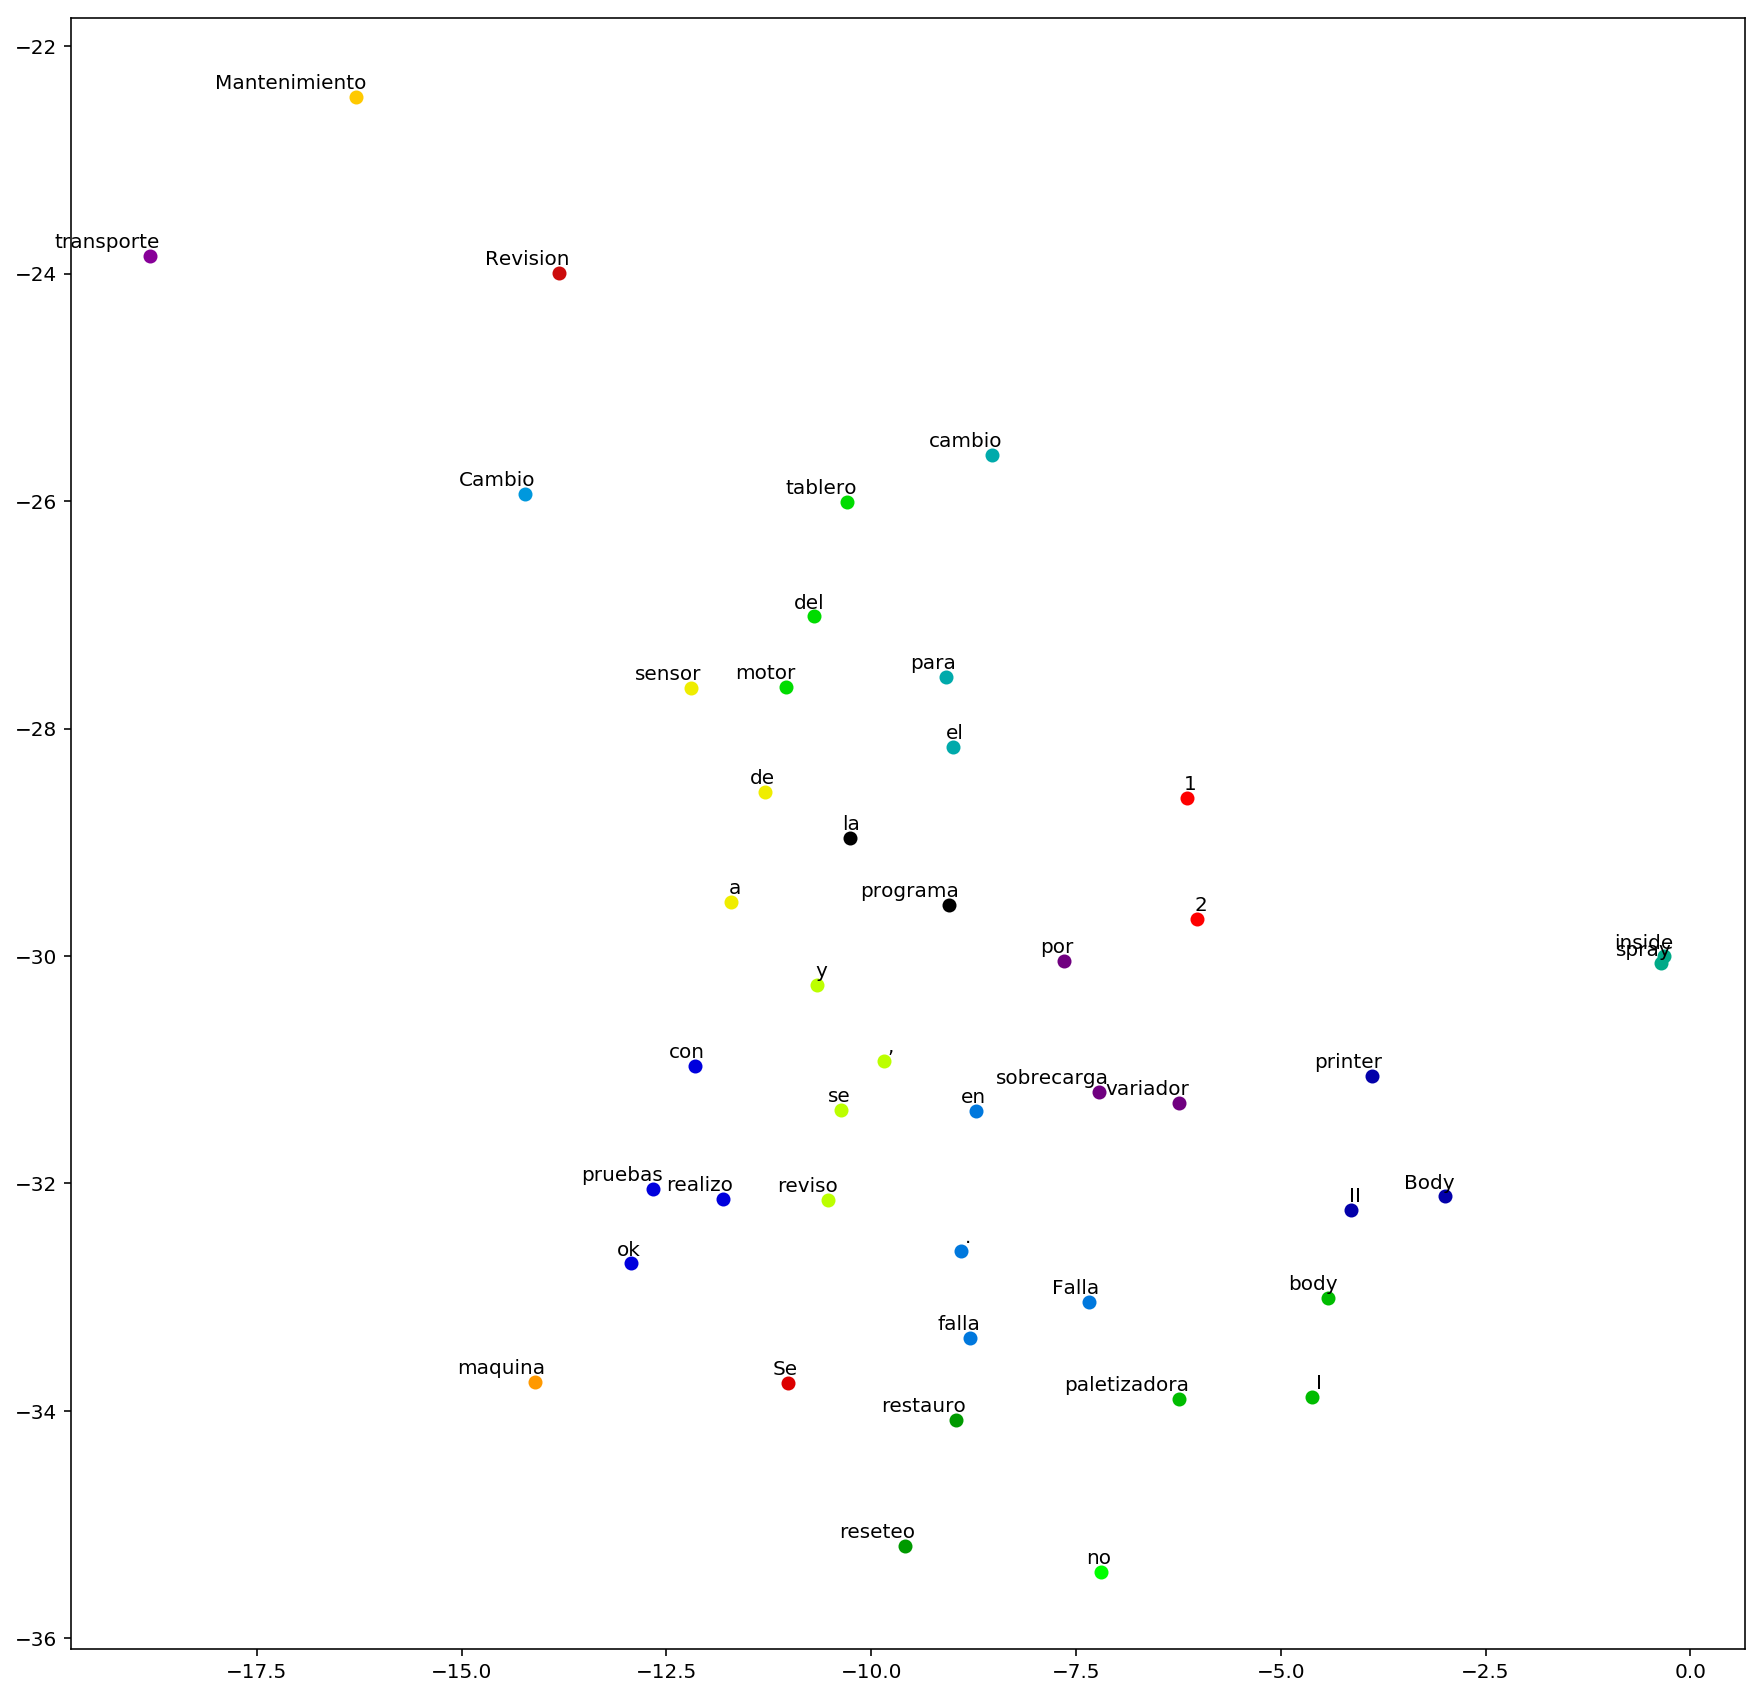

In [47]:
def plot(embeddings, labels):
  
  n_clusters = 20 # number of clusters
  # automatically build a discrete set of colors, each for cluster
  label_colors = [pylab.cm.nipy_spectral(float(i) /n_clusters) for i in range(n_clusters)]
  
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  
  # Define K-Means
  kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0).fit(embeddings)
  kmeans_labels = kmeans.labels_
  
  pylab.figure(figsize=(15,15))  # in inches
    
  # plot all the embeddings and their corresponding words
  for i, (label,klabel) in enumerate(zip(labels,kmeans_labels)):
    x, y = embeddings[i,:]
    pylab.scatter(x, y, c=label_colors[klabel])    
        
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom',fontsize=10)

  # use for saving the figure if needed
  #pylab.savefig('word_embeddings.png')
  pylab.show()

words = [reverse_dictionary[i] for i in selected_ids]
plot(two_d_embeddings, words)

## Tensorboard config and visualization

In [10]:
vocabulary_size

17322

In [11]:
final_embeddings = np.load("glov_embeddings.npy")

In [16]:
import os
import csv
from tensorflow.contrib.tensorboard.plugins import projector

# Create a directory to save our model
log_dir = 'models'
if not os.path.exists(log_dir):
    os.mkdir(log_dir)

tf.reset_default_graph()

# Create a Tensorflow variable initialized with the word embedings we just read in
embeddings = tf.get_variable(name='embeddings',shape=[vocabulary_size, embedding_size],
                             initializer=tf.constant_initializer(final_embeddings))

session = tf.InteractiveSession()

tf.global_variables_initializer().run()

# Define a saver, that will save the Tensorflow variables to a given location
saver = tf.train.Saver({'embeddings':embeddings})
# Save the file
saver.save(session, os.path.join(log_dir, "model.ckpt"), 0)

# Define metadata for word embeddings
with open(os.path.join(log_dir,'metadata.tsv'), 'w',encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['Word','Word ID'])
    for wi,w in enumerate(words):
      writer.writerow([w,wi])

/home/stanlee321/.virtualenvs/workenv/lib/python3.6/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [19]:
config = projector.ProjectorConfig()

# You can add multiple embeddings. Here we add only one.
embedding_config = config.embeddings.add()
embedding_config.tensor_name = embeddings.name
# Link this tensor to its metadata file (e.g. labels).
embedding_config.metadata_path = 'metadata.tsv'

# Use the same LOG_DIR where you stored your checkpoint.
summary_writer = tf.summary.FileWriter(log_dir)

# The next line writes a projector_config.pbtxt in the LOG_DIR. TensorBoard will
# read this file during startup.
projector.visualize_embeddings(summary_writer, config)

Now run in your terminal tensorboard --logdir=checkpoints
and go to your locahost  http://localhost:6006 

# Legacy aproach with Word2Vec/Skipgram algo

In [8]:
import re
def preprocess(text):
    #print(text)
    # Replace punctuation with tokens so we can use them in our model
    text = text.lower()
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    if text =='i':
        text = '<I>'
    elif text =='ii':
        text = '<II>'
    elif text =='iii':
        text = '<III>'
    else:
        pass
    # text = text.replace('\n', ' <NEW_LINE> ')
    text = text.replace(':', ' <COLON> ')
    words = text.split()[0]
    return words


In [9]:
words_trimmed = []
for i,token in enumerate(words):
    w = preprocess(token)
    if len(w) > 4:
        words_trimmed.append(w)
    else:
        pass

In [10]:
len(words_trimmed)

207014

check len of the plain_tokens 

In [11]:
words_trimmed

['falla',
 '<III>',
 '<COMMA>',
 'error',
 'varias',
 'oportunidades',
 '<COMMA>',
 'restablecio',
 'falla',
 'light',
 'tester',
 'expulsion',
 'latas',
 'pasar',
 'latas',
 'defecto',
 '<COMMA>',
 'coloco',
 'learner',
 'subio',
 'sencibilidad',
 '<COMMA>',
 'pruebas',
 'falla',
 'printer',
 'mensaje',
 'constantede',
 'seguridad',
 '<COMMA>',
 'restablecio',
 'falla',
 '<III>',
 'relay',
 'safety',
 'reinicio',
 'nuevamente',
 'restauro',
 'falla',
 'verificacion',
 'motor',
 'desnatador',
 'salio',
 'tanque',
 'superiror',
 '<COMMA>',
 'encontrandose',
 'corto',
 'circuito',
 'grupo',
 'bobinas',
 'inducido',
 '<COMMA>',
 'reembobinar',
 'realizo',
 'motor',
 'desnatador',
 'tanque',
 'subterraneo',
 'encontro',
 'colector',
 'contaminado',
 'desgaste',
 'carbon',
 'coolant',
 '<COMMA>',
 'portaq',
 'escobolillas',
 'recalentados',
 'deformados',
 '<COMMA>',
 'coloco',
 'portaescobillas',
 'dañado',
 '<COMMA>',
 'falta',
 'cambiar',
 'carbones',
 'pruebas',
 'instalacion',
 'cable'

unique words in a document

Check unique words in plain_tokens

In [12]:
words = words_trimmed
print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

Total words: 207014
Unique words: 11040


In [13]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

In [14]:
# Sub sampling
from collections import Counter
import random
import numpy as np

threshold = 1e-5
word_counts = Counter(int_words)
total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

In [15]:
#Making batches
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = set(words[start:idx] + words[idx+1:stop+1])
    
    return list(target_words)

In [16]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

In [17]:
#Building the graph
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
    labels = tf.placeholder(tf.int32, [None, None], name='labels')

In [18]:
n_vocab = len(int_to_vocab)
n_embedding = 200 # Number of embedding features 
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs)

In [19]:
# Negative sampling
#Number of negative labels to sample
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(n_vocab))
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, 
                                      labels, embed,
                                      n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

In [20]:
#Validation
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [21]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints

mkdir: cannot create directory ‘checkpoints’: File exists


# Train

In [ ]:
import time
epochs = 10000
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())
    
    #sess.run(tf.global_variables_initializer())
    #new_saver = tf.train.import_meta_graph('model.ckpt.meta')
    #new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 4/10000 Iteration: 100 Avg. Training loss: 5.2240 0.0014 sec/batch


In [27]:
# IF start again

#tf.reset_default_graph()

In [22]:
# CONTINUE TRAINING..
# Restore if is needed

import time
epochs = 30000 # Aprox 9 hours
batch_size = 1000
window_size = 10


with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
        save_path = saver.save(sess, "checkpoints/text_epoch_{}.ckpt".format(e))
    embed_mat = sess.run(normalized_embedding)


INFO:tensorflow:Restoring parameters from checkpoints/text8.ckpt
Epoch 4/30000 Iteration: 100 Avg. Training loss: 19.7426 0.0003 sec/batch
Epoch 7/30000 Iteration: 200 Avg. Training loss: 17.9140 0.0007 sec/batch
Epoch 10/30000 Iteration: 300 Avg. Training loss: 16.6080 0.0010 sec/batch
Epoch 13/30000 Iteration: 400 Avg. Training loss: 15.6523 0.0014 sec/batch
Epoch 16/30000 Iteration: 500 Avg. Training loss: 14.8948 0.0017 sec/batch
Epoch 19/30000 Iteration: 600 Avg. Training loss: 14.2118 0.0022 sec/batch
Epoch 22/30000 Iteration: 700 Avg. Training loss: 13.6565 0.0025 sec/batch
Epoch 25/30000 Iteration: 800 Avg. Training loss: 13.0777 0.0028 sec/batch
Epoch 28/30000 Iteration: 900 Avg. Training loss: 12.6318 0.0032 sec/batch
Epoch 31/30000 Iteration: 1000 Avg. Training loss: 12.1935 0.0036 sec/batch
Nearest to entrada: verifica, reset, alimentacion, <III>, backup, backups, posiciones, velocidad,
Nearest to seguridad: <COMMA>, cambia, falla, reviso, safety, entro, coolant, <RIGHT_PAR

Epoch 125/30000 Iteration: 4100 Avg. Training loss: 5.6760 0.0029 sec/batch
Epoch 128/30000 Iteration: 4200 Avg. Training loss: 5.5725 0.0033 sec/batch
Epoch 131/30000 Iteration: 4300 Avg. Training loss: 5.4536 0.0037 sec/batch
Epoch 134/30000 Iteration: 4400 Avg. Training loss: 5.3435 0.0039 sec/batch
Epoch 137/30000 Iteration: 4500 Avg. Training loss: 5.2666 0.0042 sec/batch
Epoch 140/30000 Iteration: 4600 Avg. Training loss: 5.1472 0.0047 sec/batch
Epoch 143/30000 Iteration: 4700 Avg. Training loss: 5.0481 0.0051 sec/batch
Epoch 146/30000 Iteration: 4800 Avg. Training loss: 4.9471 0.0056 sec/batch
Epoch 149/30000 Iteration: 4900 Avg. Training loss: 4.8634 0.0056 sec/batch
Epoch 152/30000 Iteration: 5000 Avg. Training loss: 4.7808 0.0061 sec/batch
Nearest to entrada: <PERIOD>, cableado, salida, <COMMA>, sensores, motor, paletizadora, verifico,
Nearest to seguridad: <COMMA>, nuevas, reseteo, <LEFT_PAREN>, ajuste, juntamente, cambio, alimentacion,
Nearest to tambien: motores, falla, co

Epoch 246/30000 Iteration: 8100 Avg. Training loss: 3.0199 0.0055 sec/batch
Epoch 249/30000 Iteration: 8200 Avg. Training loss: 2.9796 0.0057 sec/batch
Epoch 252/30000 Iteration: 8300 Avg. Training loss: 2.9459 0.0067 sec/batch
Epoch 255/30000 Iteration: 8400 Avg. Training loss: 2.9107 0.0063 sec/batch
Epoch 258/30000 Iteration: 8500 Avg. Training loss: 2.8828 0.0070 sec/batch
Epoch 261/30000 Iteration: 8600 Avg. Training loss: 2.8652 0.0073 sec/batch
Epoch 264/30000 Iteration: 8700 Avg. Training loss: 2.8288 0.0075 sec/batch
Epoch 267/30000 Iteration: 8800 Avg. Training loss: 2.7912 0.0079 sec/batch
Epoch 270/30000 Iteration: 8900 Avg. Training loss: 2.7650 0.0083 sec/batch
Epoch 273/30000 Iteration: 9000 Avg. Training loss: 2.7327 0.0086 sec/batch
Nearest to entrada: salida, ncuentran, latchdo, m15-16, reinstalo, reatblecio, licencia, setado,
Nearest to seguridad: nuevas, independizar, micro, menaje, bobina, prx4_1, estandarizacion, ssecando,
Nearest to tambien: humeda, sensibilidad,

Epoch 367/30000 Iteration: 12100 Avg. Training loss: 2.1841 0.0078 sec/batch
Epoch 370/30000 Iteration: 12200 Avg. Training loss: 2.1702 0.0083 sec/batch
Epoch 373/30000 Iteration: 12300 Avg. Training loss: 2.1376 0.0086 sec/batch
Epoch 376/30000 Iteration: 12400 Avg. Training loss: 2.1306 0.0088 sec/batch
Epoch 379/30000 Iteration: 12500 Avg. Training loss: 2.1164 0.0093 sec/batch
Epoch 382/30000 Iteration: 12600 Avg. Training loss: 2.0987 0.0095 sec/batch
Epoch 385/30000 Iteration: 12700 Avg. Training loss: 2.0937 0.0101 sec/batch
Epoch 388/30000 Iteration: 12800 Avg. Training loss: 2.0807 0.0102 sec/batch
Epoch 391/30000 Iteration: 12900 Avg. Training loss: 2.0867 0.0107 sec/batch
Epoch 394/30000 Iteration: 13000 Avg. Training loss: 2.0753 0.0112 sec/batch
Nearest to entrada: salida, ncuentran, m15-16, setado, latchdo, reatblecio, desvalance, amarado,
Nearest to seguridad: bobina, micro, sircuito, independizar, prx4_1, puesta, menaje, waxer,
Nearest to tambien: humeda, prismaticos, 

Epoch 488/30000 Iteration: 16100 Avg. Training loss: 1.8380 0.0105 sec/batch
Epoch 491/30000 Iteration: 16200 Avg. Training loss: 1.8275 0.0107 sec/batch
Epoch 494/30000 Iteration: 16300 Avg. Training loss: 1.8110 0.0111 sec/batch
Epoch 497/30000 Iteration: 16400 Avg. Training loss: 1.8085 0.0115 sec/batch
Epoch 500/30000 Iteration: 16500 Avg. Training loss: 1.8051 0.0119 sec/batch
Epoch 504/30000 Iteration: 16600 Avg. Training loss: 1.8069 0.0003 sec/batch
Epoch 507/30000 Iteration: 16700 Avg. Training loss: 1.7898 0.0008 sec/batch
Epoch 510/30000 Iteration: 16800 Avg. Training loss: 1.7916 0.0011 sec/batch
Epoch 513/30000 Iteration: 16900 Avg. Training loss: 1.7868 0.0016 sec/batch
Epoch 516/30000 Iteration: 17000 Avg. Training loss: 1.7731 0.0018 sec/batch
Nearest to entrada: salida, ncuentran, m15-16, licencia, setado, arranuqe, existir, mostrando,
Nearest to seguridad: bobina, puesta, prx4_1, rreiteradas, disponibles, waxer, menaje, independizar,
Nearest to tambien: prismaticos, h

Epoch 610/30000 Iteration: 20100 Avg. Training loss: 1.6489 0.0011 sec/batch
Epoch 613/30000 Iteration: 20200 Avg. Training loss: 1.6469 0.0014 sec/batch
Epoch 616/30000 Iteration: 20300 Avg. Training loss: 1.6517 0.0017 sec/batch
Epoch 619/30000 Iteration: 20400 Avg. Training loss: 1.6547 0.0023 sec/batch
Epoch 622/30000 Iteration: 20500 Avg. Training loss: 1.6418 0.0025 sec/batch
Epoch 625/30000 Iteration: 20600 Avg. Training loss: 1.6331 0.0031 sec/batch
Epoch 628/30000 Iteration: 20700 Avg. Training loss: 1.6311 0.0031 sec/batch
Epoch 631/30000 Iteration: 20800 Avg. Training loss: 1.6250 0.0036 sec/batch
Epoch 634/30000 Iteration: 20900 Avg. Training loss: 1.6260 0.0040 sec/batch
Epoch 637/30000 Iteration: 21000 Avg. Training loss: 1.6251 0.0043 sec/batch
Nearest to entrada: salida, ncuentran, arranuqe, m15-16, licencia, existir, setado, amarado,
Nearest to seguridad: bobina, rreiteradas, ssecando, puesta, menaje, waxer, disponibles, ellos,
Nearest to tambien: prismaticos, ispeccio

Epoch 731/30000 Iteration: 24100 Avg. Training loss: 1.5590 0.0036 sec/batch
Epoch 734/30000 Iteration: 24200 Avg. Training loss: 1.5636 0.0040 sec/batch
Epoch 737/30000 Iteration: 24300 Avg. Training loss: 1.5286 0.0043 sec/batch
Epoch 740/30000 Iteration: 24400 Avg. Training loss: 1.5372 0.0046 sec/batch
Epoch 743/30000 Iteration: 24500 Avg. Training loss: 1.5356 0.0050 sec/batch
Epoch 746/30000 Iteration: 24600 Avg. Training loss: 1.5319 0.0053 sec/batch
Epoch 749/30000 Iteration: 24700 Avg. Training loss: 1.5342 0.0058 sec/batch
Epoch 752/30000 Iteration: 24800 Avg. Training loss: 1.5292 0.0061 sec/batch
Epoch 755/30000 Iteration: 24900 Avg. Training loss: 1.5278 0.0066 sec/batch
Epoch 758/30000 Iteration: 25000 Avg. Training loss: 1.5283 0.0068 sec/batch
Nearest to entrada: salida, ncuentran, m15-16, arranuqe, alineación, existir, licencia, mostrando,
Nearest to seguridad: bobina, rreiteradas, menasje, puesta, menaje, ssecando, ellos, minster,
Nearest to tambien: prismaticos, body

Epoch 852/30000 Iteration: 28100 Avg. Training loss: 1.4790 0.0058 sec/batch
Epoch 855/30000 Iteration: 28200 Avg. Training loss: 1.4726 0.0065 sec/batch
Epoch 858/30000 Iteration: 28300 Avg. Training loss: 1.4744 0.0069 sec/batch
Epoch 861/30000 Iteration: 28400 Avg. Training loss: 1.4698 0.0072 sec/batch
Epoch 864/30000 Iteration: 28500 Avg. Training loss: 1.4762 0.0077 sec/batch
Epoch 867/30000 Iteration: 28600 Avg. Training loss: 1.4861 0.0079 sec/batch
Epoch 870/30000 Iteration: 28700 Avg. Training loss: 1.4602 0.0081 sec/batch
Epoch 873/30000 Iteration: 28800 Avg. Training loss: 1.4664 0.0086 sec/batch
Epoch 876/30000 Iteration: 28900 Avg. Training loss: 1.4719 0.0092 sec/batch
Epoch 879/30000 Iteration: 29000 Avg. Training loss: 1.4656 0.0095 sec/batch
Nearest to entrada: salida, m15-16, ncuentran, m11-12-13, trabajaba, alineación, latchdo, arranuqe,
Nearest to seguridad: menasje, bobina, rreiteradas, ssecando, menaje, minster, puesta, purgo,
Nearest to tambien: prismaticos, spa

Epoch 973/30000 Iteration: 32100 Avg. Training loss: 1.4176 0.0091 sec/batch
Epoch 976/30000 Iteration: 32200 Avg. Training loss: 1.4323 0.0088 sec/batch
Epoch 979/30000 Iteration: 32300 Avg. Training loss: 1.4269 0.0094 sec/batch
Epoch 982/30000 Iteration: 32400 Avg. Training loss: 1.4239 0.0101 sec/batch
Epoch 985/30000 Iteration: 32500 Avg. Training loss: 1.4206 0.0101 sec/batch
Epoch 988/30000 Iteration: 32600 Avg. Training loss: 1.4271 0.0107 sec/batch
Epoch 991/30000 Iteration: 32700 Avg. Training loss: 1.4365 0.0112 sec/batch
Epoch 994/30000 Iteration: 32800 Avg. Training loss: 1.4297 0.0112 sec/batch
Epoch 997/30000 Iteration: 32900 Avg. Training loss: 1.4171 0.0113 sec/batch
Epoch 1000/30000 Iteration: 33000 Avg. Training loss: 1.4214 0.0118 sec/batch
Nearest to entrada: salida, latchdo, ncuentran, trabajaba, m15-16, alineación, arranuqe, m11-12-13,
Nearest to seguridad: menasje, bobina, ssecando, rreiteradas, minster, menaje, chillerspor, compuertas,
Nearest to tambien: prism

Epoch 1094/30000 Iteration: 36100 Avg. Training loss: 1.3991 0.0115 sec/batch
Epoch 1097/30000 Iteration: 36200 Avg. Training loss: 1.3873 0.0117 sec/batch
Epoch 1100/30000 Iteration: 36300 Avg. Training loss: 1.4003 0.0119 sec/batch
Epoch 1104/30000 Iteration: 36400 Avg. Training loss: 1.3857 0.0003 sec/batch
Epoch 1107/30000 Iteration: 36500 Avg. Training loss: 1.3772 0.0008 sec/batch
Epoch 1110/30000 Iteration: 36600 Avg. Training loss: 1.4008 0.0011 sec/batch
Epoch 1113/30000 Iteration: 36700 Avg. Training loss: 1.3798 0.0014 sec/batch
Epoch 1116/30000 Iteration: 36800 Avg. Training loss: 1.3905 0.0018 sec/batch
Epoch 1119/30000 Iteration: 36900 Avg. Training loss: 1.3902 0.0021 sec/batch
Epoch 1122/30000 Iteration: 37000 Avg. Training loss: 1.3869 0.0025 sec/batch
Nearest to entrada: salida, ncuentran, trabajaba, prx8c, latchdo, alineación, m11-12-13, lumen,
Nearest to seguridad: menasje, minster, ssecando, bobina, menaje, reprensado, compuertas, purgo,
Nearest to tambien: prismat

Epoch 1216/30000 Iteration: 40100 Avg. Training loss: 1.3769 0.0018 sec/batch
Epoch 1219/30000 Iteration: 40200 Avg. Training loss: 1.3740 0.0021 sec/batch
Epoch 1222/30000 Iteration: 40300 Avg. Training loss: 1.3670 0.0024 sec/batch
Epoch 1225/30000 Iteration: 40400 Avg. Training loss: 1.3628 0.0029 sec/batch
Epoch 1228/30000 Iteration: 40500 Avg. Training loss: 1.3796 0.0034 sec/batch
Epoch 1231/30000 Iteration: 40600 Avg. Training loss: 1.3644 0.0036 sec/batch
Epoch 1234/30000 Iteration: 40700 Avg. Training loss: 1.3540 0.0040 sec/batch
Epoch 1237/30000 Iteration: 40800 Avg. Training loss: 1.3686 0.0044 sec/batch
Epoch 1240/30000 Iteration: 40900 Avg. Training loss: 1.3653 0.0051 sec/batch
Epoch 1243/30000 Iteration: 41000 Avg. Training loss: 1.3735 0.0050 sec/batch
Nearest to entrada: trabajaba, latchdo, prx8c, salida, ncuentran, m11-12-13, alineación, mostrando,
Nearest to seguridad: menasje, minster, ssecando, bobina, rreiteradas, menaje, ellos, reprensado,
Nearest to tambien: pr

Epoch 1337/30000 Iteration: 44100 Avg. Training loss: 1.3464 0.0045 sec/batch
Epoch 1340/30000 Iteration: 44200 Avg. Training loss: 1.3344 0.0047 sec/batch
Epoch 1343/30000 Iteration: 44300 Avg. Training loss: 1.3452 0.0051 sec/batch
Epoch 1346/30000 Iteration: 44400 Avg. Training loss: 1.3406 0.0053 sec/batch
Epoch 1349/30000 Iteration: 44500 Avg. Training loss: 1.3372 0.0058 sec/batch
Epoch 1352/30000 Iteration: 44600 Avg. Training loss: 1.3407 0.0061 sec/batch
Epoch 1355/30000 Iteration: 44700 Avg. Training loss: 1.3286 0.0066 sec/batch
Epoch 1358/30000 Iteration: 44800 Avg. Training loss: 1.3359 0.0069 sec/batch
Epoch 1361/30000 Iteration: 44900 Avg. Training loss: 1.3498 0.0069 sec/batch
Epoch 1364/30000 Iteration: 45000 Avg. Training loss: 1.3537 0.0076 sec/batch
Nearest to entrada: trabajaba, prx8c, reconoser, m11-12-13, latchdo, lumen, salida, alineación,
Nearest to seguridad: menasje, minster, ssecando, compuertas, punzones, ellos, bobina, contaminacion,
Nearest to tambien: pr

Epoch 1458/30000 Iteration: 48100 Avg. Training loss: 1.3368 0.0070 sec/batch
Epoch 1461/30000 Iteration: 48200 Avg. Training loss: 1.3252 0.0074 sec/batch
Epoch 1464/30000 Iteration: 48300 Avg. Training loss: 1.3473 0.0076 sec/batch
Epoch 1467/30000 Iteration: 48400 Avg. Training loss: 1.3208 0.0077 sec/batch
Epoch 1470/30000 Iteration: 48500 Avg. Training loss: 1.3454 0.0084 sec/batch
Epoch 1473/30000 Iteration: 48600 Avg. Training loss: 1.3382 0.0086 sec/batch
Epoch 1476/30000 Iteration: 48700 Avg. Training loss: 1.3212 0.0089 sec/batch
Epoch 1479/30000 Iteration: 48800 Avg. Training loss: 1.3202 0.0096 sec/batch
Epoch 1482/30000 Iteration: 48900 Avg. Training loss: 1.3227 0.0100 sec/batch
Epoch 1485/30000 Iteration: 49000 Avg. Training loss: 1.3306 0.0105 sec/batch
Nearest to entrada: trabajaba, latchdo, m11-12-13, prx8c, reconoser, ncuentran, alineación, lumen,
Nearest to seguridad: menasje, minster, punzones, bobina, menaje, reviziones, ssecando, rreiteradas,
Nearest to tambien: 

Epoch 1579/30000 Iteration: 52100 Avg. Training loss: 1.2958 0.0092 sec/batch
Epoch 1582/30000 Iteration: 52200 Avg. Training loss: 1.3050 0.0099 sec/batch
Epoch 1585/30000 Iteration: 52300 Avg. Training loss: 1.3315 0.0102 sec/batch
Epoch 1588/30000 Iteration: 52400 Avg. Training loss: 1.3089 0.0105 sec/batch
Epoch 1591/30000 Iteration: 52500 Avg. Training loss: 1.2993 0.0109 sec/batch
Epoch 1594/30000 Iteration: 52600 Avg. Training loss: 1.3172 0.0112 sec/batch
Epoch 1597/30000 Iteration: 52700 Avg. Training loss: 1.3176 0.0115 sec/batch
Epoch 1600/30000 Iteration: 52800 Avg. Training loss: 1.3103 0.0122 sec/batch
Epoch 1604/30000 Iteration: 52900 Avg. Training loss: 1.3104 0.0004 sec/batch
Epoch 1607/30000 Iteration: 53000 Avg. Training loss: 1.3052 0.0008 sec/batch
Nearest to entrada: prx8c, trabajaba, m11-12-13, reconoser, alineación, ncuentran, latchdo, mostrando,
Nearest to seguridad: menasje, minster, bobina, punzones, ssecando, reviziones, rreiteradas, compuertas,
Nearest to t

Epoch 1700/30000 Iteration: 56100 Avg. Training loss: 1.3005 0.0120 sec/batch
Epoch 1704/30000 Iteration: 56200 Avg. Training loss: 1.2980 0.0003 sec/batch
Epoch 1707/30000 Iteration: 56300 Avg. Training loss: 1.3081 0.0007 sec/batch
Epoch 1710/30000 Iteration: 56400 Avg. Training loss: 1.3120 0.0011 sec/batch
Epoch 1713/30000 Iteration: 56500 Avg. Training loss: 1.2933 0.0015 sec/batch
Epoch 1716/30000 Iteration: 56600 Avg. Training loss: 1.2983 0.0018 sec/batch
Epoch 1719/30000 Iteration: 56700 Avg. Training loss: 1.2863 0.0023 sec/batch
Epoch 1722/30000 Iteration: 56800 Avg. Training loss: 1.2859 0.0026 sec/batch
Epoch 1725/30000 Iteration: 56900 Avg. Training loss: 1.2980 0.0030 sec/batch
Epoch 1728/30000 Iteration: 57000 Avg. Training loss: 1.2877 0.0033 sec/batch
Nearest to entrada: trabajaba, prx8c, m11-12-13, latchdo, ncuentran, alineación, reconoser, cuelga,
Nearest to seguridad: menasje, minster, bobina, punzones, reprensado, ciron, ssecando, rreiteradas,
Nearest to tambien: 

Epoch 1822/30000 Iteration: 60100 Avg. Training loss: 1.2824 0.0026 sec/batch
Epoch 1825/30000 Iteration: 60200 Avg. Training loss: 1.2936 0.0029 sec/batch
Epoch 1828/30000 Iteration: 60300 Avg. Training loss: 1.2811 0.0033 sec/batch
Epoch 1831/30000 Iteration: 60400 Avg. Training loss: 1.2812 0.0036 sec/batch
Epoch 1834/30000 Iteration: 60500 Avg. Training loss: 1.2759 0.0040 sec/batch
Epoch 1837/30000 Iteration: 60600 Avg. Training loss: 1.2822 0.0043 sec/batch
Epoch 1840/30000 Iteration: 60700 Avg. Training loss: 1.3095 0.0046 sec/batch
Epoch 1843/30000 Iteration: 60800 Avg. Training loss: 1.2949 0.0049 sec/batch
Epoch 1846/30000 Iteration: 60900 Avg. Training loss: 1.2820 0.0054 sec/batch
Epoch 1849/30000 Iteration: 61000 Avg. Training loss: 1.2867 0.0057 sec/batch
Nearest to entrada: prx8c, trabajaba, latchdo, m11-12-13, lumen, cuelga, ncuentran, errones,
Nearest to seguridad: menasje, punzones, minster, rreiteradas, bobina, ssecando, ciron, manualmente,
Nearest to tambien: prisma

Epoch 1943/30000 Iteration: 64100 Avg. Training loss: 1.2767 0.0050 sec/batch
Epoch 1946/30000 Iteration: 64200 Avg. Training loss: 1.2758 0.0055 sec/batch
Epoch 1949/30000 Iteration: 64300 Avg. Training loss: 1.2833 0.0058 sec/batch
Epoch 1952/30000 Iteration: 64400 Avg. Training loss: 1.2749 0.0062 sec/batch
Epoch 1955/30000 Iteration: 64500 Avg. Training loss: 1.2797 0.0065 sec/batch
Epoch 1958/30000 Iteration: 64600 Avg. Training loss: 1.2608 0.0069 sec/batch
Epoch 1961/30000 Iteration: 64700 Avg. Training loss: 1.2728 0.0070 sec/batch
Epoch 1964/30000 Iteration: 64800 Avg. Training loss: 1.2728 0.0076 sec/batch
Epoch 1967/30000 Iteration: 64900 Avg. Training loss: 1.2920 0.0078 sec/batch
Epoch 1970/30000 Iteration: 65000 Avg. Training loss: 1.2673 0.0083 sec/batch
Nearest to entrada: trabajaba, prx8c, m11-12-13, latchdo, reconoser, milisegundos, ncuentran, lumen,
Nearest to seguridad: menasje, minster, punzones, bobina, anularon, ssecando, gastado, reviziones,
Nearest to tambien: 

Epoch 2064/30000 Iteration: 68100 Avg. Training loss: 1.2931 0.0078 sec/batch
Epoch 2067/30000 Iteration: 68200 Avg. Training loss: 1.2793 0.0077 sec/batch
Epoch 2070/30000 Iteration: 68300 Avg. Training loss: 1.2631 0.0082 sec/batch
Epoch 2073/30000 Iteration: 68400 Avg. Training loss: 1.2664 0.0087 sec/batch
Epoch 2076/30000 Iteration: 68500 Avg. Training loss: 1.2621 0.0089 sec/batch
Epoch 2079/30000 Iteration: 68600 Avg. Training loss: 1.2601 0.0093 sec/batch
Epoch 2082/30000 Iteration: 68700 Avg. Training loss: 1.2632 0.0095 sec/batch
Epoch 2085/30000 Iteration: 68800 Avg. Training loss: 1.2738 0.0100 sec/batch
Epoch 2088/30000 Iteration: 68900 Avg. Training loss: 1.2793 0.0101 sec/batch
Epoch 2091/30000 Iteration: 69000 Avg. Training loss: 1.2669 0.0106 sec/batch
Nearest to entrada: trabajaba, prx8c, m11-12-13, reatblecio, latchdo, milisegundos, ncuentran, mostrando,
Nearest to seguridad: menasje, minster, punzones, manualmente, ssecando, bobina, rreiteradas, ciron,
Nearest to ta

Epoch 2185/30000 Iteration: 72100 Avg. Training loss: 1.2599 0.0101 sec/batch
Epoch 2188/30000 Iteration: 72200 Avg. Training loss: 1.2609 0.0104 sec/batch
Epoch 2191/30000 Iteration: 72300 Avg. Training loss: 1.2702 0.0108 sec/batch
Epoch 2194/30000 Iteration: 72400 Avg. Training loss: 1.2606 0.0113 sec/batch
Epoch 2197/30000 Iteration: 72500 Avg. Training loss: 1.2616 0.0112 sec/batch
Epoch 2200/30000 Iteration: 72600 Avg. Training loss: 1.2717 0.0119 sec/batch
Epoch 2204/30000 Iteration: 72700 Avg. Training loss: 1.2710 0.0003 sec/batch
Epoch 2207/30000 Iteration: 72800 Avg. Training loss: 1.2531 0.0008 sec/batch
Epoch 2210/30000 Iteration: 72900 Avg. Training loss: 1.2472 0.0011 sec/batch
Epoch 2213/30000 Iteration: 73000 Avg. Training loss: 1.2721 0.0015 sec/batch
Nearest to entrada: trabajaba, prx8c, m11-12-13, errones, latchdo, milisegundos, lumen, reconoser,
Nearest to seguridad: menasje, minster, punzones, bobina, ciron, ssecando, contaminacion, rreiteradas,
Nearest to tambien

Epoch 2307/30000 Iteration: 76100 Avg. Training loss: 1.2562 0.0006 sec/batch
Epoch 2310/30000 Iteration: 76200 Avg. Training loss: 1.2519 0.0011 sec/batch
Epoch 2313/30000 Iteration: 76300 Avg. Training loss: 1.2554 0.0014 sec/batch
Epoch 2316/30000 Iteration: 76400 Avg. Training loss: 1.2678 0.0017 sec/batch
Epoch 2319/30000 Iteration: 76500 Avg. Training loss: 1.2405 0.0022 sec/batch
Epoch 2322/30000 Iteration: 76600 Avg. Training loss: 1.2496 0.0026 sec/batch
Epoch 2325/30000 Iteration: 76700 Avg. Training loss: 1.2512 0.0029 sec/batch
Epoch 2328/30000 Iteration: 76800 Avg. Training loss: 1.2496 0.0032 sec/batch
Epoch 2331/30000 Iteration: 76900 Avg. Training loss: 1.2571 0.0037 sec/batch
Epoch 2334/30000 Iteration: 77000 Avg. Training loss: 1.2590 0.0040 sec/batch
Nearest to entrada: trabajaba, prx8c, m11-12-13, latchdo, errones, mostrando, milisegundos, reconoser,
Nearest to seguridad: menasje, minster, punzones, contaminacion, bobina, rreiteradas, ciron, anularon,
Nearest to tam

Epoch 2428/30000 Iteration: 80100 Avg. Training loss: 1.2534 0.0032 sec/batch
Epoch 2431/30000 Iteration: 80200 Avg. Training loss: 1.2446 0.0036 sec/batch
Epoch 2434/30000 Iteration: 80300 Avg. Training loss: 1.2494 0.0040 sec/batch
Epoch 2437/30000 Iteration: 80400 Avg. Training loss: 1.2380 0.0044 sec/batch
Epoch 2440/30000 Iteration: 80500 Avg. Training loss: 1.2434 0.0049 sec/batch
Epoch 2443/30000 Iteration: 80600 Avg. Training loss: 1.2484 0.0048 sec/batch
Epoch 2446/30000 Iteration: 80700 Avg. Training loss: 1.2615 0.0052 sec/batch
Epoch 2449/30000 Iteration: 80800 Avg. Training loss: 1.2477 0.0058 sec/batch
Epoch 2452/30000 Iteration: 80900 Avg. Training loss: 1.2548 0.0060 sec/batch
Epoch 2455/30000 Iteration: 81000 Avg. Training loss: 1.2481 0.0063 sec/batch
Nearest to entrada: trabajaba, prx8c, m11-12-13, latchdo, errones, contacto, reconoser, milisegundos,
Nearest to seguridad: menasje, minster, bobina, punzones, reviziones, danffos, ingreso, rreiteradas,
Nearest to tambie

Epoch 2549/30000 Iteration: 84100 Avg. Training loss: 1.2427 0.0074 sec/batch
Epoch 2552/30000 Iteration: 84200 Avg. Training loss: 1.2209 0.0068 sec/batch
Epoch 2555/30000 Iteration: 84300 Avg. Training loss: 1.2462 0.0075 sec/batch
Epoch 2558/30000 Iteration: 84400 Avg. Training loss: 1.2441 0.0080 sec/batch
Epoch 2561/30000 Iteration: 84500 Avg. Training loss: 1.2632 0.0080 sec/batch
Epoch 2564/30000 Iteration: 84600 Avg. Training loss: 1.2445 0.0089 sec/batch
Epoch 2567/30000 Iteration: 84700 Avg. Training loss: 1.2479 0.0088 sec/batch
Epoch 2570/30000 Iteration: 84800 Avg. Training loss: 1.2399 0.0092 sec/batch
Epoch 2573/30000 Iteration: 84900 Avg. Training loss: 1.2328 0.0094 sec/batch
Epoch 2576/30000 Iteration: 85000 Avg. Training loss: 1.2334 0.0101 sec/batch
Nearest to entrada: trabajaba, prx8c, errones, m11-12-13, lumen, latchdo, instante, mostrando,
Nearest to seguridad: menasje, ingreso, punzones, minster, bobina, gastado, ciron, ssecando,
Nearest to tambien: rrotos, desp

Epoch 2670/30000 Iteration: 88100 Avg. Training loss: 1.2414 0.0090 sec/batch
Epoch 2673/30000 Iteration: 88200 Avg. Training loss: 1.2375 0.0102 sec/batch
Epoch 2676/30000 Iteration: 88300 Avg. Training loss: 1.2408 0.0107 sec/batch
Epoch 2679/30000 Iteration: 88400 Avg. Training loss: 1.2372 0.0107 sec/batch
Epoch 2682/30000 Iteration: 88500 Avg. Training loss: 1.2420 0.0104 sec/batch
Epoch 2685/30000 Iteration: 88600 Avg. Training loss: 1.2482 0.0120 sec/batch
Epoch 2688/30000 Iteration: 88700 Avg. Training loss: 1.2301 0.0106 sec/batch
Epoch 2691/30000 Iteration: 88800 Avg. Training loss: 1.2392 0.0119 sec/batch
Epoch 2694/30000 Iteration: 88900 Avg. Training loss: 1.2352 0.0121 sec/batch
Epoch 2697/30000 Iteration: 89000 Avg. Training loss: 1.2243 0.0121 sec/batch
Nearest to entrada: trabajaba, prx8c, m11-12-13, instante, errones, coneyor, contacto, lumen,
Nearest to seguridad: menasje, minster, punzones, bobina, ingreso, rreiteradas, ciron, electrovalvula,
Nearest to tambien: rro

Epoch 2791/30000 Iteration: 92100 Avg. Training loss: 1.2379 0.0132 sec/batch
Epoch 2794/30000 Iteration: 92200 Avg. Training loss: 1.2491 0.0131 sec/batch
Epoch 2797/30000 Iteration: 92300 Avg. Training loss: 1.2354 0.0144 sec/batch
Epoch 2800/30000 Iteration: 92400 Avg. Training loss: 1.2438 0.0145 sec/batch
Epoch 2804/30000 Iteration: 92500 Avg. Training loss: 1.2377 0.0005 sec/batch
Epoch 2807/30000 Iteration: 92600 Avg. Training loss: 1.2328 0.0009 sec/batch
Epoch 2810/30000 Iteration: 92700 Avg. Training loss: 1.2314 0.0012 sec/batch
Epoch 2813/30000 Iteration: 92800 Avg. Training loss: 1.2364 0.0018 sec/batch
Epoch 2816/30000 Iteration: 92900 Avg. Training loss: 1.2263 0.0019 sec/batch
Epoch 2819/30000 Iteration: 93000 Avg. Training loss: 1.2319 0.0025 sec/batch
Nearest to entrada: trabajaba, prx8c, instante, contacto, m11-12-13, errones, latchdo, milisegundos,
Nearest to seguridad: menasje, punzones, minster, bobina, anularon, rreiteradas, contaminacion, reprensado,
Nearest to 

Epoch 2913/30000 Iteration: 96100 Avg. Training loss: 1.2344 0.0018 sec/batch
Epoch 2916/30000 Iteration: 96200 Avg. Training loss: 1.2351 0.0027 sec/batch
Epoch 2919/30000 Iteration: 96300 Avg. Training loss: 1.2390 0.0032 sec/batch
Epoch 2922/30000 Iteration: 96400 Avg. Training loss: 1.2454 0.0032 sec/batch
Epoch 2925/30000 Iteration: 96500 Avg. Training loss: 1.2406 0.0044 sec/batch
Epoch 2928/30000 Iteration: 96600 Avg. Training loss: 1.2264 0.0040 sec/batch
Epoch 2931/30000 Iteration: 96700 Avg. Training loss: 1.2261 0.0048 sec/batch
Epoch 2934/30000 Iteration: 96800 Avg. Training loss: 1.2378 0.0045 sec/batch
Epoch 2937/30000 Iteration: 96900 Avg. Training loss: 1.2344 0.0052 sec/batch
Epoch 2940/30000 Iteration: 97000 Avg. Training loss: 1.2319 0.0054 sec/batch
Nearest to entrada: trabajaba, prx8c, errones, m11-12-13, instante, contacto, latchdo, milisegundos,
Nearest to seguridad: menasje, punzones, bobina, ingreso, minster, rreiteradas, gases, ciron,
Nearest to tambien: rroto

Epoch 3034/30000 Iteration: 100100 Avg. Training loss: 1.2329 0.0047 sec/batch
Epoch 3037/30000 Iteration: 100200 Avg. Training loss: 1.2223 0.0052 sec/batch
Epoch 3040/30000 Iteration: 100300 Avg. Training loss: 1.2331 0.0057 sec/batch
Epoch 3043/30000 Iteration: 100400 Avg. Training loss: 1.2358 0.0060 sec/batch
Epoch 3046/30000 Iteration: 100500 Avg. Training loss: 1.2389 0.0062 sec/batch
Epoch 3049/30000 Iteration: 100600 Avg. Training loss: 1.2210 0.0063 sec/batch
Epoch 3052/30000 Iteration: 100700 Avg. Training loss: 1.2428 0.0067 sec/batch
Epoch 3055/30000 Iteration: 100800 Avg. Training loss: 1.2179 0.0071 sec/batch
Epoch 3058/30000 Iteration: 100900 Avg. Training loss: 1.2234 0.0078 sec/batch
Epoch 3061/30000 Iteration: 101000 Avg. Training loss: 1.2301 0.0083 sec/batch
Nearest to entrada: trabajaba, contacto, prx8c, instante, errones, m11-12-13, latchdo, milisegundos,
Nearest to seguridad: menasje, punzones, minster, ciron, bobina, rreiteradas, gastado, ingreso,
Nearest to ta

Epoch 3155/30000 Iteration: 104100 Avg. Training loss: 1.2240 0.0072 sec/batch
Epoch 3158/30000 Iteration: 104200 Avg. Training loss: 1.2246 0.0078 sec/batch
Epoch 3161/30000 Iteration: 104300 Avg. Training loss: 1.2269 0.0081 sec/batch
Epoch 3164/30000 Iteration: 104400 Avg. Training loss: 1.2421 0.0090 sec/batch
Epoch 3167/30000 Iteration: 104500 Avg. Training loss: 1.2283 0.0102 sec/batch
Epoch 3170/30000 Iteration: 104600 Avg. Training loss: 1.2258 0.0088 sec/batch
Epoch 3173/30000 Iteration: 104700 Avg. Training loss: 1.2323 0.0096 sec/batch
Epoch 3176/30000 Iteration: 104800 Avg. Training loss: 1.2318 0.0098 sec/batch
Epoch 3179/30000 Iteration: 104900 Avg. Training loss: 1.2104 0.0100 sec/batch
Epoch 3182/30000 Iteration: 105000 Avg. Training loss: 1.2266 0.0112 sec/batch
Nearest to entrada: trabajaba, prx8c, contacto, errones, instante, coneyor, latchdo, m11-12-13,
Nearest to seguridad: menasje, punzones, ciron, gases, rreiteradas, minster, gastado, reprensado,
Nearest to tambi

Epoch 3276/30000 Iteration: 108100 Avg. Training loss: 1.2365 0.0109 sec/batch
Epoch 3279/30000 Iteration: 108200 Avg. Training loss: 1.2103 0.0116 sec/batch
Epoch 3282/30000 Iteration: 108300 Avg. Training loss: 1.2093 0.0105 sec/batch
Epoch 3285/30000 Iteration: 108400 Avg. Training loss: 1.2320 0.0136 sec/batch
Epoch 3288/30000 Iteration: 108500 Avg. Training loss: 1.2211 0.0107 sec/batch
Epoch 3291/30000 Iteration: 108600 Avg. Training loss: 1.2433 0.0142 sec/batch
Epoch 3294/30000 Iteration: 108700 Avg. Training loss: 1.2247 0.0139 sec/batch
Epoch 3297/30000 Iteration: 108800 Avg. Training loss: 1.2361 0.0138 sec/batch
Epoch 3300/30000 Iteration: 108900 Avg. Training loss: 1.2301 0.0149 sec/batch
Epoch 3304/30000 Iteration: 109000 Avg. Training loss: 1.2297 0.0005 sec/batch
Nearest to entrada: trabajaba, contacto, prx8c, errones, instante, milisegundos, coneyor, latchdo,
Nearest to seguridad: menasje, punzones, minster, ciron, anularon, bobina, reprensado, ingreso,
Nearest to tamb

Epoch 3397/30000 Iteration: 112100 Avg. Training loss: 1.2197 0.0149 sec/batch
Epoch 3400/30000 Iteration: 112200 Avg. Training loss: 1.2154 0.0138 sec/batch
Epoch 3404/30000 Iteration: 112300 Avg. Training loss: 1.2353 0.0005 sec/batch
Epoch 3407/30000 Iteration: 112400 Avg. Training loss: 1.2185 0.0008 sec/batch
Epoch 3410/30000 Iteration: 112500 Avg. Training loss: 1.2198 0.0013 sec/batch
Epoch 3413/30000 Iteration: 112600 Avg. Training loss: 1.2096 0.0021 sec/batch
Epoch 3416/30000 Iteration: 112700 Avg. Training loss: 1.2235 0.0023 sec/batch
Epoch 3419/30000 Iteration: 112800 Avg. Training loss: 1.2363 0.0027 sec/batch
Epoch 3422/30000 Iteration: 112900 Avg. Training loss: 1.2219 0.0031 sec/batch
Epoch 3425/30000 Iteration: 113000 Avg. Training loss: 1.2098 0.0035 sec/batch
Nearest to entrada: trabajaba, prx8c, errones, contacto, instante, latchdo, basura, reatableciio,
Nearest to seguridad: menasje, punzones, bobina, minster, reprensado, ciron, rreiteradas, cortinas,
Nearest to t

Epoch 3519/30000 Iteration: 116100 Avg. Training loss: 1.2251 0.0024 sec/batch
Epoch 3522/30000 Iteration: 116200 Avg. Training loss: 1.2307 0.0026 sec/batch
Epoch 3525/30000 Iteration: 116300 Avg. Training loss: 1.2134 0.0029 sec/batch
Epoch 3528/30000 Iteration: 116400 Avg. Training loss: 1.2130 0.0032 sec/batch
Epoch 3531/30000 Iteration: 116500 Avg. Training loss: 1.2202 0.0035 sec/batch
Epoch 3534/30000 Iteration: 116600 Avg. Training loss: 1.2063 0.0040 sec/batch
Epoch 3537/30000 Iteration: 116700 Avg. Training loss: 1.2163 0.0043 sec/batch
Epoch 3540/30000 Iteration: 116800 Avg. Training loss: 1.1961 0.0047 sec/batch
Epoch 3543/30000 Iteration: 116900 Avg. Training loss: 1.2302 0.0054 sec/batch
Epoch 3546/30000 Iteration: 117000 Avg. Training loss: 1.2247 0.0055 sec/batch
Nearest to entrada: trabajaba, contacto, prx8c, errones, instante, cambia, coneyor, milisegundos,
Nearest to seguridad: menasje, punzones, minster, bobina, gases, ciron, reprensado, atascamiento,
Nearest to tam

Epoch 3640/30000 Iteration: 120100 Avg. Training loss: 1.2272 0.0046 sec/batch
Epoch 3643/30000 Iteration: 120200 Avg. Training loss: 1.2156 0.0052 sec/batch
Epoch 3646/30000 Iteration: 120300 Avg. Training loss: 1.2194 0.0063 sec/batch
Epoch 3649/30000 Iteration: 120400 Avg. Training loss: 1.2102 0.0072 sec/batch
Epoch 3652/30000 Iteration: 120500 Avg. Training loss: 1.2194 0.0060 sec/batch
Epoch 3655/30000 Iteration: 120600 Avg. Training loss: 1.2056 0.0064 sec/batch
Epoch 3658/30000 Iteration: 120700 Avg. Training loss: 1.2157 0.0069 sec/batch
Epoch 3661/30000 Iteration: 120800 Avg. Training loss: 1.2297 0.0073 sec/batch
Epoch 3664/30000 Iteration: 120900 Avg. Training loss: 1.2326 0.0076 sec/batch
Epoch 3667/30000 Iteration: 121000 Avg. Training loss: 1.2198 0.0079 sec/batch
Nearest to entrada: trabajaba, contacto, prx8c, errones, instante, coneyor, latchdo, milisegundos,
Nearest to seguridad: menasje, punzones, electrovalvula, ciron, ingreso, gases, cortinas, minster,
Nearest to t

Epoch 3761/30000 Iteration: 124100 Avg. Training loss: 1.2255 0.0071 sec/batch
Epoch 3764/30000 Iteration: 124200 Avg. Training loss: 1.2113 0.0078 sec/batch
Epoch 3767/30000 Iteration: 124300 Avg. Training loss: 1.2304 0.0085 sec/batch
Epoch 3770/30000 Iteration: 124400 Avg. Training loss: 1.2273 0.0083 sec/batch
Epoch 3773/30000 Iteration: 124500 Avg. Training loss: 1.2021 0.0100 sec/batch
Epoch 3776/30000 Iteration: 124600 Avg. Training loss: 1.2114 0.0099 sec/batch
Epoch 3779/30000 Iteration: 124700 Avg. Training loss: 1.2170 0.0108 sec/batch
Epoch 3782/30000 Iteration: 124800 Avg. Training loss: 1.2136 0.0117 sec/batch
Epoch 3785/30000 Iteration: 124900 Avg. Training loss: 1.2116 0.0118 sec/batch
Epoch 3788/30000 Iteration: 125000 Avg. Training loss: 1.2102 0.0123 sec/batch
Nearest to entrada: trabajaba, contacto, prx8c, instante, errones, coneyor, basura, cambia,
Nearest to seguridad: menasje, punzones, bobina, ingreso, minster, llegando, ciron, electrovalvula,
Nearest to tambien

Epoch 3882/30000 Iteration: 128100 Avg. Training loss: 1.1987 0.0095 sec/batch
Epoch 3885/30000 Iteration: 128200 Avg. Training loss: 1.2194 0.0098 sec/batch
Epoch 3888/30000 Iteration: 128300 Avg. Training loss: 1.1998 0.0102 sec/batch
Epoch 3891/30000 Iteration: 128400 Avg. Training loss: 1.1930 0.0106 sec/batch
Epoch 3894/30000 Iteration: 128500 Avg. Training loss: 1.2149 0.0109 sec/batch
Epoch 3897/30000 Iteration: 128600 Avg. Training loss: 1.2312 0.0114 sec/batch
Epoch 3900/30000 Iteration: 128700 Avg. Training loss: 1.2211 0.0117 sec/batch
Epoch 3904/30000 Iteration: 128800 Avg. Training loss: 1.2223 0.0003 sec/batch
Epoch 3907/30000 Iteration: 128900 Avg. Training loss: 1.2183 0.0006 sec/batch
Epoch 3910/30000 Iteration: 129000 Avg. Training loss: 1.2094 0.0011 sec/batch
Nearest to entrada: trabajaba, contacto, instante, errones, prx8c, basura, cambia, coneyor,
Nearest to seguridad: menasje, electrovalvula, ingreso, bobina, punzones, ciron, gases, reprensado,
Nearest to tambien

Epoch 4004/30000 Iteration: 132100 Avg. Training loss: 1.2154 0.0003 sec/batch
Epoch 4007/30000 Iteration: 132200 Avg. Training loss: 1.2342 0.0007 sec/batch
Epoch 4010/30000 Iteration: 132300 Avg. Training loss: 1.2161 0.0014 sec/batch
Epoch 4013/30000 Iteration: 132400 Avg. Training loss: 1.2011 0.0021 sec/batch
Epoch 4016/30000 Iteration: 132500 Avg. Training loss: 1.2084 0.0018 sec/batch
Epoch 4019/30000 Iteration: 132600 Avg. Training loss: 1.2192 0.0023 sec/batch
Epoch 4022/30000 Iteration: 132700 Avg. Training loss: 1.2059 0.0028 sec/batch
Epoch 4025/30000 Iteration: 132800 Avg. Training loss: 1.2108 0.0027 sec/batch
Epoch 4028/30000 Iteration: 132900 Avg. Training loss: 1.2123 0.0031 sec/batch
Epoch 4031/30000 Iteration: 133000 Avg. Training loss: 1.2042 0.0035 sec/batch
Nearest to entrada: trabajaba, contacto, instante, errones, prx8c, coneyor, corriente, latchdo,
Nearest to seguridad: menasje, punzones, ciron, bobina, llegando, ingreso, cortinas, reprensado,
Nearest to tambie

Epoch 4125/30000 Iteration: 136100 Avg. Training loss: 1.2062 0.0034 sec/batch
Epoch 4128/30000 Iteration: 136200 Avg. Training loss: 1.2084 0.0036 sec/batch
Epoch 4131/30000 Iteration: 136300 Avg. Training loss: 1.2064 0.0043 sec/batch
Epoch 4134/30000 Iteration: 136400 Avg. Training loss: 1.2111 0.0044 sec/batch
Epoch 4137/30000 Iteration: 136500 Avg. Training loss: 1.2071 0.0049 sec/batch
Epoch 4140/30000 Iteration: 136600 Avg. Training loss: 1.2061 0.0051 sec/batch
Epoch 4143/30000 Iteration: 136700 Avg. Training loss: 1.2128 0.0058 sec/batch
Epoch 4146/30000 Iteration: 136800 Avg. Training loss: 1.2261 0.0065 sec/batch
Epoch 4149/30000 Iteration: 136900 Avg. Training loss: 1.2152 0.0062 sec/batch
Epoch 4152/30000 Iteration: 137000 Avg. Training loss: 1.2147 0.0066 sec/batch
Nearest to entrada: trabajaba, contacto, errones, instante, prx8c, corriente, cambia, basura,
Nearest to seguridad: menasje, llegando, punzones, ciron, ingreso, bobina, gases, minster,
Nearest to tambien: rroto

Epoch 4246/30000 Iteration: 140100 Avg. Training loss: 1.2074 0.0062 sec/batch
Epoch 4249/30000 Iteration: 140200 Avg. Training loss: 1.1888 0.0063 sec/batch
Epoch 4252/30000 Iteration: 140300 Avg. Training loss: 1.2184 0.0071 sec/batch
Epoch 4255/30000 Iteration: 140400 Avg. Training loss: 1.1918 0.0079 sec/batch
Epoch 4258/30000 Iteration: 140500 Avg. Training loss: 1.2132 0.0082 sec/batch
Epoch 4261/30000 Iteration: 140600 Avg. Training loss: 1.2128 0.0076 sec/batch
Epoch 4264/30000 Iteration: 140700 Avg. Training loss: 1.2101 0.0086 sec/batch
Epoch 4267/30000 Iteration: 140800 Avg. Training loss: 1.2270 0.0098 sec/batch
Epoch 4270/30000 Iteration: 140900 Avg. Training loss: 1.2066 0.0086 sec/batch
Epoch 4273/30000 Iteration: 141000 Avg. Training loss: 1.2063 0.0137 sec/batch
Nearest to entrada: trabajaba, instante, contacto, errones, prx8c, corriente, cambia, basura,
Nearest to seguridad: menasje, bobina, ingreso, atascamiento, punzones, anularon, llegando, ciron,
Nearest to tambie

Epoch 4367/30000 Iteration: 144100 Avg. Training loss: 1.2090 0.0078 sec/batch
Epoch 4370/30000 Iteration: 144200 Avg. Training loss: 1.2119 0.0082 sec/batch
Epoch 4373/30000 Iteration: 144300 Avg. Training loss: 1.2154 0.0085 sec/batch
Epoch 4376/30000 Iteration: 144400 Avg. Training loss: 1.2043 0.0090 sec/batch
Epoch 4379/30000 Iteration: 144500 Avg. Training loss: 1.2058 0.0092 sec/batch
Epoch 4382/30000 Iteration: 144600 Avg. Training loss: 1.2066 0.0095 sec/batch
Epoch 4385/30000 Iteration: 144700 Avg. Training loss: 1.2089 0.0099 sec/batch
Epoch 4388/30000 Iteration: 144800 Avg. Training loss: 1.2195 0.0104 sec/batch
Epoch 4391/30000 Iteration: 144900 Avg. Training loss: 1.1996 0.0108 sec/batch
Epoch 4394/30000 Iteration: 145000 Avg. Training loss: 1.2157 0.0110 sec/batch
Nearest to entrada: trabajaba, contacto, instante, errones, prx8c, corriente, coneyor, cambia,
Nearest to seguridad: menasje, ingreso, bobina, ciron, rreiteradas, cortinas, llegando, minster,
Nearest to tambien

Epoch 4488/30000 Iteration: 148100 Avg. Training loss: 1.2157 0.0104 sec/batch
Epoch 4491/30000 Iteration: 148200 Avg. Training loss: 1.1970 0.0107 sec/batch
Epoch 4494/30000 Iteration: 148300 Avg. Training loss: 1.2193 0.0110 sec/batch
Epoch 4497/30000 Iteration: 148400 Avg. Training loss: 1.1930 0.0112 sec/batch
Epoch 4500/30000 Iteration: 148500 Avg. Training loss: 1.2206 0.0117 sec/batch
Epoch 4504/30000 Iteration: 148600 Avg. Training loss: 1.2137 0.0003 sec/batch
Epoch 4507/30000 Iteration: 148700 Avg. Training loss: 1.2082 0.0007 sec/batch
Epoch 4510/30000 Iteration: 148800 Avg. Training loss: 1.2137 0.0010 sec/batch
Epoch 4513/30000 Iteration: 148900 Avg. Training loss: 1.2257 0.0014 sec/batch
Epoch 4516/30000 Iteration: 149000 Avg. Training loss: 1.2204 0.0018 sec/batch
Nearest to entrada: trabajaba, instante, contacto, errones, prx8c, cambia, corriente, coneyor,
Nearest to seguridad: menasje, ingreso, acople, gases, bobina, llegando, atascamiento, cortinas,
Nearest to tambien

Epoch 4610/30000 Iteration: 152100 Avg. Training loss: 1.2026 0.0010 sec/batch
Epoch 4613/30000 Iteration: 152200 Avg. Training loss: 1.1873 0.0014 sec/batch
Epoch 4616/30000 Iteration: 152300 Avg. Training loss: 1.2182 0.0017 sec/batch
Epoch 4619/30000 Iteration: 152400 Avg. Training loss: 1.2070 0.0021 sec/batch
Epoch 4622/30000 Iteration: 152500 Avg. Training loss: 1.2108 0.0024 sec/batch
Epoch 4625/30000 Iteration: 152600 Avg. Training loss: 1.2083 0.0028 sec/batch
Epoch 4628/30000 Iteration: 152700 Avg. Training loss: 1.1951 0.0031 sec/batch
Epoch 4631/30000 Iteration: 152800 Avg. Training loss: 1.2069 0.0035 sec/batch
Epoch 4634/30000 Iteration: 152900 Avg. Training loss: 1.1898 0.0038 sec/batch
Epoch 4637/30000 Iteration: 153000 Avg. Training loss: 1.1961 0.0043 sec/batch
Nearest to entrada: contacto, trabajaba, errones, instante, cambia, corriente, prx8c, coneyor,
Nearest to seguridad: menasje, bobina, ingreso, llegando, sensibilidad, ciron, devolvio, acople,
Nearest to tambien

Epoch 4731/30000 Iteration: 156100 Avg. Training loss: 1.2037 0.0036 sec/batch
Epoch 4734/30000 Iteration: 156200 Avg. Training loss: 1.2224 0.0045 sec/batch
Epoch 4737/30000 Iteration: 156300 Avg. Training loss: 1.2020 0.0043 sec/batch
Epoch 4740/30000 Iteration: 156400 Avg. Training loss: 1.2042 0.0045 sec/batch
Epoch 4743/30000 Iteration: 156500 Avg. Training loss: 1.2066 0.0048 sec/batch
Epoch 4746/30000 Iteration: 156600 Avg. Training loss: 1.2075 0.0054 sec/batch
Epoch 4749/30000 Iteration: 156700 Avg. Training loss: 1.2043 0.0059 sec/batch
Epoch 4752/30000 Iteration: 156800 Avg. Training loss: 1.2141 0.0062 sec/batch
Epoch 4755/30000 Iteration: 156900 Avg. Training loss: 1.2025 0.0067 sec/batch
Epoch 4758/30000 Iteration: 157000 Avg. Training loss: 1.2173 0.0072 sec/batch
Nearest to entrada: instante, trabajaba, contacto, errones, prx8c, corriente, cambia, coneyor,
Nearest to seguridad: menasje, ingreso, repone, atascamiento, devolvio, llegando, acople, cortinas,
Nearest to tamb

Epoch 4852/30000 Iteration: 160100 Avg. Training loss: 1.2008 0.0071 sec/batch
Epoch 4855/30000 Iteration: 160200 Avg. Training loss: 1.2143 0.0072 sec/batch
Epoch 4858/30000 Iteration: 160300 Avg. Training loss: 1.2142 0.0081 sec/batch
Epoch 4861/30000 Iteration: 160400 Avg. Training loss: 1.2038 0.0080 sec/batch
Epoch 4864/30000 Iteration: 160500 Avg. Training loss: 1.2004 0.0075 sec/batch
Epoch 4867/30000 Iteration: 160600 Avg. Training loss: 1.1915 0.0078 sec/batch
Epoch 4870/30000 Iteration: 160700 Avg. Training loss: 1.2011 0.0091 sec/batch
Epoch 4873/30000 Iteration: 160800 Avg. Training loss: 1.2074 0.0107 sec/batch
Epoch 4876/30000 Iteration: 160900 Avg. Training loss: 1.1919 0.0099 sec/batch
Epoch 4879/30000 Iteration: 161000 Avg. Training loss: 1.2052 0.0113 sec/batch
Nearest to entrada: contacto, errones, instante, trabajaba, corriente, prx8c, cambia, basura,
Nearest to seguridad: menasje, atascamiento, ingreso, llegando, repone, rreiteradas, bobina, ciron,
Nearest to tambi

Epoch 4973/30000 Iteration: 164100 Avg. Training loss: 1.2032 0.0083 sec/batch
Epoch 4976/30000 Iteration: 164200 Avg. Training loss: 1.2012 0.0087 sec/batch
Epoch 4979/30000 Iteration: 164300 Avg. Training loss: 1.1932 0.0094 sec/batch
Epoch 4982/30000 Iteration: 164400 Avg. Training loss: 1.1940 0.0092 sec/batch
Epoch 4985/30000 Iteration: 164500 Avg. Training loss: 1.2012 0.0097 sec/batch
Epoch 4988/30000 Iteration: 164600 Avg. Training loss: 1.1914 0.0110 sec/batch
Epoch 4991/30000 Iteration: 164700 Avg. Training loss: 1.2133 0.0113 sec/batch
Epoch 4994/30000 Iteration: 164800 Avg. Training loss: 1.2090 0.0111 sec/batch
Epoch 4997/30000 Iteration: 164900 Avg. Training loss: 1.1997 0.0124 sec/batch
Epoch 5000/30000 Iteration: 165000 Avg. Training loss: 1.2129 0.0133 sec/batch
Nearest to entrada: contacto, errones, instante, trabajaba, cambia, corriente, prx8c, reatableciio,
Nearest to seguridad: menasje, atascamiento, anularon, acople, llegando, bobina, repone, ingreso,
Nearest to t

Epoch 5094/30000 Iteration: 168100 Avg. Training loss: 1.2134 0.0126 sec/batch
Epoch 5097/30000 Iteration: 168200 Avg. Training loss: 1.1939 0.0120 sec/batch
Epoch 5100/30000 Iteration: 168300 Avg. Training loss: 1.1994 0.0120 sec/batch
Epoch 5104/30000 Iteration: 168400 Avg. Training loss: 1.2060 0.0003 sec/batch
Epoch 5107/30000 Iteration: 168500 Avg. Training loss: 1.1918 0.0006 sec/batch
Epoch 5110/30000 Iteration: 168600 Avg. Training loss: 1.2124 0.0011 sec/batch
Epoch 5113/30000 Iteration: 168700 Avg. Training loss: 1.2132 0.0014 sec/batch
Epoch 5116/30000 Iteration: 168800 Avg. Training loss: 1.1949 0.0018 sec/batch
Epoch 5119/30000 Iteration: 168900 Avg. Training loss: 1.2017 0.0021 sec/batch
Epoch 5122/30000 Iteration: 169000 Avg. Training loss: 1.1864 0.0025 sec/batch
Nearest to entrada: errones, contacto, instante, trabajaba, cambia, corriente, prx8c, reatableciio,
Nearest to seguridad: menasje, llegando, ingreso, atascamiento, bobina, lumanaria, acople, punzones,
Nearest t

Epoch 5216/30000 Iteration: 172100 Avg. Training loss: 1.1992 0.0022 sec/batch
Epoch 5219/30000 Iteration: 172200 Avg. Training loss: 1.2024 0.0022 sec/batch
Epoch 5222/30000 Iteration: 172300 Avg. Training loss: 1.2044 0.0025 sec/batch
Epoch 5225/30000 Iteration: 172400 Avg. Training loss: 1.2125 0.0028 sec/batch
Epoch 5228/30000 Iteration: 172500 Avg. Training loss: 1.2007 0.0031 sec/batch
Epoch 5231/30000 Iteration: 172600 Avg. Training loss: 1.2078 0.0036 sec/batch
Epoch 5234/30000 Iteration: 172700 Avg. Training loss: 1.1850 0.0038 sec/batch
Epoch 5237/30000 Iteration: 172800 Avg. Training loss: 1.2030 0.0043 sec/batch
Epoch 5240/30000 Iteration: 172900 Avg. Training loss: 1.1909 0.0046 sec/batch
Epoch 5243/30000 Iteration: 173000 Avg. Training loss: 1.2006 0.0051 sec/batch
Nearest to entrada: contacto, trabajaba, instante, errones, cambia, corriente, prx8c, coneyor,
Nearest to seguridad: menasje, atascamiento, ingreso, llegando, anularon, sensibilidad, cortinas, devolvio,
Nearest

Epoch 5337/30000 Iteration: 176100 Avg. Training loss: 1.1888 0.0048 sec/batch
Epoch 5340/30000 Iteration: 176200 Avg. Training loss: 1.1942 0.0050 sec/batch
Epoch 5343/30000 Iteration: 176300 Avg. Training loss: 1.2058 0.0057 sec/batch
Epoch 5346/30000 Iteration: 176400 Avg. Training loss: 1.2021 0.0060 sec/batch
Epoch 5349/30000 Iteration: 176500 Avg. Training loss: 1.1965 0.0060 sec/batch
Epoch 5352/30000 Iteration: 176600 Avg. Training loss: 1.2040 0.0069 sec/batch
Epoch 5355/30000 Iteration: 176700 Avg. Training loss: 1.2001 0.0085 sec/batch
Epoch 5358/30000 Iteration: 176800 Avg. Training loss: 1.2023 0.0086 sec/batch
Epoch 5361/30000 Iteration: 176900 Avg. Training loss: 1.2086 0.0087 sec/batch
Epoch 5364/30000 Iteration: 177000 Avg. Training loss: 1.2184 0.0085 sec/batch
Nearest to entrada: instante, errones, cambia, contacto, corriente, trabajaba, prx8c, reatableciio,
Nearest to seguridad: menasje, llegando, atascamiento, ingreso, devolvio, realizo, repone, excesivo,
Nearest t

Epoch 5458/30000 Iteration: 180100 Avg. Training loss: 1.2004 0.0074 sec/batch
Epoch 5461/30000 Iteration: 180200 Avg. Training loss: 1.2129 0.0087 sec/batch
Epoch 5464/30000 Iteration: 180300 Avg. Training loss: 1.2165 0.0082 sec/batch
Epoch 5467/30000 Iteration: 180400 Avg. Training loss: 1.2058 0.0086 sec/batch
Epoch 5470/30000 Iteration: 180500 Avg. Training loss: 1.2111 0.0084 sec/batch
Epoch 5473/30000 Iteration: 180600 Avg. Training loss: 1.1987 0.0100 sec/batch
Epoch 5476/30000 Iteration: 180700 Avg. Training loss: 1.2126 0.0096 sec/batch
Epoch 5479/30000 Iteration: 180800 Avg. Training loss: 1.1995 0.0098 sec/batch
Epoch 5482/30000 Iteration: 180900 Avg. Training loss: 1.1878 0.0109 sec/batch
Epoch 5485/30000 Iteration: 181000 Avg. Training loss: 1.1936 0.0124 sec/batch
Nearest to entrada: contacto, errones, instante, cambia, corriente, trabajaba, prx8c, entrego,
Nearest to seguridad: menasje, atascamiento, devolvio, llegando, realizo, bobina, lumanaria, cortinas,
Nearest to t

Epoch 5579/30000 Iteration: 184100 Avg. Training loss: 1.2025 0.0092 sec/batch
Epoch 5582/30000 Iteration: 184200 Avg. Training loss: 1.2066 0.0094 sec/batch
Epoch 5585/30000 Iteration: 184300 Avg. Training loss: 1.1973 0.0101 sec/batch
Epoch 5588/30000 Iteration: 184400 Avg. Training loss: 1.1916 0.0103 sec/batch
Epoch 5591/30000 Iteration: 184500 Avg. Training loss: 1.2019 0.0106 sec/batch
Epoch 5594/30000 Iteration: 184600 Avg. Training loss: 1.1899 0.0109 sec/batch
Epoch 5597/30000 Iteration: 184700 Avg. Training loss: 1.1966 0.0118 sec/batch
Epoch 5600/30000 Iteration: 184800 Avg. Training loss: 1.1940 0.0118 sec/batch
Epoch 5604/30000 Iteration: 184900 Avg. Training loss: 1.2249 0.0003 sec/batch
Epoch 5607/30000 Iteration: 185000 Avg. Training loss: 1.1908 0.0006 sec/batch
Nearest to entrada: contacto, instante, errones, cambia, corriente, trabajaba, prx8c, servicio,
Nearest to seguridad: menasje, atascamiento, ingreso, llegando, repone, acople, bobina, devolvio,
Nearest to tambi

Epoch 5700/30000 Iteration: 188100 Avg. Training loss: 1.2103 0.0119 sec/batch
Epoch 5704/30000 Iteration: 188200 Avg. Training loss: 1.2017 0.0003 sec/batch
Epoch 5707/30000 Iteration: 188300 Avg. Training loss: 1.2046 0.0006 sec/batch
Epoch 5710/30000 Iteration: 188400 Avg. Training loss: 1.2058 0.0010 sec/batch
Epoch 5713/30000 Iteration: 188500 Avg. Training loss: 1.1939 0.0014 sec/batch
Epoch 5716/30000 Iteration: 188600 Avg. Training loss: 1.2011 0.0026 sec/batch
Epoch 5719/30000 Iteration: 188700 Avg. Training loss: 1.2002 0.0025 sec/batch
Epoch 5722/30000 Iteration: 188800 Avg. Training loss: 1.1892 0.0027 sec/batch
Epoch 5725/30000 Iteration: 188900 Avg. Training loss: 1.2000 0.0030 sec/batch
Epoch 5728/30000 Iteration: 189000 Avg. Training loss: 1.2121 0.0037 sec/batch
Nearest to entrada: cambia, contacto, instante, errones, corriente, trabajaba, entrego, prx8c,
Nearest to seguridad: menasje, llegando, atascamiento, devolvio, realizo, ingreso, sensibilidad, displey,
Nearest t

Epoch 5822/30000 Iteration: 192100 Avg. Training loss: 1.2022 0.0034 sec/batch
Epoch 5825/30000 Iteration: 192200 Avg. Training loss: 1.2016 0.0031 sec/batch
Epoch 5828/30000 Iteration: 192300 Avg. Training loss: 1.2062 0.0030 sec/batch
Epoch 5831/30000 Iteration: 192400 Avg. Training loss: 1.1928 0.0036 sec/batch
Epoch 5834/30000 Iteration: 192500 Avg. Training loss: 1.1966 0.0040 sec/batch
Epoch 5837/30000 Iteration: 192600 Avg. Training loss: 1.1863 0.0046 sec/batch
Epoch 5840/30000 Iteration: 192700 Avg. Training loss: 1.2210 0.0047 sec/batch
Epoch 5843/30000 Iteration: 192800 Avg. Training loss: 1.2085 0.0048 sec/batch
Epoch 5846/30000 Iteration: 192900 Avg. Training loss: 1.2123 0.0056 sec/batch
Epoch 5849/30000 Iteration: 193000 Avg. Training loss: 1.2055 0.0063 sec/batch
Nearest to entrada: instante, contacto, errones, cambia, corriente, trabajaba, reatableciio, prx8c,
Nearest to seguridad: menasje, atascamiento, llegando, devolvio, ingreso, repone, acople, realizo,
Nearest to 

Epoch 5943/30000 Iteration: 196100 Avg. Training loss: 1.2006 0.0068 sec/batch
Epoch 5946/30000 Iteration: 196200 Avg. Training loss: 1.2067 0.0073 sec/batch
Epoch 5949/30000 Iteration: 196300 Avg. Training loss: 1.1976 0.0072 sec/batch
Epoch 5952/30000 Iteration: 196400 Avg. Training loss: 1.1961 0.0080 sec/batch
Epoch 5955/30000 Iteration: 196500 Avg. Training loss: 1.1955 0.0076 sec/batch
Epoch 5958/30000 Iteration: 196600 Avg. Training loss: 1.1988 0.0076 sec/batch
Epoch 5961/30000 Iteration: 196700 Avg. Training loss: 1.1995 0.0083 sec/batch
Epoch 5964/30000 Iteration: 196800 Avg. Training loss: 1.2022 0.0100 sec/batch
Epoch 5967/30000 Iteration: 196900 Avg. Training loss: 1.2098 0.0088 sec/batch
Epoch 5970/30000 Iteration: 197000 Avg. Training loss: 1.1969 0.0084 sec/batch
Nearest to entrada: instante, errones, contacto, cambia, corriente, trabajaba, reatableciio, prx8c,
Nearest to seguridad: menasje, llegando, atascamiento, repone, realizo, devolvio, ingreso, cortinas,
Nearest t

Epoch 6064/30000 Iteration: 200100 Avg. Training loss: 1.2046 0.0082 sec/batch
Epoch 6067/30000 Iteration: 200200 Avg. Training loss: 1.1998 0.0089 sec/batch
Epoch 6070/30000 Iteration: 200300 Avg. Training loss: 1.1961 0.0097 sec/batch
Epoch 6073/30000 Iteration: 200400 Avg. Training loss: 1.1898 0.0100 sec/batch
Epoch 6076/30000 Iteration: 200500 Avg. Training loss: 1.1933 0.0098 sec/batch
Epoch 6079/30000 Iteration: 200600 Avg. Training loss: 1.1943 0.0104 sec/batch
Epoch 6082/30000 Iteration: 200700 Avg. Training loss: 1.2138 0.0115 sec/batch
Epoch 6085/30000 Iteration: 200800 Avg. Training loss: 1.2134 0.0110 sec/batch
Epoch 6088/30000 Iteration: 200900 Avg. Training loss: 1.1942 0.0109 sec/batch
Epoch 6091/30000 Iteration: 201000 Avg. Training loss: 1.1894 0.0116 sec/batch
Nearest to entrada: corriente, errones, cambia, instante, contacto, trabajaba, entrego, reatableciio,
Nearest to seguridad: menasje, atascamiento, devolvio, repone, llegando, realizo, lectura, sensibilidad,
Nea

Epoch 6185/30000 Iteration: 204100 Avg. Training loss: 1.2054 0.0102 sec/batch
Epoch 6188/30000 Iteration: 204200 Avg. Training loss: 1.1981 0.0106 sec/batch
Epoch 6191/30000 Iteration: 204300 Avg. Training loss: 1.1848 0.0111 sec/batch
Epoch 6194/30000 Iteration: 204400 Avg. Training loss: 1.2000 0.0115 sec/batch
Epoch 6197/30000 Iteration: 204500 Avg. Training loss: 1.2050 0.0117 sec/batch
Epoch 6200/30000 Iteration: 204600 Avg. Training loss: 1.2073 0.0124 sec/batch
Epoch 6204/30000 Iteration: 204700 Avg. Training loss: 1.2146 0.0003 sec/batch
Epoch 6207/30000 Iteration: 204800 Avg. Training loss: 1.2114 0.0007 sec/batch
Epoch 6210/30000 Iteration: 204900 Avg. Training loss: 1.2081 0.0011 sec/batch
Epoch 6213/30000 Iteration: 205000 Avg. Training loss: 1.2002 0.0015 sec/batch
Nearest to entrada: cambia, instante, corriente, contacto, errones, trabajaba, entrego, reatableciio,
Nearest to seguridad: menasje, devolvio, atascamiento, displey, llegando, realizo, repone, lectura,
Nearest 

Epoch 6307/30000 Iteration: 208100 Avg. Training loss: 1.1946 0.0007 sec/batch
Epoch 6310/30000 Iteration: 208200 Avg. Training loss: 1.1957 0.0011 sec/batch
Epoch 6313/30000 Iteration: 208300 Avg. Training loss: 1.1935 0.0014 sec/batch
Epoch 6316/30000 Iteration: 208400 Avg. Training loss: 1.2098 0.0018 sec/batch
Epoch 6319/30000 Iteration: 208500 Avg. Training loss: 1.1993 0.0023 sec/batch
Epoch 6322/30000 Iteration: 208600 Avg. Training loss: 1.1995 0.0026 sec/batch
Epoch 6325/30000 Iteration: 208700 Avg. Training loss: 1.1994 0.0029 sec/batch
Epoch 6328/30000 Iteration: 208800 Avg. Training loss: 1.1983 0.0032 sec/batch
Epoch 6331/30000 Iteration: 208900 Avg. Training loss: 1.2018 0.0038 sec/batch
Epoch 6334/30000 Iteration: 209000 Avg. Training loss: 1.1993 0.0040 sec/batch
Nearest to entrada: cambia, instante, errones, corriente, contacto, trabajaba, entrego, reatableciio,
Nearest to seguridad: menasje, atascamiento, llegando, repone, devolvio, realizo, sensibilidad, ingreso,
Nea

Epoch 6428/30000 Iteration: 212100 Avg. Training loss: 1.1970 0.0033 sec/batch
Epoch 6431/30000 Iteration: 212200 Avg. Training loss: 1.1859 0.0036 sec/batch
Epoch 6434/30000 Iteration: 212300 Avg. Training loss: 1.2048 0.0041 sec/batch
Epoch 6437/30000 Iteration: 212400 Avg. Training loss: 1.2162 0.0043 sec/batch
Epoch 6440/30000 Iteration: 212500 Avg. Training loss: 1.2049 0.0047 sec/batch
Epoch 6443/30000 Iteration: 212600 Avg. Training loss: 1.2133 0.0050 sec/batch
Epoch 6446/30000 Iteration: 212700 Avg. Training loss: 1.1951 0.0054 sec/batch
Epoch 6449/30000 Iteration: 212800 Avg. Training loss: 1.2032 0.0057 sec/batch
Epoch 6452/30000 Iteration: 212900 Avg. Training loss: 1.2081 0.0061 sec/batch
Epoch 6455/30000 Iteration: 213000 Avg. Training loss: 1.1978 0.0064 sec/batch
Nearest to entrada: instante, corriente, cambia, errones, contacto, trabajaba, entrego, reatableciio,
Nearest to seguridad: menasje, atascamiento, devolvio, repone, llegando, realizo, bobina, sensibilidad,
Near

Epoch 6549/30000 Iteration: 216100 Avg. Training loss: 1.2054 0.0057 sec/batch
Epoch 6552/30000 Iteration: 216200 Avg. Training loss: 1.2071 0.0061 sec/batch
Epoch 6555/30000 Iteration: 216300 Avg. Training loss: 1.2039 0.0066 sec/batch
Epoch 6558/30000 Iteration: 216400 Avg. Training loss: 1.2065 0.0068 sec/batch
Epoch 6561/30000 Iteration: 216500 Avg. Training loss: 1.1888 0.0073 sec/batch
Epoch 6564/30000 Iteration: 216600 Avg. Training loss: 1.2076 0.0076 sec/batch
Epoch 6567/30000 Iteration: 216700 Avg. Training loss: 1.1913 0.0081 sec/batch
Epoch 6570/30000 Iteration: 216800 Avg. Training loss: 1.1884 0.0083 sec/batch
Epoch 6573/30000 Iteration: 216900 Avg. Training loss: 1.1911 0.0089 sec/batch
Epoch 6576/30000 Iteration: 217000 Avg. Training loss: 1.1957 0.0091 sec/batch
Nearest to entrada: instante, corriente, cambia, contacto, errones, entrego, trabajaba, repone,
Nearest to seguridad: menasje, llegando, atascamiento, devolvio, realizo, repone, partido, displey,
Nearest to tam

Epoch 6670/30000 Iteration: 220100 Avg. Training loss: 1.2120 0.0084 sec/batch
Epoch 6673/30000 Iteration: 220200 Avg. Training loss: 1.2118 0.0086 sec/batch
Epoch 6676/30000 Iteration: 220300 Avg. Training loss: 1.1985 0.0091 sec/batch
Epoch 6679/30000 Iteration: 220400 Avg. Training loss: 1.2026 0.0096 sec/batch
Epoch 6682/30000 Iteration: 220500 Avg. Training loss: 1.2096 0.0100 sec/batch
Epoch 6685/30000 Iteration: 220600 Avg. Training loss: 1.1985 0.0104 sec/batch
Epoch 6688/30000 Iteration: 220700 Avg. Training loss: 1.1992 0.0104 sec/batch
Epoch 6691/30000 Iteration: 220800 Avg. Training loss: 1.2134 0.0109 sec/batch
Epoch 6694/30000 Iteration: 220900 Avg. Training loss: 1.2111 0.0114 sec/batch
Epoch 6697/30000 Iteration: 221000 Avg. Training loss: 1.1903 0.0117 sec/batch
Nearest to entrada: instante, corriente, errones, cambia, contacto, entrego, trabajaba, carrera,
Nearest to seguridad: menasje, atascamiento, llegando, realizo, devolvio, displey, ingreso, repone,
Nearest to ta

Epoch 6791/30000 Iteration: 224100 Avg. Training loss: 1.2003 0.0110 sec/batch
Epoch 6794/30000 Iteration: 224200 Avg. Training loss: 1.2001 0.0115 sec/batch
Epoch 6797/30000 Iteration: 224300 Avg. Training loss: 1.2031 0.0119 sec/batch
Epoch 6800/30000 Iteration: 224400 Avg. Training loss: 1.2101 0.0123 sec/batch
Epoch 6804/30000 Iteration: 224500 Avg. Training loss: 1.2013 0.0003 sec/batch
Epoch 6807/30000 Iteration: 224600 Avg. Training loss: 1.2032 0.0007 sec/batch
Epoch 6810/30000 Iteration: 224700 Avg. Training loss: 1.2040 0.0010 sec/batch
Epoch 6813/30000 Iteration: 224800 Avg. Training loss: 1.1806 0.0014 sec/batch
Epoch 6816/30000 Iteration: 224900 Avg. Training loss: 1.2068 0.0018 sec/batch
Epoch 6819/30000 Iteration: 225000 Avg. Training loss: 1.2031 0.0022 sec/batch
Nearest to entrada: instante, cambia, corriente, contacto, errones, entrego, trabajaba, carrera,
Nearest to seguridad: menasje, devolvio, llegando, cierre, realizo, atascamiento, ingreso, displey,
Nearest to ta

Epoch 6913/30000 Iteration: 228100 Avg. Training loss: 1.2088 0.0014 sec/batch
Epoch 6916/30000 Iteration: 228200 Avg. Training loss: 1.1927 0.0017 sec/batch
Epoch 6919/30000 Iteration: 228300 Avg. Training loss: 1.1959 0.0020 sec/batch
Epoch 6922/30000 Iteration: 228400 Avg. Training loss: 1.1964 0.0025 sec/batch
Epoch 6925/30000 Iteration: 228500 Avg. Training loss: 1.2067 0.0029 sec/batch
Epoch 6928/30000 Iteration: 228600 Avg. Training loss: 1.1929 0.0032 sec/batch
Epoch 6931/30000 Iteration: 228700 Avg. Training loss: 1.1995 0.0036 sec/batch
Epoch 6934/30000 Iteration: 228800 Avg. Training loss: 1.1990 0.0041 sec/batch
Epoch 6937/30000 Iteration: 228900 Avg. Training loss: 1.2043 0.0042 sec/batch
Epoch 6940/30000 Iteration: 229000 Avg. Training loss: 1.2019 0.0048 sec/batch
Nearest to entrada: instante, cambia, corriente, contacto, errones, entrego, servicio, trabajaba,
Nearest to seguridad: menasje, devolvio, atascamiento, llegando, repone, sensibilidad, ingreso, cierre,
Nearest 

Epoch 7034/30000 Iteration: 232100 Avg. Training loss: 1.2042 0.0040 sec/batch
Epoch 7037/30000 Iteration: 232200 Avg. Training loss: 1.1915 0.0043 sec/batch
Epoch 7040/30000 Iteration: 232300 Avg. Training loss: 1.1977 0.0048 sec/batch
Epoch 7043/30000 Iteration: 232400 Avg. Training loss: 1.2035 0.0050 sec/batch
Epoch 7046/30000 Iteration: 232500 Avg. Training loss: 1.2026 0.0055 sec/batch
Epoch 7049/30000 Iteration: 232600 Avg. Training loss: 1.1918 0.0058 sec/batch
Epoch 7052/30000 Iteration: 232700 Avg. Training loss: 1.2051 0.0062 sec/batch
Epoch 7055/30000 Iteration: 232800 Avg. Training loss: 1.2037 0.0065 sec/batch
Epoch 7058/30000 Iteration: 232900 Avg. Training loss: 1.2143 0.0069 sec/batch
Epoch 7061/30000 Iteration: 233000 Avg. Training loss: 1.2030 0.0073 sec/batch
Nearest to entrada: cambia, instante, corriente, errones, contacto, entrego, trabajaba, carrera,
Nearest to seguridad: menasje, atascamiento, repone, llegando, realizo, displey, devolvio, ingreso,
Nearest to ta

Epoch 7155/30000 Iteration: 236100 Avg. Training loss: 1.2168 0.0067 sec/batch
Epoch 7158/30000 Iteration: 236200 Avg. Training loss: 1.2118 0.0069 sec/batch
Epoch 7161/30000 Iteration: 236300 Avg. Training loss: 1.1992 0.0076 sec/batch
Epoch 7164/30000 Iteration: 236400 Avg. Training loss: 1.2045 0.0076 sec/batch
Epoch 7167/30000 Iteration: 236500 Avg. Training loss: 1.2035 0.0080 sec/batch
Epoch 7170/30000 Iteration: 236600 Avg. Training loss: 1.1995 0.0085 sec/batch
Epoch 7173/30000 Iteration: 236700 Avg. Training loss: 1.1852 0.0088 sec/batch
Epoch 7176/30000 Iteration: 236800 Avg. Training loss: 1.1942 0.0091 sec/batch
Epoch 7179/30000 Iteration: 236900 Avg. Training loss: 1.2010 0.0101 sec/batch
Epoch 7182/30000 Iteration: 237000 Avg. Training loss: 1.1958 0.0099 sec/batch
Nearest to entrada: cambia, corriente, instante, errones, contacto, entrego, repone, carrera,
Nearest to seguridad: atascamiento, menasje, llegando, repone, devolvio, cierre, realizo, displey,
Nearest to tambie

Epoch 7276/30000 Iteration: 240100 Avg. Training loss: 1.1985 0.0782 sec/batch
Epoch 7279/30000 Iteration: 240200 Avg. Training loss: 1.2035 0.0110 sec/batch
Epoch 7282/30000 Iteration: 240300 Avg. Training loss: 1.1960 0.0126 sec/batch
Epoch 7285/30000 Iteration: 240400 Avg. Training loss: 1.1897 0.0099 sec/batch
Epoch 7288/30000 Iteration: 240500 Avg. Training loss: 1.2046 0.0134 sec/batch
Epoch 7291/30000 Iteration: 240600 Avg. Training loss: 1.1958 0.0133 sec/batch
Epoch 7294/30000 Iteration: 240700 Avg. Training loss: 1.2052 0.0134 sec/batch
Epoch 7297/30000 Iteration: 240800 Avg. Training loss: 1.2184 0.0114 sec/batch
Epoch 7300/30000 Iteration: 240900 Avg. Training loss: 1.2012 0.0118 sec/batch
Epoch 7304/30000 Iteration: 241000 Avg. Training loss: 1.2089 0.0004 sec/batch
Nearest to entrada: cambia, instante, corriente, contacto, errones, entrego, servicio, repone,
Nearest to seguridad: menasje, llegando, atascamiento, repone, realizo, devolvio, cierre, displey,
Nearest to tambi

Epoch 7397/30000 Iteration: 244100 Avg. Training loss: 1.2048 0.0113 sec/batch
Epoch 7400/30000 Iteration: 244200 Avg. Training loss: 1.2033 0.0123 sec/batch
Epoch 7404/30000 Iteration: 244300 Avg. Training loss: 1.2041 0.0003 sec/batch
Epoch 7407/30000 Iteration: 244400 Avg. Training loss: 1.2100 0.0007 sec/batch
Epoch 7410/30000 Iteration: 244500 Avg. Training loss: 1.1957 0.0011 sec/batch
Epoch 7413/30000 Iteration: 244600 Avg. Training loss: 1.1941 0.0015 sec/batch
Epoch 7416/30000 Iteration: 244700 Avg. Training loss: 1.2031 0.0017 sec/batch
Epoch 7419/30000 Iteration: 244800 Avg. Training loss: 1.2001 0.0021 sec/batch
Epoch 7422/30000 Iteration: 244900 Avg. Training loss: 1.1959 0.0024 sec/batch
Epoch 7425/30000 Iteration: 245000 Avg. Training loss: 1.1976 0.0029 sec/batch
Nearest to entrada: cambia, corriente, instante, contacto, errones, entrego, repone, servicio,
Nearest to seguridad: atascamiento, realizo, menasje, devolvio, llegando, repone, cierre, displey,
Nearest to tambi

Epoch 7519/30000 Iteration: 248100 Avg. Training loss: 1.1992 0.0021 sec/batch
Epoch 7522/30000 Iteration: 248200 Avg. Training loss: 1.2053 0.0025 sec/batch
Epoch 7525/30000 Iteration: 248300 Avg. Training loss: 1.2076 0.0028 sec/batch
Epoch 7528/30000 Iteration: 248400 Avg. Training loss: 1.2093 0.0032 sec/batch
Epoch 7531/30000 Iteration: 248500 Avg. Training loss: 1.1983 0.0037 sec/batch
Epoch 7534/30000 Iteration: 248600 Avg. Training loss: 1.1936 0.0039 sec/batch
Epoch 7537/30000 Iteration: 248700 Avg. Training loss: 1.1940 0.0043 sec/batch
Epoch 7540/30000 Iteration: 248800 Avg. Training loss: 1.2005 0.0048 sec/batch
Epoch 7543/30000 Iteration: 248900 Avg. Training loss: 1.2069 0.0051 sec/batch
Epoch 7546/30000 Iteration: 249000 Avg. Training loss: 1.2030 0.0055 sec/batch
Nearest to entrada: cambia, corriente, instante, contacto, errones, servicio, entrego, repone,
Nearest to seguridad: realizo, atascamiento, menasje, repone, llegando, devolvio, estable, partido,
Nearest to tamb

Epoch 7640/30000 Iteration: 252100 Avg. Training loss: 1.1809 0.0047 sec/batch
Epoch 7643/30000 Iteration: 252200 Avg. Training loss: 1.2137 0.0050 sec/batch
Epoch 7646/30000 Iteration: 252300 Avg. Training loss: 1.1939 0.0055 sec/batch
Epoch 7649/30000 Iteration: 252400 Avg. Training loss: 1.1965 0.0057 sec/batch
Epoch 7652/30000 Iteration: 252500 Avg. Training loss: 1.2009 0.0061 sec/batch
Epoch 7655/30000 Iteration: 252600 Avg. Training loss: 1.2076 0.0066 sec/batch
Epoch 7658/30000 Iteration: 252700 Avg. Training loss: 1.2069 0.0069 sec/batch
Epoch 7661/30000 Iteration: 252800 Avg. Training loss: 1.2140 0.0074 sec/batch
Epoch 7664/30000 Iteration: 252900 Avg. Training loss: 1.2128 0.0079 sec/batch
Epoch 7667/30000 Iteration: 253000 Avg. Training loss: 1.2025 0.0080 sec/batch
Nearest to entrada: cambia, corriente, contacto, instante, errones, entrego, repone, carrera,
Nearest to seguridad: menasje, atascamiento, repone, llegando, devolvio, realizo, estable, sensibilidad,
Nearest to 

Epoch 7761/30000 Iteration: 256100 Avg. Training loss: 1.2080 0.0073 sec/batch
Epoch 7764/30000 Iteration: 256200 Avg. Training loss: 1.2124 0.0073 sec/batch
Epoch 7767/30000 Iteration: 256300 Avg. Training loss: 1.2102 0.0088 sec/batch
Epoch 7770/30000 Iteration: 256400 Avg. Training loss: 1.2108 0.0081 sec/batch
Epoch 7773/30000 Iteration: 256500 Avg. Training loss: 1.2039 0.0086 sec/batch
Epoch 7776/30000 Iteration: 256600 Avg. Training loss: 1.1970 0.0088 sec/batch
Epoch 7779/30000 Iteration: 256700 Avg. Training loss: 1.1863 0.0094 sec/batch
Epoch 7782/30000 Iteration: 256800 Avg. Training loss: 1.1940 0.0099 sec/batch
Epoch 7785/30000 Iteration: 256900 Avg. Training loss: 1.1884 0.0101 sec/batch
Epoch 7788/30000 Iteration: 257000 Avg. Training loss: 1.1878 0.0105 sec/batch
Nearest to entrada: cambia, corriente, instante, contacto, errones, repone, entrego, servicio,
Nearest to seguridad: devolvio, menasje, atascamiento, repone, realizo, llegando, cierre, displey,
Nearest to tambi

Epoch 7882/30000 Iteration: 260100 Avg. Training loss: 1.2088 0.0095 sec/batch
Epoch 7885/30000 Iteration: 260200 Avg. Training loss: 1.1976 0.0104 sec/batch
Epoch 7888/30000 Iteration: 260300 Avg. Training loss: 1.2056 0.0104 sec/batch
Epoch 7891/30000 Iteration: 260400 Avg. Training loss: 1.2076 0.0111 sec/batch
Epoch 7894/30000 Iteration: 260500 Avg. Training loss: 1.2089 0.0115 sec/batch
Epoch 7897/30000 Iteration: 260600 Avg. Training loss: 1.2133 0.0115 sec/batch
Epoch 7900/30000 Iteration: 260700 Avg. Training loss: 1.2053 0.0118 sec/batch
Epoch 7904/30000 Iteration: 260800 Avg. Training loss: 1.2062 0.0003 sec/batch
Epoch 7907/30000 Iteration: 260900 Avg. Training loss: 1.2198 0.0007 sec/batch
Epoch 7910/30000 Iteration: 261000 Avg. Training loss: 1.1907 0.0011 sec/batch
Nearest to entrada: corriente, cambia, instante, contacto, errones, repone, entrego, carrera,
Nearest to seguridad: repone, menasje, atascamiento, realizo, cierre, llegando, partido, devolvio,
Nearest to tambie

Epoch 8004/30000 Iteration: 264100 Avg. Training loss: 1.1988 0.0003 sec/batch
Epoch 8007/30000 Iteration: 264200 Avg. Training loss: 1.1975 0.0007 sec/batch
Epoch 8010/30000 Iteration: 264300 Avg. Training loss: 1.2007 0.0010 sec/batch
Epoch 8013/30000 Iteration: 264400 Avg. Training loss: 1.1911 0.0014 sec/batch
Epoch 8016/30000 Iteration: 264500 Avg. Training loss: 1.1901 0.0018 sec/batch
Epoch 8019/30000 Iteration: 264600 Avg. Training loss: 1.1973 0.0021 sec/batch
Epoch 8022/30000 Iteration: 264700 Avg. Training loss: 1.1955 0.0024 sec/batch
Epoch 8025/30000 Iteration: 264800 Avg. Training loss: 1.2032 0.0028 sec/batch
Epoch 8028/30000 Iteration: 264900 Avg. Training loss: 1.1931 0.0033 sec/batch
Epoch 8031/30000 Iteration: 265000 Avg. Training loss: 1.1966 0.0034 sec/batch
Nearest to entrada: corriente, cambia, instante, contacto, repone, errones, carrera, servicio,
Nearest to seguridad: realizo, llegando, displey, repone, atascamiento, cierre, menasje, devolvio,
Nearest to tambi

Epoch 8125/30000 Iteration: 268100 Avg. Training loss: 1.2018 0.0029 sec/batch
Epoch 8128/30000 Iteration: 268200 Avg. Training loss: 1.2072 0.0033 sec/batch
Epoch 8131/30000 Iteration: 268300 Avg. Training loss: 1.2150 0.0036 sec/batch
Epoch 8134/30000 Iteration: 268400 Avg. Training loss: 1.2063 0.0040 sec/batch
Epoch 8137/30000 Iteration: 268500 Avg. Training loss: 1.2026 0.0045 sec/batch
Epoch 8140/30000 Iteration: 268600 Avg. Training loss: 1.1926 0.0047 sec/batch
Epoch 8143/30000 Iteration: 268700 Avg. Training loss: 1.2005 0.0052 sec/batch
Epoch 8146/30000 Iteration: 268800 Avg. Training loss: 1.2138 0.0054 sec/batch
Epoch 8149/30000 Iteration: 268900 Avg. Training loss: 1.2118 0.0056 sec/batch
Epoch 8152/30000 Iteration: 269000 Avg. Training loss: 1.2019 0.0060 sec/batch
Nearest to entrada: corriente, cambia, instante, contacto, entrego, repone, carrera, errones,
Nearest to seguridad: devolvio, repone, menasje, cierre, atascamiento, realizo, partido, llegando,
Nearest to tambie

Epoch 8246/30000 Iteration: 272100 Avg. Training loss: 1.2066 0.0055 sec/batch
Epoch 8249/30000 Iteration: 272200 Avg. Training loss: 1.2152 0.0058 sec/batch
Epoch 8252/30000 Iteration: 272300 Avg. Training loss: 1.2074 0.0060 sec/batch
Epoch 8255/30000 Iteration: 272400 Avg. Training loss: 1.2133 0.0065 sec/batch
Epoch 8258/30000 Iteration: 272500 Avg. Training loss: 1.1937 0.0069 sec/batch
Epoch 8261/30000 Iteration: 272600 Avg. Training loss: 1.1997 0.0074 sec/batch
Epoch 8264/30000 Iteration: 272700 Avg. Training loss: 1.1950 0.0076 sec/batch
Epoch 8267/30000 Iteration: 272800 Avg. Training loss: 1.2110 0.0080 sec/batch
Epoch 8270/30000 Iteration: 272900 Avg. Training loss: 1.2059 0.0086 sec/batch
Epoch 8273/30000 Iteration: 273000 Avg. Training loss: 1.2015 0.0086 sec/batch
Nearest to entrada: corriente, cambia, instante, repone, contacto, entrego, errones, carrera,
Nearest to seguridad: realizo, devolvio, repone, menasje, cierre, atascamiento, paloma, estable,
Nearest to tambien:

Epoch 8367/30000 Iteration: 276100 Avg. Training loss: 1.2020 0.0081 sec/batch
Epoch 8370/30000 Iteration: 276200 Avg. Training loss: 1.2017 0.0086 sec/batch
Epoch 8373/30000 Iteration: 276300 Avg. Training loss: 1.2087 0.0088 sec/batch
Epoch 8376/30000 Iteration: 276400 Avg. Training loss: 1.2033 0.0091 sec/batch
Epoch 8379/30000 Iteration: 276500 Avg. Training loss: 1.1974 0.0097 sec/batch
Epoch 8382/30000 Iteration: 276600 Avg. Training loss: 1.2096 0.0098 sec/batch
Epoch 8385/30000 Iteration: 276700 Avg. Training loss: 1.1943 0.0102 sec/batch
Epoch 8388/30000 Iteration: 276800 Avg. Training loss: 1.2091 0.0106 sec/batch
Epoch 8391/30000 Iteration: 276900 Avg. Training loss: 1.2070 0.0109 sec/batch
Epoch 8394/30000 Iteration: 277000 Avg. Training loss: 1.2040 0.0114 sec/batch
Nearest to entrada: corriente, cambia, instante, repone, entrego, contacto, errones, carrera,
Nearest to seguridad: devolvio, realizo, atascamiento, menasje, repone, cierre, printer, llegando,
Nearest to tambie

Epoch 8488/30000 Iteration: 280100 Avg. Training loss: 1.2079 0.0105 sec/batch
Epoch 8491/30000 Iteration: 280200 Avg. Training loss: 1.1976 0.0108 sec/batch
Epoch 8494/30000 Iteration: 280300 Avg. Training loss: 1.1975 0.0114 sec/batch
Epoch 8497/30000 Iteration: 280400 Avg. Training loss: 1.2005 0.0120 sec/batch
Epoch 8500/30000 Iteration: 280500 Avg. Training loss: 1.1989 0.0124 sec/batch
Epoch 8504/30000 Iteration: 280600 Avg. Training loss: 1.2047 0.0003 sec/batch
Epoch 8507/30000 Iteration: 280700 Avg. Training loss: 1.2015 0.0008 sec/batch
Epoch 8510/30000 Iteration: 280800 Avg. Training loss: 1.2080 0.0011 sec/batch
Epoch 8513/30000 Iteration: 280900 Avg. Training loss: 1.2085 0.0014 sec/batch
Epoch 8516/30000 Iteration: 281000 Avg. Training loss: 1.2128 0.0017 sec/batch
Nearest to entrada: cambia, corriente, instante, repone, carrera, contacto, entrego, errones,
Nearest to seguridad: realizo, atascamiento, devolvio, cierre, menasje, llegando, displey, repone,
Nearest to tambie

Epoch 8610/30000 Iteration: 284100 Avg. Training loss: 1.1986 0.0010 sec/batch
Epoch 8613/30000 Iteration: 284200 Avg. Training loss: 1.2044 0.0014 sec/batch
Epoch 8616/30000 Iteration: 284300 Avg. Training loss: 1.1976 0.0017 sec/batch
Epoch 8619/30000 Iteration: 284400 Avg. Training loss: 1.1858 0.0020 sec/batch
Epoch 8622/30000 Iteration: 284500 Avg. Training loss: 1.2087 0.0024 sec/batch
Epoch 8625/30000 Iteration: 284600 Avg. Training loss: 1.1925 0.0028 sec/batch
Epoch 8628/30000 Iteration: 284700 Avg. Training loss: 1.1963 0.0032 sec/batch
Epoch 8631/30000 Iteration: 284800 Avg. Training loss: 1.2060 0.0035 sec/batch
Epoch 8634/30000 Iteration: 284900 Avg. Training loss: 1.2023 0.0038 sec/batch
Epoch 8637/30000 Iteration: 285000 Avg. Training loss: 1.1958 0.0042 sec/batch
Nearest to entrada: corriente, instante, cambia, contacto, repone, errones, entrego, posible,
Nearest to seguridad: realizo, devolvio, menasje, llegando, atascamiento, repone, cierre, displey,
Nearest to tambie

Epoch 8731/30000 Iteration: 288100 Avg. Training loss: 1.2081 0.0037 sec/batch
Epoch 8734/30000 Iteration: 288200 Avg. Training loss: 1.2100 0.0038 sec/batch
Epoch 8737/30000 Iteration: 288300 Avg. Training loss: 1.1986 0.0042 sec/batch
Epoch 8740/30000 Iteration: 288400 Avg. Training loss: 1.1979 0.0046 sec/batch
Epoch 8743/30000 Iteration: 288500 Avg. Training loss: 1.2054 0.0049 sec/batch
Epoch 8746/30000 Iteration: 288600 Avg. Training loss: 1.1993 0.0053 sec/batch
Epoch 8749/30000 Iteration: 288700 Avg. Training loss: 1.1978 0.0058 sec/batch
Epoch 8752/30000 Iteration: 288800 Avg. Training loss: 1.2048 0.0059 sec/batch
Epoch 8755/30000 Iteration: 288900 Avg. Training loss: 1.2034 0.0065 sec/batch
Epoch 8758/30000 Iteration: 289000 Avg. Training loss: 1.2136 0.0068 sec/batch
Nearest to entrada: corriente, cambia, instante, repone, errones, posible, entrego, contacto,
Nearest to seguridad: realizo, atascamiento, repone, menasje, estable, devolvio, displey, cierre,
Nearest to tambien

Epoch 8852/30000 Iteration: 292100 Avg. Training loss: 1.2118 0.0060 sec/batch
Epoch 8855/30000 Iteration: 292200 Avg. Training loss: 1.1897 0.0066 sec/batch
Epoch 8858/30000 Iteration: 292300 Avg. Training loss: 1.2142 0.0067 sec/batch
Epoch 8861/30000 Iteration: 292400 Avg. Training loss: 1.2026 0.0072 sec/batch
Epoch 8864/30000 Iteration: 292500 Avg. Training loss: 1.2043 0.0076 sec/batch
Epoch 8867/30000 Iteration: 292600 Avg. Training loss: 1.2142 0.0079 sec/batch
Epoch 8870/30000 Iteration: 292700 Avg. Training loss: 1.2124 0.0081 sec/batch
Epoch 8873/30000 Iteration: 292800 Avg. Training loss: 1.1922 0.0086 sec/batch
Epoch 8876/30000 Iteration: 292900 Avg. Training loss: 1.2069 0.0091 sec/batch
Epoch 8879/30000 Iteration: 293000 Avg. Training loss: 1.1995 0.0092 sec/batch
Nearest to entrada: cambia, corriente, instante, repone, carrera, entrego, errones, servicio,
Nearest to seguridad: realizo, cierre, repone, atascamiento, partido, devolvio, displey, llegando,
Nearest to tambie

Epoch 8973/30000 Iteration: 296100 Avg. Training loss: 1.2018 0.0086 sec/batch
Epoch 8976/30000 Iteration: 296200 Avg. Training loss: 1.1987 0.0091 sec/batch
Epoch 8979/30000 Iteration: 296300 Avg. Training loss: 1.1995 0.0091 sec/batch
Epoch 8982/30000 Iteration: 296400 Avg. Training loss: 1.1990 0.0097 sec/batch
Epoch 8985/30000 Iteration: 296500 Avg. Training loss: 1.2044 0.0101 sec/batch
Epoch 8988/30000 Iteration: 296600 Avg. Training loss: 1.2061 0.0105 sec/batch
Epoch 8991/30000 Iteration: 296700 Avg. Training loss: 1.1969 0.0109 sec/batch
Epoch 8994/30000 Iteration: 296800 Avg. Training loss: 1.2074 0.0112 sec/batch
Epoch 8997/30000 Iteration: 296900 Avg. Training loss: 1.1954 0.0113 sec/batch
Epoch 9000/30000 Iteration: 297000 Avg. Training loss: 1.2005 0.0116 sec/batch
Nearest to entrada: cambia, corriente, instante, repone, carrera, contacto, entrego, controlador,
Nearest to seguridad: realizo, atascamiento, devolvio, menasje, printer, llegando, repone, estable,
Nearest to t

Epoch 9094/30000 Iteration: 300100 Avg. Training loss: 1.2120 0.0113 sec/batch
Epoch 9097/30000 Iteration: 300200 Avg. Training loss: 1.2081 0.0115 sec/batch
Epoch 9100/30000 Iteration: 300300 Avg. Training loss: 1.1974 0.0118 sec/batch
Epoch 9104/30000 Iteration: 300400 Avg. Training loss: 1.2057 0.0003 sec/batch
Epoch 9107/30000 Iteration: 300500 Avg. Training loss: 1.2068 0.0007 sec/batch
Epoch 9110/30000 Iteration: 300600 Avg. Training loss: 1.2031 0.0010 sec/batch
Epoch 9113/30000 Iteration: 300700 Avg. Training loss: 1.1970 0.0014 sec/batch
Epoch 9116/30000 Iteration: 300800 Avg. Training loss: 1.2110 0.0017 sec/batch
Epoch 9119/30000 Iteration: 300900 Avg. Training loss: 1.2101 0.0021 sec/batch
Epoch 9122/30000 Iteration: 301000 Avg. Training loss: 1.1921 0.0025 sec/batch
Nearest to entrada: corriente, cambia, repone, instante, <COMMA>, carrera, contacto, entrego,
Nearest to seguridad: realizo, devolvio, cierre, atascamiento, repone, menasje, llegando, partido,
Nearest to tambie

Epoch 9216/30000 Iteration: 304100 Avg. Training loss: 1.2066 0.0016 sec/batch
Epoch 9219/30000 Iteration: 304200 Avg. Training loss: 1.2061 0.0021 sec/batch
Epoch 9222/30000 Iteration: 304300 Avg. Training loss: 1.1925 0.0026 sec/batch
Epoch 9225/30000 Iteration: 304400 Avg. Training loss: 1.1980 0.0029 sec/batch
Epoch 9228/30000 Iteration: 304500 Avg. Training loss: 1.2120 0.0032 sec/batch
Epoch 9231/30000 Iteration: 304600 Avg. Training loss: 1.2070 0.0035 sec/batch
Epoch 9234/30000 Iteration: 304700 Avg. Training loss: 1.1934 0.0039 sec/batch
Epoch 9237/30000 Iteration: 304800 Avg. Training loss: 1.1817 0.0043 sec/batch
Epoch 9240/30000 Iteration: 304900 Avg. Training loss: 1.1946 0.0046 sec/batch
Epoch 9243/30000 Iteration: 305000 Avg. Training loss: 1.2129 0.0049 sec/batch
Nearest to entrada: cambia, corriente, instante, repone, carrera, entrego, contacto, posible,
Nearest to seguridad: realizo, repone, cierre, atascamiento, devolvio, baken, paloma, menasje,
Nearest to tambien: d

Epoch 9337/30000 Iteration: 308100 Avg. Training loss: 1.2057 0.0042 sec/batch
Epoch 9340/30000 Iteration: 308200 Avg. Training loss: 1.1985 0.0046 sec/batch
Epoch 9343/30000 Iteration: 308300 Avg. Training loss: 1.1936 0.0049 sec/batch
Epoch 9346/30000 Iteration: 308400 Avg. Training loss: 1.1963 0.0055 sec/batch
Epoch 9349/30000 Iteration: 308500 Avg. Training loss: 1.1944 0.0057 sec/batch
Epoch 9352/30000 Iteration: 308600 Avg. Training loss: 1.2173 0.0060 sec/batch
Epoch 9355/30000 Iteration: 308700 Avg. Training loss: 1.1990 0.0064 sec/batch
Epoch 9358/30000 Iteration: 308800 Avg. Training loss: 1.2073 0.0068 sec/batch
Epoch 9361/30000 Iteration: 308900 Avg. Training loss: 1.2058 0.0070 sec/batch
Epoch 9364/30000 Iteration: 309000 Avg. Training loss: 1.2009 0.0074 sec/batch
Nearest to entrada: corriente, cambia, instante, repone, carrera, contacto, entrego, controlador,
Nearest to seguridad: realizo, repone, devolvio, menasje, atascamiento, cierre, baken, paloma,
Nearest to tambie

Epoch 9458/30000 Iteration: 312100 Avg. Training loss: 1.2088 0.0067 sec/batch
Epoch 9461/30000 Iteration: 312200 Avg. Training loss: 1.2128 0.0071 sec/batch
Epoch 9464/30000 Iteration: 312300 Avg. Training loss: 1.1969 0.0074 sec/batch
Epoch 9467/30000 Iteration: 312400 Avg. Training loss: 1.2101 0.0079 sec/batch
Epoch 9470/30000 Iteration: 312500 Avg. Training loss: 1.2007 0.0082 sec/batch
Epoch 9473/30000 Iteration: 312600 Avg. Training loss: 1.2052 0.0086 sec/batch
Epoch 9476/30000 Iteration: 312700 Avg. Training loss: 1.1802 0.0090 sec/batch
Epoch 9479/30000 Iteration: 312800 Avg. Training loss: 1.1953 0.0092 sec/batch
Epoch 9482/30000 Iteration: 312900 Avg. Training loss: 1.2116 0.0096 sec/batch
Epoch 9485/30000 Iteration: 313000 Avg. Training loss: 1.1980 0.0099 sec/batch
Nearest to entrada: cambia, corriente, instante, carrera, <COMMA>, repone, contacto, entrego,
Nearest to seguridad: realizo, cierre, devolvio, repone, atascamiento, paloma, menasje, baken,
Nearest to tambien: d

Epoch 9579/30000 Iteration: 316100 Avg. Training loss: 1.1956 0.0092 sec/batch
Epoch 9582/30000 Iteration: 316200 Avg. Training loss: 1.1884 0.0096 sec/batch
Epoch 9585/30000 Iteration: 316300 Avg. Training loss: 1.1979 0.0101 sec/batch
Epoch 9588/30000 Iteration: 316400 Avg. Training loss: 1.2029 0.0103 sec/batch
Epoch 9591/30000 Iteration: 316500 Avg. Training loss: 1.1897 0.0106 sec/batch
Epoch 9594/30000 Iteration: 316600 Avg. Training loss: 1.2005 0.0111 sec/batch
Epoch 9597/30000 Iteration: 316700 Avg. Training loss: 1.1997 0.0115 sec/batch
Epoch 9600/30000 Iteration: 316800 Avg. Training loss: 1.1946 0.0119 sec/batch
Epoch 9604/30000 Iteration: 316900 Avg. Training loss: 1.2056 0.0003 sec/batch
Epoch 9607/30000 Iteration: 317000 Avg. Training loss: 1.2079 0.0006 sec/batch
Nearest to entrada: cambia, corriente, instante, repone, carrera, entrego, servicio, contacto,
Nearest to seguridad: realizo, cierre, devolvio, repone, estable, paloma, displey, menasje,
Nearest to tambien: arr

Epoch 9700/30000 Iteration: 320100 Avg. Training loss: 1.2115 0.0119 sec/batch
Epoch 9704/30000 Iteration: 320200 Avg. Training loss: 1.2036 0.0003 sec/batch
Epoch 9707/30000 Iteration: 320300 Avg. Training loss: 1.2151 0.0006 sec/batch
Epoch 9710/30000 Iteration: 320400 Avg. Training loss: 1.1992 0.0011 sec/batch
Epoch 9713/30000 Iteration: 320500 Avg. Training loss: 1.2043 0.0014 sec/batch
Epoch 9716/30000 Iteration: 320600 Avg. Training loss: 1.2008 0.0016 sec/batch
Epoch 9719/30000 Iteration: 320700 Avg. Training loss: 1.2091 0.0021 sec/batch
Epoch 9722/30000 Iteration: 320800 Avg. Training loss: 1.1913 0.0025 sec/batch
Epoch 9725/30000 Iteration: 320900 Avg. Training loss: 1.2016 0.0029 sec/batch
Epoch 9728/30000 Iteration: 321000 Avg. Training loss: 1.1888 0.0032 sec/batch
Nearest to entrada: corriente, cambia, instante, carrera, contacto, <COMMA>, entrego, controlador,
Nearest to seguridad: realizo, repone, devolvio, cierre, atascamiento, baken, paloma, menasje,
Nearest to tambi

Epoch 9822/30000 Iteration: 324100 Avg. Training loss: 1.1992 0.0025 sec/batch
Epoch 9825/30000 Iteration: 324200 Avg. Training loss: 1.1836 0.0028 sec/batch
Epoch 9828/30000 Iteration: 324300 Avg. Training loss: 1.2150 0.0032 sec/batch
Epoch 9831/30000 Iteration: 324400 Avg. Training loss: 1.2081 0.0036 sec/batch
Epoch 9834/30000 Iteration: 324500 Avg. Training loss: 1.2061 0.0040 sec/batch
Epoch 9837/30000 Iteration: 324600 Avg. Training loss: 1.2012 0.0043 sec/batch
Epoch 9840/30000 Iteration: 324700 Avg. Training loss: 1.1858 0.0048 sec/batch
Epoch 9843/30000 Iteration: 324800 Avg. Training loss: 1.2055 0.0048 sec/batch
Epoch 9846/30000 Iteration: 324900 Avg. Training loss: 1.1924 0.0052 sec/batch
Epoch 9849/30000 Iteration: 325000 Avg. Training loss: 1.2050 0.0057 sec/batch
Nearest to entrada: cambia, corriente, repone, instante, carrera, <COMMA>, entrego, contacto,
Nearest to seguridad: repone, realizo, cierre, devolvio, baken, paloma, atascamiento, menasje,
Nearest to tambien: a

Epoch 9943/30000 Iteration: 328100 Avg. Training loss: 1.2072 0.0051 sec/batch
Epoch 9946/30000 Iteration: 328200 Avg. Training loss: 1.1967 0.0053 sec/batch
Epoch 9949/30000 Iteration: 328300 Avg. Training loss: 1.2037 0.0057 sec/batch
Epoch 9952/30000 Iteration: 328400 Avg. Training loss: 1.2099 0.0059 sec/batch
Epoch 9955/30000 Iteration: 328500 Avg. Training loss: 1.1946 0.0065 sec/batch
Epoch 9958/30000 Iteration: 328600 Avg. Training loss: 1.2013 0.0069 sec/batch
Epoch 9961/30000 Iteration: 328700 Avg. Training loss: 1.2146 0.0069 sec/batch
Epoch 9964/30000 Iteration: 328800 Avg. Training loss: 1.1999 0.0076 sec/batch
Epoch 9967/30000 Iteration: 328900 Avg. Training loss: 1.2075 0.0080 sec/batch
Epoch 9970/30000 Iteration: 329000 Avg. Training loss: 1.2011 0.0082 sec/batch
Nearest to entrada: corriente, cambia, repone, instante, controlador, <COMMA>, carrera, posible,
Nearest to seguridad: repone, realizo, devolvio, cierre, baken, printer, displey, partido,
Nearest to tambien: de

Epoch 10064/30000 Iteration: 332100 Avg. Training loss: 1.2067 0.0076 sec/batch
Epoch 10067/30000 Iteration: 332200 Avg. Training loss: 1.2037 0.0081 sec/batch
Epoch 10070/30000 Iteration: 332300 Avg. Training loss: 1.2032 0.0083 sec/batch
Epoch 10073/30000 Iteration: 332400 Avg. Training loss: 1.1990 0.0087 sec/batch
Epoch 10076/30000 Iteration: 332500 Avg. Training loss: 1.2152 0.0089 sec/batch
Epoch 10079/30000 Iteration: 332600 Avg. Training loss: 1.1955 0.0094 sec/batch
Epoch 10082/30000 Iteration: 332700 Avg. Training loss: 1.2115 0.0098 sec/batch
Epoch 10085/30000 Iteration: 332800 Avg. Training loss: 1.2116 0.0100 sec/batch
Epoch 10088/30000 Iteration: 332900 Avg. Training loss: 1.2188 0.0105 sec/batch
Epoch 10091/30000 Iteration: 333000 Avg. Training loss: 1.2235 0.0107 sec/batch
Nearest to entrada: cambia, corriente, repone, instante, <COMMA>, carrera, controlador, entrego,
Nearest to seguridad: realizo, repone, devolvio, cierre, partido, atascamiento, printer, baken,
Nearest

Epoch 10185/30000 Iteration: 336100 Avg. Training loss: 1.2078 0.0101 sec/batch
Epoch 10188/30000 Iteration: 336200 Avg. Training loss: 1.2041 0.0103 sec/batch
Epoch 10191/30000 Iteration: 336300 Avg. Training loss: 1.2073 0.0108 sec/batch
Epoch 10194/30000 Iteration: 336400 Avg. Training loss: 1.2065 0.0112 sec/batch
Epoch 10197/30000 Iteration: 336500 Avg. Training loss: 1.2106 0.0116 sec/batch
Epoch 10200/30000 Iteration: 336600 Avg. Training loss: 1.2179 0.0119 sec/batch
Epoch 10204/30000 Iteration: 336700 Avg. Training loss: 1.2079 0.0003 sec/batch
Epoch 10207/30000 Iteration: 336800 Avg. Training loss: 1.2147 0.0006 sec/batch
Epoch 10210/30000 Iteration: 336900 Avg. Training loss: 1.1932 0.0011 sec/batch
Epoch 10213/30000 Iteration: 337000 Avg. Training loss: 1.2131 0.0014 sec/batch
Nearest to entrada: corriente, cambia, repone, instante, carrera, <COMMA>, entrego, contacto,
Nearest to seguridad: realizo, devolvio, repone, printer, cierre, baken, llegando, paloma,
Nearest to tamb

Epoch 10307/30000 Iteration: 340100 Avg. Training loss: 1.2036 0.0007 sec/batch
Epoch 10310/30000 Iteration: 340200 Avg. Training loss: 1.2186 0.0011 sec/batch
Epoch 10313/30000 Iteration: 340300 Avg. Training loss: 1.2156 0.0014 sec/batch
Epoch 10316/30000 Iteration: 340400 Avg. Training loss: 1.2110 0.0018 sec/batch
Epoch 10319/30000 Iteration: 340500 Avg. Training loss: 1.2045 0.0022 sec/batch
Epoch 10322/30000 Iteration: 340600 Avg. Training loss: 1.1931 0.0025 sec/batch
Epoch 10325/30000 Iteration: 340700 Avg. Training loss: 1.2012 0.0029 sec/batch
Epoch 10328/30000 Iteration: 340800 Avg. Training loss: 1.1984 0.0032 sec/batch
Epoch 10331/30000 Iteration: 340900 Avg. Training loss: 1.2150 0.0037 sec/batch
Epoch 10334/30000 Iteration: 341000 Avg. Training loss: 1.2101 0.0039 sec/batch
Nearest to entrada: cambia, corriente, repone, instante, carrera, <COMMA>, controlador, posible,
Nearest to seguridad: realizo, repone, baken, paloma, cierre, devolvio, encontrando, partido,
Nearest t

Epoch 10428/30000 Iteration: 344100 Avg. Training loss: 1.2077 0.0031 sec/batch
Epoch 10431/30000 Iteration: 344200 Avg. Training loss: 1.2062 0.0036 sec/batch
Epoch 10434/30000 Iteration: 344300 Avg. Training loss: 1.2014 0.0037 sec/batch
Epoch 10437/30000 Iteration: 344400 Avg. Training loss: 1.2119 0.0041 sec/batch
Epoch 10440/30000 Iteration: 344500 Avg. Training loss: 1.1928 0.0047 sec/batch
Epoch 10443/30000 Iteration: 344600 Avg. Training loss: 1.2116 0.0050 sec/batch
Epoch 10446/30000 Iteration: 344700 Avg. Training loss: 1.2133 0.0054 sec/batch
Epoch 10449/30000 Iteration: 344800 Avg. Training loss: 1.2108 0.0058 sec/batch
Epoch 10452/30000 Iteration: 344900 Avg. Training loss: 1.2073 0.0061 sec/batch
Epoch 10455/30000 Iteration: 345000 Avg. Training loss: 1.2112 0.0064 sec/batch
Nearest to entrada: corriente, cambia, repone, instante, carrera, <COMMA>, controlador, entrego,
Nearest to seguridad: realizo, repone, baken, atascamiento, devolvio, paloma, cierre, partido,
Nearest 

Epoch 10549/30000 Iteration: 348100 Avg. Training loss: 1.1935 0.0058 sec/batch
Epoch 10552/30000 Iteration: 348200 Avg. Training loss: 1.1934 0.0060 sec/batch
Epoch 10555/30000 Iteration: 348300 Avg. Training loss: 1.2129 0.0066 sec/batch
Epoch 10558/30000 Iteration: 348400 Avg. Training loss: 1.2089 0.0068 sec/batch
Epoch 10561/30000 Iteration: 348500 Avg. Training loss: 1.2133 0.0072 sec/batch
Epoch 10564/30000 Iteration: 348600 Avg. Training loss: 1.2047 0.0074 sec/batch
Epoch 10567/30000 Iteration: 348700 Avg. Training loss: 1.2216 0.0079 sec/batch
Epoch 10570/30000 Iteration: 348800 Avg. Training loss: 1.2061 0.0084 sec/batch
Epoch 10573/30000 Iteration: 348900 Avg. Training loss: 1.1996 0.0086 sec/batch
Epoch 10576/30000 Iteration: 349000 Avg. Training loss: 1.2037 0.0091 sec/batch
Nearest to entrada: corriente, repone, cambia, instante, <COMMA>, carrera, realiza, entrego,
Nearest to seguridad: realizo, devolvio, repone, baken, cierre, paloma, atascamiento, partido,
Nearest to t

Epoch 10670/30000 Iteration: 352100 Avg. Training loss: 1.2105 0.0082 sec/batch
Epoch 10673/30000 Iteration: 352200 Avg. Training loss: 1.2066 0.0086 sec/batch
Epoch 10676/30000 Iteration: 352300 Avg. Training loss: 1.2117 0.0090 sec/batch
Epoch 10679/30000 Iteration: 352400 Avg. Training loss: 1.2061 0.0093 sec/batch
Epoch 10682/30000 Iteration: 352500 Avg. Training loss: 1.2005 0.0098 sec/batch
Epoch 10685/30000 Iteration: 352600 Avg. Training loss: 1.2046 0.0102 sec/batch
Epoch 10688/30000 Iteration: 352700 Avg. Training loss: 1.2028 0.0103 sec/batch
Epoch 10691/30000 Iteration: 352800 Avg. Training loss: 1.1966 0.0105 sec/batch
Epoch 10694/30000 Iteration: 352900 Avg. Training loss: 1.2131 0.0111 sec/batch
Epoch 10697/30000 Iteration: 353000 Avg. Training loss: 1.2128 0.0116 sec/batch
Nearest to entrada: corriente, cambia, repone, instante, <COMMA>, carrera, controlador, posible,
Nearest to seguridad: realizo, repone, devolvio, cierre, atascamiento, baken, flanyer, partido,
Nearest

Epoch 10791/30000 Iteration: 356100 Avg. Training loss: 1.2069 0.0110 sec/batch
Epoch 10794/30000 Iteration: 356200 Avg. Training loss: 1.2121 0.0110 sec/batch
Epoch 10797/30000 Iteration: 356300 Avg. Training loss: 1.2140 0.0114 sec/batch
Epoch 10800/30000 Iteration: 356400 Avg. Training loss: 1.2032 0.0119 sec/batch
Epoch 10804/30000 Iteration: 356500 Avg. Training loss: 1.2164 0.0003 sec/batch
Epoch 10807/30000 Iteration: 356600 Avg. Training loss: 1.2139 0.0007 sec/batch
Epoch 10810/30000 Iteration: 356700 Avg. Training loss: 1.2060 0.0011 sec/batch
Epoch 10813/30000 Iteration: 356800 Avg. Training loss: 1.2066 0.0014 sec/batch
Epoch 10816/30000 Iteration: 356900 Avg. Training loss: 1.2077 0.0017 sec/batch
Epoch 10819/30000 Iteration: 357000 Avg. Training loss: 1.1984 0.0021 sec/batch
Nearest to entrada: corriente, repone, cambia, carrera, <COMMA>, controlador, instante, servicio,
Nearest to seguridad: realizo, baken, repone, devolvio, atascamiento, cierre, estable, partido,
Neares

Epoch 10913/30000 Iteration: 360100 Avg. Training loss: 1.2166 0.0014 sec/batch
Epoch 10916/30000 Iteration: 360200 Avg. Training loss: 1.2053 0.0017 sec/batch
Epoch 10919/30000 Iteration: 360300 Avg. Training loss: 1.2041 0.0021 sec/batch
Epoch 10922/30000 Iteration: 360400 Avg. Training loss: 1.1934 0.0024 sec/batch
Epoch 10925/30000 Iteration: 360500 Avg. Training loss: 1.2107 0.0029 sec/batch
Epoch 10928/30000 Iteration: 360600 Avg. Training loss: 1.2143 0.0032 sec/batch
Epoch 10931/30000 Iteration: 360700 Avg. Training loss: 1.2173 0.0036 sec/batch
Epoch 10934/30000 Iteration: 360800 Avg. Training loss: 1.1994 0.0039 sec/batch
Epoch 10937/30000 Iteration: 360900 Avg. Training loss: 1.2060 0.0042 sec/batch
Epoch 10940/30000 Iteration: 361000 Avg. Training loss: 1.2060 0.0047 sec/batch
Nearest to entrada: corriente, repone, cambia, carrera, <COMMA>, controlador, instante, servicio,
Nearest to seguridad: repone, realizo, cierre, devolvio, flanyer, baken, paloma, atascamiento,
Nearest

Epoch 11034/30000 Iteration: 364100 Avg. Training loss: 1.2001 0.0041 sec/batch
Epoch 11037/30000 Iteration: 364200 Avg. Training loss: 1.1996 0.0043 sec/batch
Epoch 11040/30000 Iteration: 364300 Avg. Training loss: 1.2067 0.0046 sec/batch
Epoch 11043/30000 Iteration: 364400 Avg. Training loss: 1.2188 0.0048 sec/batch
Epoch 11046/30000 Iteration: 364500 Avg. Training loss: 1.2141 0.0052 sec/batch
Epoch 11049/30000 Iteration: 364600 Avg. Training loss: 1.2012 0.0058 sec/batch
Epoch 11052/30000 Iteration: 364700 Avg. Training loss: 1.2225 0.0059 sec/batch
Epoch 11055/30000 Iteration: 364800 Avg. Training loss: 1.2206 0.0061 sec/batch
Epoch 11058/30000 Iteration: 364900 Avg. Training loss: 1.2110 0.0067 sec/batch
Epoch 11061/30000 Iteration: 365000 Avg. Training loss: 1.2227 0.0071 sec/batch
Nearest to entrada: corriente, repone, cambia, carrera, instante, <COMMA>, controlador, entrego,
Nearest to seguridad: realizo, repone, cierre, baken, devolvio, restauro, flanyer, estable,
Nearest to 

Epoch 11155/30000 Iteration: 368100 Avg. Training loss: 1.2068 0.0064 sec/batch
Epoch 11158/30000 Iteration: 368200 Avg. Training loss: 1.2141 0.0069 sec/batch
Epoch 11161/30000 Iteration: 368300 Avg. Training loss: 1.2000 0.0070 sec/batch
Epoch 11164/30000 Iteration: 368400 Avg. Training loss: 1.2012 0.0075 sec/batch
Epoch 11167/30000 Iteration: 368500 Avg. Training loss: 1.2095 0.0080 sec/batch
Epoch 11170/30000 Iteration: 368600 Avg. Training loss: 1.2016 0.0082 sec/batch
Epoch 11173/30000 Iteration: 368700 Avg. Training loss: 1.1982 0.0084 sec/batch
Epoch 11176/30000 Iteration: 368800 Avg. Training loss: 1.1904 0.0090 sec/batch
Epoch 11179/30000 Iteration: 368900 Avg. Training loss: 1.2025 0.0095 sec/batch
Epoch 11182/30000 Iteration: 369000 Avg. Training loss: 1.1944 0.0096 sec/batch
Nearest to entrada: corriente, repone, cambia, <COMMA>, carrera, controlador, instante, contacto,
Nearest to seguridad: realizo, repone, devolvio, baken, cierre, atascamiento, paloma, restauro,
Neares

Epoch 11276/30000 Iteration: 372100 Avg. Training loss: 1.2078 0.0089 sec/batch
Epoch 11279/30000 Iteration: 372200 Avg. Training loss: 1.1966 0.0093 sec/batch
Epoch 11282/30000 Iteration: 372300 Avg. Training loss: 1.2121 0.0097 sec/batch
Epoch 11285/30000 Iteration: 372400 Avg. Training loss: 1.2074 0.0099 sec/batch
Epoch 11288/30000 Iteration: 372500 Avg. Training loss: 1.2091 0.0101 sec/batch
Epoch 11291/30000 Iteration: 372600 Avg. Training loss: 1.2045 0.0106 sec/batch
Epoch 11294/30000 Iteration: 372700 Avg. Training loss: 1.2220 0.0112 sec/batch
Epoch 11297/30000 Iteration: 372800 Avg. Training loss: 1.1971 0.0114 sec/batch
Epoch 11300/30000 Iteration: 372900 Avg. Training loss: 1.2204 0.0120 sec/batch
Epoch 11304/30000 Iteration: 373000 Avg. Training loss: 1.2127 0.0003 sec/batch
Nearest to entrada: repone, corriente, cambia, <COMMA>, carrera, instante, controlador, realiza,
Nearest to seguridad: realizo, devolvio, cierre, baken, repone, paloma, flanyer, restauro,
Nearest to t

Epoch 11397/30000 Iteration: 376100 Avg. Training loss: 1.2277 0.0114 sec/batch
Epoch 11400/30000 Iteration: 376200 Avg. Training loss: 1.2075 0.0116 sec/batch
Epoch 11404/30000 Iteration: 376300 Avg. Training loss: 1.1940 0.0003 sec/batch
Epoch 11407/30000 Iteration: 376400 Avg. Training loss: 1.2028 0.0007 sec/batch
Epoch 11410/30000 Iteration: 376500 Avg. Training loss: 1.2154 0.0011 sec/batch
Epoch 11413/30000 Iteration: 376600 Avg. Training loss: 1.1966 0.0014 sec/batch
Epoch 11416/30000 Iteration: 376700 Avg. Training loss: 1.1995 0.0017 sec/batch
Epoch 11419/30000 Iteration: 376800 Avg. Training loss: 1.2172 0.0022 sec/batch
Epoch 11422/30000 Iteration: 376900 Avg. Training loss: 1.2020 0.0024 sec/batch
Epoch 11425/30000 Iteration: 377000 Avg. Training loss: 1.1980 0.0029 sec/batch
Nearest to entrada: corriente, cambia, repone, <COMMA>, carrera, instante, controlador, realiza,
Nearest to seguridad: realizo, devolvio, baken, cierre, repone, paloma, partido, llegando,
Nearest to t

Epoch 11519/30000 Iteration: 380100 Avg. Training loss: 1.2121 0.0021 sec/batch
Epoch 11522/30000 Iteration: 380200 Avg. Training loss: 1.2019 0.0026 sec/batch
Epoch 11525/30000 Iteration: 380300 Avg. Training loss: 1.2093 0.0028 sec/batch
Epoch 11528/30000 Iteration: 380400 Avg. Training loss: 1.2073 0.0032 sec/batch
Epoch 11531/30000 Iteration: 380500 Avg. Training loss: 1.1986 0.0036 sec/batch
Epoch 11534/30000 Iteration: 380600 Avg. Training loss: 1.2112 0.0038 sec/batch
Epoch 11537/30000 Iteration: 380700 Avg. Training loss: 1.2199 0.0043 sec/batch
Epoch 11540/30000 Iteration: 380800 Avg. Training loss: 1.2150 0.0045 sec/batch
Epoch 11543/30000 Iteration: 380900 Avg. Training loss: 1.1950 0.0050 sec/batch
Epoch 11546/30000 Iteration: 381000 Avg. Training loss: 1.2137 0.0054 sec/batch
Nearest to entrada: repone, corriente, cambia, <COMMA>, controlador, carrera, instante, realiza,
Nearest to seguridad: realizo, devolvio, baken, repone, cierre, partido, restauro, paloma,
Nearest to t

Epoch 11640/30000 Iteration: 384100 Avg. Training loss: 1.1988 0.0046 sec/batch
Epoch 11643/30000 Iteration: 384200 Avg. Training loss: 1.2158 0.0048 sec/batch
Epoch 11646/30000 Iteration: 384300 Avg. Training loss: 1.2156 0.0054 sec/batch
Epoch 11649/30000 Iteration: 384400 Avg. Training loss: 1.2070 0.0056 sec/batch
Epoch 11652/30000 Iteration: 384500 Avg. Training loss: 1.2015 0.0062 sec/batch
Epoch 11655/30000 Iteration: 384600 Avg. Training loss: 1.2119 0.0066 sec/batch
Epoch 11658/30000 Iteration: 384700 Avg. Training loss: 1.1982 0.0066 sec/batch
Epoch 11661/30000 Iteration: 384800 Avg. Training loss: 1.2068 0.0073 sec/batch
Epoch 11664/30000 Iteration: 384900 Avg. Training loss: 1.2130 0.0076 sec/batch
Epoch 11667/30000 Iteration: 385000 Avg. Training loss: 1.2084 0.0080 sec/batch
Nearest to entrada: corriente, repone, cambia, <COMMA>, realiza, controlador, carrera, instante,
Nearest to seguridad: realizo, devolvio, cierre, repone, paloma, baken, restauro, partido,
Nearest to t

Epoch 11761/30000 Iteration: 388100 Avg. Training loss: 1.2225 0.0072 sec/batch
Epoch 11764/30000 Iteration: 388200 Avg. Training loss: 1.2052 0.0074 sec/batch
Epoch 11767/30000 Iteration: 388300 Avg. Training loss: 1.2132 0.0078 sec/batch
Epoch 11770/30000 Iteration: 388400 Avg. Training loss: 1.2069 0.0081 sec/batch
Epoch 11773/30000 Iteration: 388500 Avg. Training loss: 1.2136 0.0087 sec/batch
Epoch 11776/30000 Iteration: 388600 Avg. Training loss: 1.2145 0.0088 sec/batch
Epoch 11779/30000 Iteration: 388700 Avg. Training loss: 1.1982 0.0094 sec/batch
Epoch 11782/30000 Iteration: 388800 Avg. Training loss: 1.2108 0.0096 sec/batch
Epoch 11785/30000 Iteration: 388900 Avg. Training loss: 1.2193 0.0101 sec/batch
Epoch 11788/30000 Iteration: 389000 Avg. Training loss: 1.2128 0.0105 sec/batch
Nearest to entrada: corriente, repone, cambia, <COMMA>, controlador, carrera, realiza, instante,
Nearest to seguridad: realizo, baken, cierre, devolvio, repone, paloma, restauro, encontrando,
Nearest 

Epoch 11882/30000 Iteration: 392100 Avg. Training loss: 1.2074 0.0096 sec/batch
Epoch 11885/30000 Iteration: 392200 Avg. Training loss: 1.2091 0.0098 sec/batch
Epoch 11888/30000 Iteration: 392300 Avg. Training loss: 1.2028 0.0103 sec/batch
Epoch 11891/30000 Iteration: 392400 Avg. Training loss: 1.2170 0.0107 sec/batch
Epoch 11894/30000 Iteration: 392500 Avg. Training loss: 1.2219 0.0110 sec/batch
Epoch 11897/30000 Iteration: 392600 Avg. Training loss: 1.2078 0.0116 sec/batch
Epoch 11900/30000 Iteration: 392700 Avg. Training loss: 1.2112 0.0117 sec/batch
Epoch 11904/30000 Iteration: 392800 Avg. Training loss: 1.2058 0.0003 sec/batch
Epoch 11907/30000 Iteration: 392900 Avg. Training loss: 1.2001 0.0007 sec/batch
Epoch 11910/30000 Iteration: 393000 Avg. Training loss: 1.1972 0.0010 sec/batch
Nearest to entrada: corriente, repone, cambia, controlador, carrera, <COMMA>, realiza, porque,
Nearest to seguridad: realizo, cierre, baken, devolvio, paloma, restauro, repone, encontrando,
Nearest to

Epoch 12004/30000 Iteration: 396100 Avg. Training loss: 1.2091 0.0003 sec/batch
Epoch 12007/30000 Iteration: 396200 Avg. Training loss: 1.2013 0.0007 sec/batch
Epoch 12010/30000 Iteration: 396300 Avg. Training loss: 1.2178 0.0010 sec/batch
Epoch 12013/30000 Iteration: 396400 Avg. Training loss: 1.2193 0.0014 sec/batch
Epoch 12016/30000 Iteration: 396500 Avg. Training loss: 1.2259 0.0018 sec/batch
Epoch 12019/30000 Iteration: 396600 Avg. Training loss: 1.2097 0.0021 sec/batch
Epoch 12022/30000 Iteration: 396700 Avg. Training loss: 1.2022 0.0024 sec/batch
Epoch 12025/30000 Iteration: 396800 Avg. Training loss: 1.2011 0.0028 sec/batch
Epoch 12028/30000 Iteration: 396900 Avg. Training loss: 1.2099 0.0032 sec/batch
Epoch 12031/30000 Iteration: 397000 Avg. Training loss: 1.2226 0.0036 sec/batch
Nearest to entrada: corriente, repone, <COMMA>, cambia, carrera, realiza, controlador, instante,
Nearest to seguridad: realizo, baken, cierre, restauro, encontrando, devolvio, paloma, repone,
Nearest 

Epoch 12125/30000 Iteration: 400100 Avg. Training loss: 1.2098 0.0028 sec/batch
Epoch 12128/30000 Iteration: 400200 Avg. Training loss: 1.2023 0.0031 sec/batch
Epoch 12131/30000 Iteration: 400300 Avg. Training loss: 1.2091 0.0036 sec/batch
Epoch 12134/30000 Iteration: 400400 Avg. Training loss: 1.2107 0.0039 sec/batch
Epoch 12137/30000 Iteration: 400500 Avg. Training loss: 1.1972 0.0043 sec/batch
Epoch 12140/30000 Iteration: 400600 Avg. Training loss: 1.1933 0.0045 sec/batch
Epoch 12143/30000 Iteration: 400700 Avg. Training loss: 1.2135 0.0048 sec/batch
Epoch 12146/30000 Iteration: 400800 Avg. Training loss: 1.2121 0.0054 sec/batch
Epoch 12149/30000 Iteration: 400900 Avg. Training loss: 1.2071 0.0056 sec/batch
Epoch 12152/30000 Iteration: 401000 Avg. Training loss: 1.2037 0.0060 sec/batch
Nearest to entrada: corriente, repone, cambia, <COMMA>, carrera, realiza, controlador, instante,
Nearest to seguridad: realizo, baken, cierre, devolvio, atascamiento, paloma, encontrando, printer,
Nea

Epoch 12246/30000 Iteration: 404100 Avg. Training loss: 1.2260 0.0054 sec/batch
Epoch 12249/30000 Iteration: 404200 Avg. Training loss: 1.2166 0.0057 sec/batch
Epoch 12252/30000 Iteration: 404300 Avg. Training loss: 1.1964 0.0061 sec/batch
Epoch 12255/30000 Iteration: 404400 Avg. Training loss: 1.2168 0.0063 sec/batch
Epoch 12258/30000 Iteration: 404500 Avg. Training loss: 1.2118 0.0068 sec/batch
Epoch 12261/30000 Iteration: 404600 Avg. Training loss: 1.1982 0.0071 sec/batch
Epoch 12264/30000 Iteration: 404700 Avg. Training loss: 1.2177 0.0075 sec/batch
Epoch 12267/30000 Iteration: 404800 Avg. Training loss: 1.2100 0.0078 sec/batch
Epoch 12270/30000 Iteration: 404900 Avg. Training loss: 1.2052 0.0081 sec/batch
Epoch 12273/30000 Iteration: 405000 Avg. Training loss: 1.2040 0.0086 sec/batch
Nearest to entrada: corriente, repone, cambia, controlador, <COMMA>, realiza, carrera, instante,
Nearest to seguridad: realizo, baken, devolvio, cierre, paloma, repone, restauro, encontrando,
Nearest 

Epoch 12367/30000 Iteration: 408100 Avg. Training loss: 1.2073 0.0079 sec/batch
Epoch 12370/30000 Iteration: 408200 Avg. Training loss: 1.2046 0.0083 sec/batch
Epoch 12373/30000 Iteration: 408300 Avg. Training loss: 1.2183 0.0085 sec/batch
Epoch 12376/30000 Iteration: 408400 Avg. Training loss: 1.2031 0.0091 sec/batch
Epoch 12379/30000 Iteration: 408500 Avg. Training loss: 1.2129 0.0093 sec/batch
Epoch 12382/30000 Iteration: 408600 Avg. Training loss: 1.2041 0.0097 sec/batch
Epoch 12385/30000 Iteration: 408700 Avg. Training loss: 1.2263 0.0100 sec/batch
Epoch 12388/30000 Iteration: 408800 Avg. Training loss: 1.2176 0.0105 sec/batch
Epoch 12391/30000 Iteration: 408900 Avg. Training loss: 1.2083 0.0106 sec/batch
Epoch 12394/30000 Iteration: 409000 Avg. Training loss: 1.2087 0.0110 sec/batch
Nearest to entrada: corriente, repone, cambia, <COMMA>, carrera, controlador, realiza, tester,
Nearest to seguridad: realizo, baken, cierre, repone, restauro, encontrando, paloma, devolvio,
Nearest to

Epoch 12488/30000 Iteration: 412100 Avg. Training loss: 1.2157 0.0104 sec/batch
Epoch 12491/30000 Iteration: 412200 Avg. Training loss: 1.2093 0.0108 sec/batch
Epoch 12494/30000 Iteration: 412300 Avg. Training loss: 1.2060 0.0111 sec/batch
Epoch 12497/30000 Iteration: 412400 Avg. Training loss: 1.2232 0.0115 sec/batch
Epoch 12500/30000 Iteration: 412500 Avg. Training loss: 1.2132 0.0117 sec/batch
Epoch 12504/30000 Iteration: 412600 Avg. Training loss: 1.2037 0.0003 sec/batch
Epoch 12507/30000 Iteration: 412700 Avg. Training loss: 1.2144 0.0007 sec/batch
Epoch 12510/30000 Iteration: 412800 Avg. Training loss: 1.2179 0.0011 sec/batch
Epoch 12513/30000 Iteration: 412900 Avg. Training loss: 1.2146 0.0014 sec/batch
Epoch 12516/30000 Iteration: 413000 Avg. Training loss: 1.2138 0.0017 sec/batch
Nearest to entrada: corriente, repone, cambia, <COMMA>, carrera, controlador, realiza, instante,
Nearest to seguridad: baken, realizo, cierre, paloma, repone, encontrando, restauro, printer,
Nearest t

Epoch 12610/30000 Iteration: 416100 Avg. Training loss: 1.2050 0.0010 sec/batch
Epoch 12613/30000 Iteration: 416200 Avg. Training loss: 1.2170 0.0014 sec/batch
Epoch 12616/30000 Iteration: 416300 Avg. Training loss: 1.1958 0.0018 sec/batch
Epoch 12619/30000 Iteration: 416400 Avg. Training loss: 1.2148 0.0021 sec/batch
Epoch 12622/30000 Iteration: 416500 Avg. Training loss: 1.2067 0.0025 sec/batch
Epoch 12625/30000 Iteration: 416600 Avg. Training loss: 1.1993 0.0029 sec/batch
Epoch 12628/30000 Iteration: 416700 Avg. Training loss: 1.2146 0.0032 sec/batch
Epoch 12631/30000 Iteration: 416800 Avg. Training loss: 1.2128 0.0035 sec/batch
Epoch 12634/30000 Iteration: 416900 Avg. Training loss: 1.2106 0.0040 sec/batch
Epoch 12637/30000 Iteration: 417000 Avg. Training loss: 1.1995 0.0041 sec/batch
Nearest to entrada: repone, corriente, cambia, <COMMA>, controlador, realiza, carrera, instante,
Nearest to seguridad: realizo, baken, cierre, encontrando, paloma, repone, restauro, devolvio,
Nearest 

Epoch 12731/30000 Iteration: 420100 Avg. Training loss: 1.2114 0.0035 sec/batch
Epoch 12734/30000 Iteration: 420200 Avg. Training loss: 1.2109 0.0040 sec/batch
Epoch 12737/30000 Iteration: 420300 Avg. Training loss: 1.2173 0.0043 sec/batch
Epoch 12740/30000 Iteration: 420400 Avg. Training loss: 1.2118 0.0046 sec/batch
Epoch 12743/30000 Iteration: 420500 Avg. Training loss: 1.2171 0.0051 sec/batch
Epoch 12746/30000 Iteration: 420600 Avg. Training loss: 1.2032 0.0054 sec/batch
Epoch 12749/30000 Iteration: 420700 Avg. Training loss: 1.2095 0.0057 sec/batch
Epoch 12752/30000 Iteration: 420800 Avg. Training loss: 1.2182 0.0060 sec/batch
Epoch 12755/30000 Iteration: 420900 Avg. Training loss: 1.2073 0.0064 sec/batch
Epoch 12758/30000 Iteration: 421000 Avg. Training loss: 1.2122 0.0067 sec/batch
Nearest to entrada: corriente, cambia, repone, controlador, <COMMA>, carrera, realiza, instante,
Nearest to seguridad: realizo, baken, encontrando, restauro, cierre, paloma, repone, devolvio,
Nearest 

Epoch 12852/30000 Iteration: 424100 Avg. Training loss: 1.1975 0.0061 sec/batch
Epoch 12855/30000 Iteration: 424200 Avg. Training loss: 1.2158 0.0063 sec/batch
Epoch 12858/30000 Iteration: 424300 Avg. Training loss: 1.2203 0.0067 sec/batch
Epoch 12861/30000 Iteration: 424400 Avg. Training loss: 1.2256 0.0071 sec/batch
Epoch 12864/30000 Iteration: 424500 Avg. Training loss: 1.2300 0.0073 sec/batch
Epoch 12867/30000 Iteration: 424600 Avg. Training loss: 1.2092 0.0078 sec/batch
Epoch 12870/30000 Iteration: 424700 Avg. Training loss: 1.2165 0.0082 sec/batch
Epoch 12873/30000 Iteration: 424800 Avg. Training loss: 1.1943 0.0086 sec/batch
Epoch 12876/30000 Iteration: 424900 Avg. Training loss: 1.2062 0.0089 sec/batch
Epoch 12879/30000 Iteration: 425000 Avg. Training loss: 1.1949 0.0092 sec/batch
Nearest to entrada: corriente, repone, cambia, <COMMA>, carrera, controlador, realiza, posible,
Nearest to seguridad: realizo, baken, repone, cierre, encontrando, paloma, atascamiento, restauro,
Neare

Epoch 12973/30000 Iteration: 428100 Avg. Training loss: 1.2061 0.0087 sec/batch
Epoch 12976/30000 Iteration: 428200 Avg. Training loss: 1.2089 0.0089 sec/batch
Epoch 12979/30000 Iteration: 428300 Avg. Training loss: 1.1988 0.0094 sec/batch
Epoch 12982/30000 Iteration: 428400 Avg. Training loss: 1.2172 0.0098 sec/batch
Epoch 12985/30000 Iteration: 428500 Avg. Training loss: 1.2144 0.0100 sec/batch
Epoch 12988/30000 Iteration: 428600 Avg. Training loss: 1.2086 0.0102 sec/batch
Epoch 12991/30000 Iteration: 428700 Avg. Training loss: 1.2131 0.0107 sec/batch
Epoch 12994/30000 Iteration: 428800 Avg. Training loss: 1.2146 0.0111 sec/batch
Epoch 12997/30000 Iteration: 428900 Avg. Training loss: 1.2117 0.0113 sec/batch
Epoch 13000/30000 Iteration: 429000 Avg. Training loss: 1.2074 0.0120 sec/batch
Nearest to entrada: corriente, repone, cambia, <COMMA>, realiza, carrera, controlador, instante,
Nearest to seguridad: realizo, baken, encontrando, repone, paloma, restauro, cierre, devolvio,
Nearest 

Epoch 13094/30000 Iteration: 432100 Avg. Training loss: 1.2106 0.0110 sec/batch
Epoch 13097/30000 Iteration: 432200 Avg. Training loss: 1.2066 0.0114 sec/batch
Epoch 13100/30000 Iteration: 432300 Avg. Training loss: 1.2132 0.0118 sec/batch
Epoch 13104/30000 Iteration: 432400 Avg. Training loss: 1.2245 0.0003 sec/batch
Epoch 13107/30000 Iteration: 432500 Avg. Training loss: 1.2056 0.0007 sec/batch
Epoch 13110/30000 Iteration: 432600 Avg. Training loss: 1.2176 0.0010 sec/batch
Epoch 13113/30000 Iteration: 432700 Avg. Training loss: 1.2204 0.0014 sec/batch
Epoch 13116/30000 Iteration: 432800 Avg. Training loss: 1.2140 0.0018 sec/batch
Epoch 13119/30000 Iteration: 432900 Avg. Training loss: 1.2062 0.0022 sec/batch
Epoch 13122/30000 Iteration: 433000 Avg. Training loss: 1.2101 0.0025 sec/batch
Nearest to entrada: corriente, repone, cambia, <COMMA>, controlador, carrera, realiza, posible,
Nearest to seguridad: realizo, baken, repone, encontrando, cierre, restauro, devolvio, partido,
Nearest 

Epoch 13216/30000 Iteration: 436100 Avg. Training loss: 1.2123 0.0017 sec/batch
Epoch 13219/30000 Iteration: 436200 Avg. Training loss: 1.2137 0.0020 sec/batch
Epoch 13222/30000 Iteration: 436300 Avg. Training loss: 1.1987 0.0024 sec/batch
Epoch 13225/30000 Iteration: 436400 Avg. Training loss: 1.2162 0.0027 sec/batch
Epoch 13228/30000 Iteration: 436500 Avg. Training loss: 1.2101 0.0033 sec/batch
Epoch 13231/30000 Iteration: 436600 Avg. Training loss: 1.2070 0.0036 sec/batch
Epoch 13234/30000 Iteration: 436700 Avg. Training loss: 1.2272 0.0037 sec/batch
Epoch 13237/30000 Iteration: 436800 Avg. Training loss: 1.2130 0.0043 sec/batch
Epoch 13240/30000 Iteration: 436900 Avg. Training loss: 1.2018 0.0045 sec/batch
Epoch 13243/30000 Iteration: 437000 Avg. Training loss: 1.2092 0.0050 sec/batch
Nearest to entrada: repone, corriente, cambia, carrera, controlador, <COMMA>, realiza, porque,
Nearest to seguridad: realizo, baken, encontrando, repone, restauro, cierre, paloma, flanyer,
Nearest to 

Epoch 13337/30000 Iteration: 440100 Avg. Training loss: 1.1981 0.0044 sec/batch
Epoch 13340/30000 Iteration: 440200 Avg. Training loss: 1.2089 0.0047 sec/batch
Epoch 13343/30000 Iteration: 440300 Avg. Training loss: 1.2158 0.0049 sec/batch
Epoch 13346/30000 Iteration: 440400 Avg. Training loss: 1.2136 0.0050 sec/batch
Epoch 13349/30000 Iteration: 440500 Avg. Training loss: 1.2171 0.0059 sec/batch
Epoch 13352/30000 Iteration: 440600 Avg. Training loss: 1.2147 0.0061 sec/batch
Epoch 13355/30000 Iteration: 440700 Avg. Training loss: 1.2043 0.0064 sec/batch
Epoch 13358/30000 Iteration: 440800 Avg. Training loss: 1.2215 0.0068 sec/batch
Epoch 13361/30000 Iteration: 440900 Avg. Training loss: 1.2224 0.0072 sec/batch
Epoch 13364/30000 Iteration: 441000 Avg. Training loss: 1.2155 0.0074 sec/batch
Nearest to entrada: repone, corriente, cambia, <COMMA>, realiza, controlador, carrera, porque,
Nearest to seguridad: realizo, baken, encontrando, repone, paloma, cierre, restauro, devolvio,
Nearest to

Epoch 13458/30000 Iteration: 444100 Avg. Training loss: 1.2157 0.0068 sec/batch
Epoch 13461/30000 Iteration: 444200 Avg. Training loss: 1.2105 0.0071 sec/batch
Epoch 13464/30000 Iteration: 444300 Avg. Training loss: 1.2189 0.0075 sec/batch
Epoch 13467/30000 Iteration: 444400 Avg. Training loss: 1.2186 0.0077 sec/batch
Epoch 13470/30000 Iteration: 444500 Avg. Training loss: 1.2007 0.0083 sec/batch
Epoch 13473/30000 Iteration: 444600 Avg. Training loss: 1.2082 0.0085 sec/batch
Epoch 13476/30000 Iteration: 444700 Avg. Training loss: 1.2080 0.0089 sec/batch
Epoch 13479/30000 Iteration: 444800 Avg. Training loss: 1.2042 0.0091 sec/batch
Epoch 13482/30000 Iteration: 444900 Avg. Training loss: 1.2124 0.0097 sec/batch
Epoch 13485/30000 Iteration: 445000 Avg. Training loss: 1.2086 0.0100 sec/batch
Nearest to entrada: repone, corriente, <COMMA>, cambia, carrera, controlador, realiza, porque,
Nearest to seguridad: realizo, baken, encontrando, repone, paloma, restauro, cierre, devolvio,
Nearest to

Epoch 13579/30000 Iteration: 448100 Avg. Training loss: 1.2173 0.0093 sec/batch
Epoch 13582/30000 Iteration: 448200 Avg. Training loss: 1.2140 0.0097 sec/batch
Epoch 13585/30000 Iteration: 448300 Avg. Training loss: 1.2151 0.0099 sec/batch
Epoch 13588/30000 Iteration: 448400 Avg. Training loss: 1.2282 0.0104 sec/batch
Epoch 13591/30000 Iteration: 448500 Avg. Training loss: 1.2120 0.0107 sec/batch
Epoch 13594/30000 Iteration: 448600 Avg. Training loss: 1.2037 0.0112 sec/batch
Epoch 13597/30000 Iteration: 448700 Avg. Training loss: 1.2083 0.0112 sec/batch
Epoch 13600/30000 Iteration: 448800 Avg. Training loss: 1.2164 0.0120 sec/batch
Epoch 13604/30000 Iteration: 448900 Avg. Training loss: 1.2173 0.0003 sec/batch
Epoch 13607/30000 Iteration: 449000 Avg. Training loss: 1.2124 0.0007 sec/batch
Nearest to entrada: repone, corriente, realiza, cambia, <COMMA>, controlador, carrera, printer,
Nearest to seguridad: realizo, baken, encontrando, cierre, repone, paloma, restauro, devolvio,
Nearest t

Epoch 13700/30000 Iteration: 452100 Avg. Training loss: 1.2184 0.0118 sec/batch
Epoch 13704/30000 Iteration: 452200 Avg. Training loss: 1.2226 0.0003 sec/batch
Epoch 13707/30000 Iteration: 452300 Avg. Training loss: 1.2085 0.0006 sec/batch
Epoch 13710/30000 Iteration: 452400 Avg. Training loss: 1.2209 0.0011 sec/batch
Epoch 13713/30000 Iteration: 452500 Avg. Training loss: 1.2125 0.0014 sec/batch
Epoch 13716/30000 Iteration: 452600 Avg. Training loss: 1.2174 0.0017 sec/batch
Epoch 13719/30000 Iteration: 452700 Avg. Training loss: 1.2050 0.0021 sec/batch
Epoch 13722/30000 Iteration: 452800 Avg. Training loss: 1.2219 0.0025 sec/batch
Epoch 13725/30000 Iteration: 452900 Avg. Training loss: 1.2087 0.0029 sec/batch
Epoch 13728/30000 Iteration: 453000 Avg. Training loss: 1.2187 0.0031 sec/batch
Nearest to entrada: repone, corriente, cambia, <COMMA>, controlador, realiza, carrera, porque,
Nearest to seguridad: baken, realizo, encontrando, cierre, repone, devolvio, restauro, paloma,
Nearest to

Epoch 13822/30000 Iteration: 456100 Avg. Training loss: 1.1981 0.0025 sec/batch
Epoch 13825/30000 Iteration: 456200 Avg. Training loss: 1.2245 0.0028 sec/batch
Epoch 13828/30000 Iteration: 456300 Avg. Training loss: 1.2185 0.0032 sec/batch
Epoch 13831/30000 Iteration: 456400 Avg. Training loss: 1.2095 0.0035 sec/batch
Epoch 13834/30000 Iteration: 456500 Avg. Training loss: 1.2088 0.0038 sec/batch
Epoch 13837/30000 Iteration: 456600 Avg. Training loss: 1.1993 0.0043 sec/batch
Epoch 13840/30000 Iteration: 456700 Avg. Training loss: 1.2186 0.0046 sec/batch
Epoch 13843/30000 Iteration: 456800 Avg. Training loss: 1.2112 0.0051 sec/batch
Epoch 13846/30000 Iteration: 456900 Avg. Training loss: 1.2093 0.0053 sec/batch
Epoch 13849/30000 Iteration: 457000 Avg. Training loss: 1.2134 0.0057 sec/batch
Nearest to entrada: repone, corriente, <COMMA>, realiza, cambia, controlador, carrera, porque,
Nearest to seguridad: baken, realizo, encontrando, repone, restauro, reseteo, cierre, paloma,
Nearest to 

Epoch 13943/30000 Iteration: 460100 Avg. Training loss: 1.2111 0.0050 sec/batch
Epoch 13946/30000 Iteration: 460200 Avg. Training loss: 1.2136 0.0053 sec/batch
Epoch 13949/30000 Iteration: 460300 Avg. Training loss: 1.2187 0.0057 sec/batch
Epoch 13952/30000 Iteration: 460400 Avg. Training loss: 1.2290 0.0061 sec/batch
Epoch 13955/30000 Iteration: 460500 Avg. Training loss: 1.2122 0.0064 sec/batch
Epoch 13958/30000 Iteration: 460600 Avg. Training loss: 1.2198 0.0066 sec/batch
Epoch 13961/30000 Iteration: 460700 Avg. Training loss: 1.2051 0.0070 sec/batch
Epoch 13964/30000 Iteration: 460800 Avg. Training loss: 1.2153 0.0073 sec/batch
Epoch 13967/30000 Iteration: 460900 Avg. Training loss: 1.2314 0.0078 sec/batch
Epoch 13970/30000 Iteration: 461000 Avg. Training loss: 1.2206 0.0080 sec/batch
Nearest to entrada: repone, corriente, cambia, realiza, <COMMA>, controlador, carrera, porque,
Nearest to seguridad: realizo, baken, encontrando, restauro, repone, cierre, reseteo, devolvio,
Nearest t

Epoch 14064/30000 Iteration: 464100 Avg. Training loss: 1.2128 0.0073 sec/batch
Epoch 14067/30000 Iteration: 464200 Avg. Training loss: 1.1992 0.0079 sec/batch
Epoch 14070/30000 Iteration: 464300 Avg. Training loss: 1.2037 0.0082 sec/batch
Epoch 14073/30000 Iteration: 464400 Avg. Training loss: 1.2339 0.0087 sec/batch
Epoch 14076/30000 Iteration: 464500 Avg. Training loss: 1.2190 0.0089 sec/batch
Epoch 14079/30000 Iteration: 464600 Avg. Training loss: 1.2133 0.0091 sec/batch
Epoch 14082/30000 Iteration: 464700 Avg. Training loss: 1.2266 0.0092 sec/batch
Epoch 14085/30000 Iteration: 464800 Avg. Training loss: 1.2017 0.0100 sec/batch
Epoch 14088/30000 Iteration: 464900 Avg. Training loss: 1.2242 0.0105 sec/batch
Epoch 14091/30000 Iteration: 465000 Avg. Training loss: 1.2179 0.0109 sec/batch
Nearest to entrada: repone, corriente, cambia, controlador, realiza, <COMMA>, carrera, tester,
Nearest to seguridad: encontrando, baken, realizo, repone, devolvio, restauro, cierre, reseteo,
Nearest t

Epoch 14185/30000 Iteration: 468100 Avg. Training loss: 1.2166 0.0097 sec/batch
Epoch 14188/30000 Iteration: 468200 Avg. Training loss: 1.2091 0.0102 sec/batch
Epoch 14191/30000 Iteration: 468300 Avg. Training loss: 1.2259 0.0108 sec/batch
Epoch 14194/30000 Iteration: 468400 Avg. Training loss: 1.2055 0.0111 sec/batch
Epoch 14197/30000 Iteration: 468500 Avg. Training loss: 1.2178 0.0113 sec/batch
Epoch 14200/30000 Iteration: 468600 Avg. Training loss: 1.2175 0.0119 sec/batch
Epoch 14204/30000 Iteration: 468700 Avg. Training loss: 1.2217 0.0003 sec/batch
Epoch 14207/30000 Iteration: 468800 Avg. Training loss: 1.2065 0.0007 sec/batch
Epoch 14210/30000 Iteration: 468900 Avg. Training loss: 1.2253 0.0010 sec/batch
Epoch 14213/30000 Iteration: 469000 Avg. Training loss: 1.2131 0.0014 sec/batch
Nearest to entrada: repone, corriente, cambia, controlador, realiza, <COMMA>, carrera, porque,
Nearest to seguridad: realizo, baken, encontrando, repone, devolvio, cierre, paloma, reseteo,
Nearest to 

Epoch 14307/30000 Iteration: 472100 Avg. Training loss: 1.2201 0.0006 sec/batch
Epoch 14310/30000 Iteration: 472200 Avg. Training loss: 1.2266 0.0010 sec/batch
Epoch 14313/30000 Iteration: 472300 Avg. Training loss: 1.2063 0.0014 sec/batch
Epoch 14316/30000 Iteration: 472400 Avg. Training loss: 1.2118 0.0018 sec/batch
Epoch 14319/30000 Iteration: 472500 Avg. Training loss: 1.2119 0.0021 sec/batch
Epoch 14322/30000 Iteration: 472600 Avg. Training loss: 1.2043 0.0024 sec/batch
Epoch 14325/30000 Iteration: 472700 Avg. Training loss: 1.2284 0.0028 sec/batch
Epoch 14328/30000 Iteration: 472800 Avg. Training loss: 1.2048 0.0032 sec/batch
Epoch 14331/30000 Iteration: 472900 Avg. Training loss: 1.2182 0.0035 sec/batch
Epoch 14334/30000 Iteration: 473000 Avg. Training loss: 1.2084 0.0039 sec/batch
Nearest to entrada: repone, corriente, controlador, <COMMA>, cambia, realiza, carrera, porque,
Nearest to seguridad: realizo, encontrando, repone, baken, restauro, cierre, devolvio, reseteo,
Nearest t

Epoch 14428/30000 Iteration: 476100 Avg. Training loss: 1.2212 0.0031 sec/batch
Epoch 14431/30000 Iteration: 476200 Avg. Training loss: 1.2165 0.0036 sec/batch
Epoch 14434/30000 Iteration: 476300 Avg. Training loss: 1.2187 0.0039 sec/batch
Epoch 14437/30000 Iteration: 476400 Avg. Training loss: 1.2188 0.0042 sec/batch
Epoch 14440/30000 Iteration: 476500 Avg. Training loss: 1.2218 0.0046 sec/batch
Epoch 14443/30000 Iteration: 476600 Avg. Training loss: 1.2178 0.0049 sec/batch
Epoch 14446/30000 Iteration: 476700 Avg. Training loss: 1.2269 0.0053 sec/batch
Epoch 14449/30000 Iteration: 476800 Avg. Training loss: 1.2193 0.0057 sec/batch
Epoch 14452/30000 Iteration: 476900 Avg. Training loss: 1.2222 0.0060 sec/batch
Epoch 14455/30000 Iteration: 477000 Avg. Training loss: 1.2201 0.0064 sec/batch
Nearest to entrada: repone, corriente, controlador, cambia, <COMMA>, realiza, carrera, instante,
Nearest to seguridad: realizo, encontrando, baken, repone, cierre, reseteo, restauro, devolvio,
Nearest

Epoch 14549/30000 Iteration: 480100 Avg. Training loss: 1.2290 0.0055 sec/batch
Epoch 14552/30000 Iteration: 480200 Avg. Training loss: 1.2069 0.0062 sec/batch
Epoch 14555/30000 Iteration: 480300 Avg. Training loss: 1.2168 0.0063 sec/batch
Epoch 14558/30000 Iteration: 480400 Avg. Training loss: 1.2291 0.0068 sec/batch
Epoch 14561/30000 Iteration: 480500 Avg. Training loss: 1.2157 0.0071 sec/batch
Epoch 14564/30000 Iteration: 480600 Avg. Training loss: 1.2149 0.0073 sec/batch
Epoch 14567/30000 Iteration: 480700 Avg. Training loss: 1.2142 0.0080 sec/batch
Epoch 14570/30000 Iteration: 480800 Avg. Training loss: 1.2197 0.0081 sec/batch
Epoch 14573/30000 Iteration: 480900 Avg. Training loss: 1.2100 0.0086 sec/batch
Epoch 14576/30000 Iteration: 481000 Avg. Training loss: 1.2125 0.0089 sec/batch
Nearest to entrada: repone, cambia, <COMMA>, corriente, controlador, realiza, carrera, tester,
Nearest to seguridad: realizo, baken, encontrando, repone, restauro, cierre, paloma, devolvio,
Nearest to

Epoch 14670/30000 Iteration: 484100 Avg. Training loss: 1.2195 0.0081 sec/batch
Epoch 14673/30000 Iteration: 484200 Avg. Training loss: 1.2131 0.0086 sec/batch
Epoch 14676/30000 Iteration: 484300 Avg. Training loss: 1.2162 0.0088 sec/batch
Epoch 14679/30000 Iteration: 484400 Avg. Training loss: 1.2246 0.0093 sec/batch
Epoch 14682/30000 Iteration: 484500 Avg. Training loss: 1.2267 0.0096 sec/batch
Epoch 14685/30000 Iteration: 484600 Avg. Training loss: 1.2229 0.0101 sec/batch
Epoch 14688/30000 Iteration: 484700 Avg. Training loss: 1.2134 0.0104 sec/batch
Epoch 14691/30000 Iteration: 484800 Avg. Training loss: 1.2141 0.0106 sec/batch
Epoch 14694/30000 Iteration: 484900 Avg. Training loss: 1.2077 0.0108 sec/batch
Epoch 14697/30000 Iteration: 485000 Avg. Training loss: 1.2374 0.0115 sec/batch
Nearest to entrada: repone, corriente, cambia, controlador, <COMMA>, realiza, carrera, printer,
Nearest to seguridad: baken, realizo, encontrando, repone, cierre, restauro, paloma, devolvio,
Nearest t

Epoch 14791/30000 Iteration: 488100 Avg. Training loss: 1.2151 0.0107 sec/batch
Epoch 14794/30000 Iteration: 488200 Avg. Training loss: 1.2265 0.0112 sec/batch
Epoch 14797/30000 Iteration: 488300 Avg. Training loss: 1.2289 0.0115 sec/batch
Epoch 14800/30000 Iteration: 488400 Avg. Training loss: 1.2222 0.0116 sec/batch
Epoch 14804/30000 Iteration: 488500 Avg. Training loss: 1.2122 0.0003 sec/batch
Epoch 14807/30000 Iteration: 488600 Avg. Training loss: 1.2016 0.0007 sec/batch
Epoch 14810/30000 Iteration: 488700 Avg. Training loss: 1.2281 0.0010 sec/batch
Epoch 14813/30000 Iteration: 488800 Avg. Training loss: 1.2133 0.0014 sec/batch
Epoch 14816/30000 Iteration: 488900 Avg. Training loss: 1.2045 0.0017 sec/batch
Epoch 14819/30000 Iteration: 489000 Avg. Training loss: 1.2196 0.0021 sec/batch
Nearest to entrada: repone, corriente, <COMMA>, controlador, realiza, cambia, carrera, printer,
Nearest to seguridad: realizo, encontrando, baken, repone, restauro, cierre, reseteo, paloma,
Nearest to

Epoch 14913/30000 Iteration: 492100 Avg. Training loss: 1.2261 0.0014 sec/batch
Epoch 14916/30000 Iteration: 492200 Avg. Training loss: 1.2275 0.0017 sec/batch
Epoch 14919/30000 Iteration: 492300 Avg. Training loss: 1.2180 0.0021 sec/batch
Epoch 14922/30000 Iteration: 492400 Avg. Training loss: 1.2063 0.0026 sec/batch
Epoch 14925/30000 Iteration: 492500 Avg. Training loss: 1.2119 0.0028 sec/batch
Epoch 14928/30000 Iteration: 492600 Avg. Training loss: 1.2208 0.0031 sec/batch
Epoch 14931/30000 Iteration: 492700 Avg. Training loss: 1.2099 0.0035 sec/batch
Epoch 14934/30000 Iteration: 492800 Avg. Training loss: 1.2068 0.0038 sec/batch
Epoch 14937/30000 Iteration: 492900 Avg. Training loss: 1.2250 0.0043 sec/batch
Epoch 14940/30000 Iteration: 493000 Avg. Training loss: 1.2274 0.0045 sec/batch
Nearest to entrada: repone, corriente, controlador, <COMMA>, realiza, carrera, cambia, printer,
Nearest to seguridad: encontrando, baken, realizo, repone, restauro, cierre, devolvio, reseteo,
Nearest 

Epoch 15034/30000 Iteration: 496100 Avg. Training loss: 1.2200 0.0040 sec/batch
Epoch 15037/30000 Iteration: 496200 Avg. Training loss: 1.2135 0.0042 sec/batch
Epoch 15040/30000 Iteration: 496300 Avg. Training loss: 1.2122 0.0047 sec/batch
Epoch 15043/30000 Iteration: 496400 Avg. Training loss: 1.2262 0.0051 sec/batch
Epoch 15046/30000 Iteration: 496500 Avg. Training loss: 1.2227 0.0053 sec/batch
Epoch 15049/30000 Iteration: 496600 Avg. Training loss: 1.2262 0.0058 sec/batch
Epoch 15052/30000 Iteration: 496700 Avg. Training loss: 1.2233 0.0060 sec/batch
Epoch 15055/30000 Iteration: 496800 Avg. Training loss: 1.2085 0.0065 sec/batch
Epoch 15058/30000 Iteration: 496900 Avg. Training loss: 1.2202 0.0068 sec/batch
Epoch 15061/30000 Iteration: 497000 Avg. Training loss: 1.2206 0.0070 sec/batch
Nearest to entrada: corriente, repone, controlador, realiza, cambia, carrera, <COMMA>, printer,
Nearest to seguridad: baken, encontrando, realizo, repone, devolvio, restauro, reseteo, paloma,
Nearest 

Epoch 15155/30000 Iteration: 500100 Avg. Training loss: 1.2191 0.0063 sec/batch
Epoch 15158/30000 Iteration: 500200 Avg. Training loss: 1.2170 0.0067 sec/batch
Epoch 15161/30000 Iteration: 500300 Avg. Training loss: 1.2075 0.0071 sec/batch
Epoch 15164/30000 Iteration: 500400 Avg. Training loss: 1.2241 0.0073 sec/batch
Epoch 15167/30000 Iteration: 500500 Avg. Training loss: 1.2128 0.0078 sec/batch
Epoch 15170/30000 Iteration: 500600 Avg. Training loss: 1.2171 0.0080 sec/batch
Epoch 15173/30000 Iteration: 500700 Avg. Training loss: 1.2198 0.0084 sec/batch
Epoch 15176/30000 Iteration: 500800 Avg. Training loss: 1.2072 0.0091 sec/batch
Epoch 15179/30000 Iteration: 500900 Avg. Training loss: 1.2278 0.0092 sec/batch
Epoch 15182/30000 Iteration: 501000 Avg. Training loss: 1.2172 0.0097 sec/batch
Nearest to entrada: repone, controlador, corriente, realiza, cambia, <COMMA>, carrera, printer,
Nearest to seguridad: realizo, baken, encontrando, cierre, restauro, devolvio, repone, reseteo,
Nearest 

Epoch 15276/30000 Iteration: 504100 Avg. Training loss: 1.2167 0.0088 sec/batch
Epoch 15279/30000 Iteration: 504200 Avg. Training loss: 1.2265 0.0092 sec/batch
Epoch 15282/30000 Iteration: 504300 Avg. Training loss: 1.2088 0.0097 sec/batch
Epoch 15285/30000 Iteration: 504400 Avg. Training loss: 1.2399 0.0100 sec/batch
Epoch 15288/30000 Iteration: 504500 Avg. Training loss: 1.2232 0.0103 sec/batch
Epoch 15291/30000 Iteration: 504600 Avg. Training loss: 1.2140 0.0108 sec/batch
Epoch 15294/30000 Iteration: 504700 Avg. Training loss: 1.2201 0.0109 sec/batch
Epoch 15297/30000 Iteration: 504800 Avg. Training loss: 1.2303 0.0113 sec/batch
Epoch 15300/30000 Iteration: 504900 Avg. Training loss: 1.2232 0.0118 sec/batch
Epoch 15304/30000 Iteration: 505000 Avg. Training loss: 1.2254 0.0003 sec/batch
Nearest to entrada: repone, corriente, controlador, realiza, cambia, <COMMA>, carrera, printer,
Nearest to seguridad: baken, encontrando, realizo, repone, cierre, reseteo, devolvio, restauro,
Nearest 

Epoch 15397/30000 Iteration: 508100 Avg. Training loss: 1.2161 0.0114 sec/batch
Epoch 15400/30000 Iteration: 508200 Avg. Training loss: 1.2184 0.0116 sec/batch
Epoch 15404/30000 Iteration: 508300 Avg. Training loss: 1.2134 0.0003 sec/batch
Epoch 15407/30000 Iteration: 508400 Avg. Training loss: 1.2108 0.0007 sec/batch
Epoch 15410/30000 Iteration: 508500 Avg. Training loss: 1.2210 0.0010 sec/batch
Epoch 15413/30000 Iteration: 508600 Avg. Training loss: 1.2152 0.0014 sec/batch
Epoch 15416/30000 Iteration: 508700 Avg. Training loss: 1.2323 0.0018 sec/batch
Epoch 15419/30000 Iteration: 508800 Avg. Training loss: 1.2158 0.0021 sec/batch
Epoch 15422/30000 Iteration: 508900 Avg. Training loss: 1.2228 0.0025 sec/batch
Epoch 15425/30000 Iteration: 509000 Avg. Training loss: 1.2063 0.0028 sec/batch
Nearest to entrada: repone, controlador, corriente, realiza, cambia, <COMMA>, carrera, printer,
Nearest to seguridad: encontrando, baken, realizo, restauro, reseteo, devolvio, repone, cierre,
Nearest 

Epoch 15519/30000 Iteration: 512100 Avg. Training loss: 1.2178 0.0021 sec/batch
Epoch 15522/30000 Iteration: 512200 Avg. Training loss: 1.2199 0.0024 sec/batch
Epoch 15525/30000 Iteration: 512300 Avg. Training loss: 1.2108 0.0028 sec/batch
Epoch 15528/30000 Iteration: 512400 Avg. Training loss: 1.2174 0.0031 sec/batch
Epoch 15531/30000 Iteration: 512500 Avg. Training loss: 1.2366 0.0036 sec/batch
Epoch 15534/30000 Iteration: 512600 Avg. Training loss: 1.2100 0.0039 sec/batch
Epoch 15537/30000 Iteration: 512700 Avg. Training loss: 1.2307 0.0043 sec/batch
Epoch 15540/30000 Iteration: 512800 Avg. Training loss: 1.2126 0.0046 sec/batch
Epoch 15543/30000 Iteration: 512900 Avg. Training loss: 1.2173 0.0049 sec/batch
Epoch 15546/30000 Iteration: 513000 Avg. Training loss: 1.2122 0.0053 sec/batch
Nearest to entrada: repone, corriente, controlador, realiza, <COMMA>, cambia, carrera, printer,
Nearest to seguridad: encontrando, baken, realizo, repone, restauro, reseteo, devolvio, tiempos,
Nearest

Epoch 15640/30000 Iteration: 516100 Avg. Training loss: 1.2054 0.0046 sec/batch
Epoch 15643/30000 Iteration: 516200 Avg. Training loss: 1.2112 0.0048 sec/batch
Epoch 15646/30000 Iteration: 516300 Avg. Training loss: 1.2112 0.0054 sec/batch
Epoch 15649/30000 Iteration: 516400 Avg. Training loss: 1.2238 0.0057 sec/batch
Epoch 15652/30000 Iteration: 516500 Avg. Training loss: 1.2214 0.0060 sec/batch
Epoch 15655/30000 Iteration: 516600 Avg. Training loss: 1.2126 0.0065 sec/batch
Epoch 15658/30000 Iteration: 516700 Avg. Training loss: 1.2333 0.0067 sec/batch
Epoch 15661/30000 Iteration: 516800 Avg. Training loss: 1.2166 0.0072 sec/batch
Epoch 15664/30000 Iteration: 516900 Avg. Training loss: 1.2251 0.0075 sec/batch
Epoch 15667/30000 Iteration: 517000 Avg. Training loss: 1.2349 0.0078 sec/batch
Nearest to entrada: corriente, repone, controlador, <COMMA>, cambia, realiza, carrera, printer,
Nearest to seguridad: encontrando, baken, realizo, restauro, repone, devolvio, reseteo, cierre,
Nearest 

Epoch 15761/30000 Iteration: 520100 Avg. Training loss: 1.2180 0.0070 sec/batch
Epoch 15764/30000 Iteration: 520200 Avg. Training loss: 1.2333 0.0075 sec/batch
Epoch 15767/30000 Iteration: 520300 Avg. Training loss: 1.2094 0.0078 sec/batch
Epoch 15770/30000 Iteration: 520400 Avg. Training loss: 1.2138 0.0080 sec/batch
Epoch 15773/30000 Iteration: 520500 Avg. Training loss: 1.2233 0.0084 sec/batch
Epoch 15776/30000 Iteration: 520600 Avg. Training loss: 1.2177 0.0089 sec/batch
Epoch 15779/30000 Iteration: 520700 Avg. Training loss: 1.2258 0.0092 sec/batch
Epoch 15782/30000 Iteration: 520800 Avg. Training loss: 1.2201 0.0096 sec/batch
Epoch 15785/30000 Iteration: 520900 Avg. Training loss: 1.2090 0.0098 sec/batch
Epoch 15788/30000 Iteration: 521000 Avg. Training loss: 1.2312 0.0103 sec/batch
Nearest to entrada: controlador, realiza, repone, corriente, <COMMA>, cambia, carrera, printer,
Nearest to seguridad: encontrando, baken, realizo, reseteo, restauro, devolvio, repone, cierre,
Nearest 

Epoch 15882/30000 Iteration: 524100 Avg. Training loss: 1.2083 0.0097 sec/batch
Epoch 15885/30000 Iteration: 524200 Avg. Training loss: 1.2052 0.0102 sec/batch
Epoch 15888/30000 Iteration: 524300 Avg. Training loss: 1.2208 0.0105 sec/batch
Epoch 15891/30000 Iteration: 524400 Avg. Training loss: 1.2116 0.0106 sec/batch
Epoch 15894/30000 Iteration: 524500 Avg. Training loss: 1.2205 0.0111 sec/batch
Epoch 15897/30000 Iteration: 524600 Avg. Training loss: 1.2333 0.0116 sec/batch
Epoch 15900/30000 Iteration: 524700 Avg. Training loss: 1.2282 0.0115 sec/batch
Epoch 15904/30000 Iteration: 524800 Avg. Training loss: 1.2069 0.0003 sec/batch
Epoch 15907/30000 Iteration: 524900 Avg. Training loss: 1.2307 0.0007 sec/batch
Epoch 15910/30000 Iteration: 525000 Avg. Training loss: 1.2208 0.0011 sec/batch
Nearest to entrada: repone, realiza, corriente, controlador, <COMMA>, cambia, printer, carrera,
Nearest to seguridad: baken, realizo, encontrando, restauro, reseteo, devolvio, repone, cierre,
Nearest 

Epoch 16004/30000 Iteration: 528100 Avg. Training loss: 1.2160 0.0003 sec/batch
Epoch 16007/30000 Iteration: 528200 Avg. Training loss: 1.2089 0.0006 sec/batch
Epoch 16010/30000 Iteration: 528300 Avg. Training loss: 1.2289 0.0011 sec/batch
Epoch 16013/30000 Iteration: 528400 Avg. Training loss: 1.2161 0.0014 sec/batch
Epoch 16016/30000 Iteration: 528500 Avg. Training loss: 1.2252 0.0017 sec/batch
Epoch 16019/30000 Iteration: 528600 Avg. Training loss: 1.2054 0.0021 sec/batch
Epoch 16022/30000 Iteration: 528700 Avg. Training loss: 1.2137 0.0024 sec/batch
Epoch 16025/30000 Iteration: 528800 Avg. Training loss: 1.2071 0.0028 sec/batch
Epoch 16028/30000 Iteration: 528900 Avg. Training loss: 1.2157 0.0032 sec/batch
Epoch 16031/30000 Iteration: 529000 Avg. Training loss: 1.2054 0.0036 sec/batch
Nearest to entrada: realiza, controlador, corriente, repone, cambia, <COMMA>, carrera, printer,
Nearest to seguridad: encontrando, baken, realizo, restauro, reseteo, devolvio, repone, algunos,
Nearest

Epoch 16125/30000 Iteration: 532100 Avg. Training loss: 1.2212 0.0028 sec/batch
Epoch 16128/30000 Iteration: 532200 Avg. Training loss: 1.2367 0.0031 sec/batch
Epoch 16131/30000 Iteration: 532300 Avg. Training loss: 1.2203 0.0036 sec/batch
Epoch 16134/30000 Iteration: 532400 Avg. Training loss: 1.1972 0.0039 sec/batch
Epoch 16137/30000 Iteration: 532500 Avg. Training loss: 1.2250 0.0043 sec/batch
Epoch 16140/30000 Iteration: 532600 Avg. Training loss: 1.2202 0.0048 sec/batch
Epoch 16143/30000 Iteration: 532700 Avg. Training loss: 1.2186 0.0049 sec/batch
Epoch 16146/30000 Iteration: 532800 Avg. Training loss: 1.2182 0.0052 sec/batch
Epoch 16149/30000 Iteration: 532900 Avg. Training loss: 1.2192 0.0057 sec/batch
Epoch 16152/30000 Iteration: 533000 Avg. Training loss: 1.2312 0.0061 sec/batch
Nearest to entrada: corriente, controlador, realiza, <COMMA>, cambia, repone, printer, carrera,
Nearest to seguridad: encontrando, baken, realizo, restauro, reseteo, repone, algunos, devolvio,
Nearest

Epoch 16246/30000 Iteration: 536100 Avg. Training loss: 1.2266 0.0053 sec/batch
Epoch 16249/30000 Iteration: 536200 Avg. Training loss: 1.2167 0.0056 sec/batch
Epoch 16252/30000 Iteration: 536300 Avg. Training loss: 1.2324 0.0062 sec/batch
Epoch 16255/30000 Iteration: 536400 Avg. Training loss: 1.2317 0.0064 sec/batch
Epoch 16258/30000 Iteration: 536500 Avg. Training loss: 1.2116 0.0067 sec/batch
Epoch 16261/30000 Iteration: 536600 Avg. Training loss: 1.2354 0.0070 sec/batch
Epoch 16264/30000 Iteration: 536700 Avg. Training loss: 1.2032 0.0074 sec/batch
Epoch 16267/30000 Iteration: 536800 Avg. Training loss: 1.2157 0.0079 sec/batch
Epoch 16270/30000 Iteration: 536900 Avg. Training loss: 1.2248 0.0081 sec/batch
Epoch 16273/30000 Iteration: 537000 Avg. Training loss: 1.2304 0.0085 sec/batch
Nearest to entrada: repone, realiza, corriente, controlador, <COMMA>, cambia, printer, carrera,
Nearest to seguridad: encontrando, baken, realizo, restauro, repone, reseteo, cierre, devolvio,
Nearest 

Epoch 16367/30000 Iteration: 540100 Avg. Training loss: 1.2442 0.0079 sec/batch
Epoch 16370/30000 Iteration: 540200 Avg. Training loss: 1.2332 0.0082 sec/batch
Epoch 16373/30000 Iteration: 540300 Avg. Training loss: 1.2181 0.0086 sec/batch
Epoch 16376/30000 Iteration: 540400 Avg. Training loss: 1.2137 0.0087 sec/batch
Epoch 16379/30000 Iteration: 540500 Avg. Training loss: 1.2242 0.0091 sec/batch
Epoch 16382/30000 Iteration: 540600 Avg. Training loss: 1.2281 0.0097 sec/batch
Epoch 16385/30000 Iteration: 540700 Avg. Training loss: 1.2202 0.0100 sec/batch
Epoch 16388/30000 Iteration: 540800 Avg. Training loss: 1.2156 0.0103 sec/batch
Epoch 16391/30000 Iteration: 540900 Avg. Training loss: 1.2300 0.0106 sec/batch
Epoch 16394/30000 Iteration: 541000 Avg. Training loss: 1.2216 0.0109 sec/batch
Nearest to entrada: realiza, corriente, repone, <COMMA>, controlador, carrera, printer, cambia,
Nearest to seguridad: encontrando, baken, realizo, reseteo, restauro, repone, devolvio, reviza,
Nearest 

Epoch 16488/30000 Iteration: 544100 Avg. Training loss: 1.2251 0.0105 sec/batch
Epoch 16491/30000 Iteration: 544200 Avg. Training loss: 1.2167 0.0108 sec/batch
Epoch 16494/30000 Iteration: 544300 Avg. Training loss: 1.2179 0.0108 sec/batch
Epoch 16497/30000 Iteration: 544400 Avg. Training loss: 1.2327 0.0114 sec/batch
Epoch 16500/30000 Iteration: 544500 Avg. Training loss: 1.2294 0.0120 sec/batch
Epoch 16504/30000 Iteration: 544600 Avg. Training loss: 1.2163 0.0003 sec/batch
Epoch 16507/30000 Iteration: 544700 Avg. Training loss: 1.2209 0.0007 sec/batch
Epoch 16510/30000 Iteration: 544800 Avg. Training loss: 1.2291 0.0010 sec/batch
Epoch 16513/30000 Iteration: 544900 Avg. Training loss: 1.2269 0.0013 sec/batch
Epoch 16516/30000 Iteration: 545000 Avg. Training loss: 1.2421 0.0017 sec/batch
Nearest to entrada: repone, corriente, controlador, realiza, <COMMA>, printer, carrera, cambia,
Nearest to seguridad: encontrando, baken, realizo, restauro, repone, reseteo, devolvio, reviza,
Nearest 

Epoch 16610/30000 Iteration: 548100 Avg. Training loss: 1.2164 0.0010 sec/batch
Epoch 16613/30000 Iteration: 548200 Avg. Training loss: 1.2161 0.0014 sec/batch
Epoch 16616/30000 Iteration: 548300 Avg. Training loss: 1.2243 0.0017 sec/batch
Epoch 16619/30000 Iteration: 548400 Avg. Training loss: 1.2299 0.0021 sec/batch
Epoch 16622/30000 Iteration: 548500 Avg. Training loss: 1.2124 0.0024 sec/batch
Epoch 16625/30000 Iteration: 548600 Avg. Training loss: 1.2220 0.0028 sec/batch
Epoch 16628/30000 Iteration: 548700 Avg. Training loss: 1.2239 0.0032 sec/batch
Epoch 16631/30000 Iteration: 548800 Avg. Training loss: 1.2262 0.0036 sec/batch
Epoch 16634/30000 Iteration: 548900 Avg. Training loss: 1.2222 0.0039 sec/batch
Epoch 16637/30000 Iteration: 549000 Avg. Training loss: 1.2183 0.0043 sec/batch
Nearest to entrada: repone, realiza, controlador, corriente, <COMMA>, printer, carrera, cambia,
Nearest to seguridad: encontrando, baken, realizo, restauro, reseteo, repone, algunos, devolvio,
Nearest

Epoch 16731/30000 Iteration: 552100 Avg. Training loss: 1.2084 0.0036 sec/batch
Epoch 16734/30000 Iteration: 552200 Avg. Training loss: 1.2247 0.0038 sec/batch
Epoch 16737/30000 Iteration: 552300 Avg. Training loss: 1.2271 0.0041 sec/batch
Epoch 16740/30000 Iteration: 552400 Avg. Training loss: 1.2245 0.0046 sec/batch
Epoch 16743/30000 Iteration: 552500 Avg. Training loss: 1.2210 0.0051 sec/batch
Epoch 16746/30000 Iteration: 552600 Avg. Training loss: 1.2229 0.0054 sec/batch
Epoch 16749/30000 Iteration: 552700 Avg. Training loss: 1.2189 0.0056 sec/batch
Epoch 16752/30000 Iteration: 552800 Avg. Training loss: 1.2199 0.0060 sec/batch
Epoch 16755/30000 Iteration: 552900 Avg. Training loss: 1.2301 0.0064 sec/batch
Epoch 16758/30000 Iteration: 553000 Avg. Training loss: 1.2211 0.0066 sec/batch
Nearest to entrada: realiza, controlador, repone, corriente, <COMMA>, carrera, cambia, printer,
Nearest to seguridad: encontrando, realizo, baken, restauro, devolvio, reseteo, repone, algunos,
Nearest

Epoch 16852/30000 Iteration: 556100 Avg. Training loss: 1.2222 0.0061 sec/batch
Epoch 16855/30000 Iteration: 556200 Avg. Training loss: 1.2266 0.0064 sec/batch
Epoch 16858/30000 Iteration: 556300 Avg. Training loss: 1.2280 0.0067 sec/batch
Epoch 16861/30000 Iteration: 556400 Avg. Training loss: 1.2198 0.0072 sec/batch
Epoch 16864/30000 Iteration: 556500 Avg. Training loss: 1.2354 0.0075 sec/batch
Epoch 16867/30000 Iteration: 556600 Avg. Training loss: 1.2182 0.0079 sec/batch
Epoch 16870/30000 Iteration: 556700 Avg. Training loss: 1.2214 0.0083 sec/batch
Epoch 16873/30000 Iteration: 556800 Avg. Training loss: 1.2311 0.0085 sec/batch
Epoch 16876/30000 Iteration: 556900 Avg. Training loss: 1.2141 0.0088 sec/batch
Epoch 16879/30000 Iteration: 557000 Avg. Training loss: 1.2093 0.0092 sec/batch
Nearest to entrada: repone, realiza, controlador, corriente, <COMMA>, printer, carrera, cambia,
Nearest to seguridad: encontrando, baken, reseteo, realizo, devolvio, restauro, repone, vacio,
Nearest t

Epoch 16973/30000 Iteration: 560100 Avg. Training loss: 1.2283 0.0085 sec/batch
Epoch 16976/30000 Iteration: 560200 Avg. Training loss: 1.2214 0.0090 sec/batch
Epoch 16979/30000 Iteration: 560300 Avg. Training loss: 1.2171 0.0095 sec/batch
Epoch 16982/30000 Iteration: 560400 Avg. Training loss: 1.2354 0.0097 sec/batch
Epoch 16985/30000 Iteration: 560500 Avg. Training loss: 1.2077 0.0101 sec/batch
Epoch 16988/30000 Iteration: 560600 Avg. Training loss: 1.2158 0.0103 sec/batch
Epoch 16991/30000 Iteration: 560700 Avg. Training loss: 1.2161 0.0108 sec/batch
Epoch 16994/30000 Iteration: 560800 Avg. Training loss: 1.2262 0.0107 sec/batch
Epoch 16997/30000 Iteration: 560900 Avg. Training loss: 1.2224 0.0115 sec/batch
Epoch 17000/30000 Iteration: 561000 Avg. Training loss: 1.2236 0.0117 sec/batch
Nearest to entrada: repone, realiza, controlador, <COMMA>, corriente, printer, carrera, cambia,
Nearest to seguridad: baken, encontrando, realizo, restauro, reseteo, devolvio, repone, algunos,
Nearest

Epoch 17094/30000 Iteration: 564100 Avg. Training loss: 1.2089 0.0111 sec/batch
Epoch 17097/30000 Iteration: 564200 Avg. Training loss: 1.2419 0.0115 sec/batch
Epoch 17100/30000 Iteration: 564300 Avg. Training loss: 1.2315 0.0118 sec/batch
Epoch 17104/30000 Iteration: 564400 Avg. Training loss: 1.2379 0.0003 sec/batch
Epoch 17107/30000 Iteration: 564500 Avg. Training loss: 1.2182 0.0007 sec/batch
Epoch 17110/30000 Iteration: 564600 Avg. Training loss: 1.2370 0.0010 sec/batch
Epoch 17113/30000 Iteration: 564700 Avg. Training loss: 1.2185 0.0013 sec/batch
Epoch 17116/30000 Iteration: 564800 Avg. Training loss: 1.2314 0.0018 sec/batch
Epoch 17119/30000 Iteration: 564900 Avg. Training loss: 1.2150 0.0021 sec/batch
Epoch 17122/30000 Iteration: 565000 Avg. Training loss: 1.2215 0.0025 sec/batch
Nearest to entrada: realiza, repone, <COMMA>, cambia, controlador, corriente, carrera, printer,
Nearest to seguridad: baken, encontrando, realizo, reseteo, restauro, repone, devolvio, cierre,
Nearest 

Epoch 17216/30000 Iteration: 568100 Avg. Training loss: 1.2266 0.0018 sec/batch
Epoch 17219/30000 Iteration: 568200 Avg. Training loss: 1.2099 0.0020 sec/batch
Epoch 17222/30000 Iteration: 568300 Avg. Training loss: 1.2183 0.0025 sec/batch
Epoch 17225/30000 Iteration: 568400 Avg. Training loss: 1.2140 0.0028 sec/batch
Epoch 17228/30000 Iteration: 568500 Avg. Training loss: 1.2268 0.0031 sec/batch
Epoch 17231/30000 Iteration: 568600 Avg. Training loss: 1.2097 0.0036 sec/batch
Epoch 17234/30000 Iteration: 568700 Avg. Training loss: 1.2100 0.0038 sec/batch
Epoch 17237/30000 Iteration: 568800 Avg. Training loss: 1.2375 0.0043 sec/batch
Epoch 17240/30000 Iteration: 568900 Avg. Training loss: 1.2482 0.0046 sec/batch
Epoch 17243/30000 Iteration: 569000 Avg. Training loss: 1.2199 0.0049 sec/batch
Nearest to entrada: repone, controlador, cambia, realiza, corriente, <COMMA>, carrera, printer,
Nearest to seguridad: encontrando, baken, realizo, restauro, reseteo, devolvio, repone, algunos,
Nearest

Epoch 17337/30000 Iteration: 572100 Avg. Training loss: 1.2135 0.0043 sec/batch
Epoch 17340/30000 Iteration: 572200 Avg. Training loss: 1.2122 0.0046 sec/batch
Epoch 17343/30000 Iteration: 572300 Avg. Training loss: 1.2307 0.0049 sec/batch
Epoch 17346/30000 Iteration: 572400 Avg. Training loss: 1.2146 0.0052 sec/batch
Epoch 17349/30000 Iteration: 572500 Avg. Training loss: 1.2222 0.0056 sec/batch
Epoch 17352/30000 Iteration: 572600 Avg. Training loss: 1.2257 0.0058 sec/batch
Epoch 17355/30000 Iteration: 572700 Avg. Training loss: 1.2136 0.0063 sec/batch
Epoch 17358/30000 Iteration: 572800 Avg. Training loss: 1.2193 0.0066 sec/batch
Epoch 17361/30000 Iteration: 572900 Avg. Training loss: 1.2179 0.0068 sec/batch
Epoch 17364/30000 Iteration: 573000 Avg. Training loss: 1.2375 0.0074 sec/batch
Nearest to entrada: repone, controlador, realiza, corriente, <COMMA>, cambia, printer, carrera,
Nearest to seguridad: encontrando, baken, realizo, reseteo, restauro, devolvio, repone, algunos,
Nearest

Epoch 17458/30000 Iteration: 576100 Avg. Training loss: 1.2250 0.0068 sec/batch
Epoch 17461/30000 Iteration: 576200 Avg. Training loss: 1.2282 0.0072 sec/batch
Epoch 17464/30000 Iteration: 576300 Avg. Training loss: 1.2245 0.0075 sec/batch
Epoch 17467/30000 Iteration: 576400 Avg. Training loss: 1.2224 0.0080 sec/batch
Epoch 17470/30000 Iteration: 576500 Avg. Training loss: 1.2319 0.0082 sec/batch
Epoch 17473/30000 Iteration: 576600 Avg. Training loss: 1.2102 0.0087 sec/batch
Epoch 17476/30000 Iteration: 576700 Avg. Training loss: 1.2111 0.0088 sec/batch
Epoch 17479/30000 Iteration: 576800 Avg. Training loss: 1.2288 0.0094 sec/batch
Epoch 17482/30000 Iteration: 576900 Avg. Training loss: 1.2309 0.0096 sec/batch
Epoch 17485/30000 Iteration: 577000 Avg. Training loss: 1.2164 0.0099 sec/batch
Nearest to entrada: repone, corriente, controlador, realiza, cambia, printer, <COMMA>, carrera,
Nearest to seguridad: encontrando, baken, realizo, reseteo, restauro, devolvio, repone, cabezal,
Nearest

Epoch 17579/30000 Iteration: 580100 Avg. Training loss: 1.2279 0.0092 sec/batch
Epoch 17582/30000 Iteration: 580200 Avg. Training loss: 1.2384 0.0100 sec/batch
Epoch 17585/30000 Iteration: 580300 Avg. Training loss: 1.2311 0.0098 sec/batch
Epoch 17588/30000 Iteration: 580400 Avg. Training loss: 1.2375 0.0103 sec/batch
Epoch 17591/30000 Iteration: 580500 Avg. Training loss: 1.2213 0.0108 sec/batch
Epoch 17594/30000 Iteration: 580600 Avg. Training loss: 1.2452 0.0112 sec/batch
Epoch 17597/30000 Iteration: 580700 Avg. Training loss: 1.2245 0.0115 sec/batch
Epoch 17600/30000 Iteration: 580800 Avg. Training loss: 1.2274 0.0119 sec/batch
Epoch 17604/30000 Iteration: 580900 Avg. Training loss: 1.2322 0.0003 sec/batch
Epoch 17607/30000 Iteration: 581000 Avg. Training loss: 1.2277 0.0007 sec/batch
Nearest to entrada: repone, controlador, realiza, <COMMA>, corriente, printer, carrera, cambia,
Nearest to seguridad: encontrando, baken, realizo, restauro, reseteo, devolvio, repone, reviso,
Nearest 

Epoch 17700/30000 Iteration: 584100 Avg. Training loss: 1.2393 0.0119 sec/batch
Epoch 17704/30000 Iteration: 584200 Avg. Training loss: 1.2367 0.0003 sec/batch
Epoch 17707/30000 Iteration: 584300 Avg. Training loss: 1.2363 0.0007 sec/batch
Epoch 17710/30000 Iteration: 584400 Avg. Training loss: 1.2281 0.0010 sec/batch
Epoch 17713/30000 Iteration: 584500 Avg. Training loss: 1.2258 0.0014 sec/batch
Epoch 17716/30000 Iteration: 584600 Avg. Training loss: 1.2206 0.0016 sec/batch
Epoch 17719/30000 Iteration: 584700 Avg. Training loss: 1.2408 0.0021 sec/batch
Epoch 17722/30000 Iteration: 584800 Avg. Training loss: 1.2194 0.0024 sec/batch
Epoch 17725/30000 Iteration: 584900 Avg. Training loss: 1.2280 0.0028 sec/batch
Epoch 17728/30000 Iteration: 585000 Avg. Training loss: 1.2253 0.0032 sec/batch
Nearest to entrada: repone, controlador, realiza, corriente, <COMMA>, cambia, printer, carrera,
Nearest to seguridad: encontrando, baken, realizo, reseteo, devolvio, restauro, repone, algunos,
Nearest

Epoch 17822/30000 Iteration: 588100 Avg. Training loss: 1.2175 0.0024 sec/batch
Epoch 17825/30000 Iteration: 588200 Avg. Training loss: 1.2177 0.0028 sec/batch
Epoch 17828/30000 Iteration: 588300 Avg. Training loss: 1.2302 0.0031 sec/batch
Epoch 17831/30000 Iteration: 588400 Avg. Training loss: 1.2311 0.0034 sec/batch
Epoch 17834/30000 Iteration: 588500 Avg. Training loss: 1.2195 0.0038 sec/batch
Epoch 17837/30000 Iteration: 588600 Avg. Training loss: 1.2226 0.0042 sec/batch
Epoch 17840/30000 Iteration: 588700 Avg. Training loss: 1.2176 0.0046 sec/batch
Epoch 17843/30000 Iteration: 588800 Avg. Training loss: 1.2176 0.0051 sec/batch
Epoch 17846/30000 Iteration: 588900 Avg. Training loss: 1.2322 0.0051 sec/batch
Epoch 17849/30000 Iteration: 589000 Avg. Training loss: 1.2341 0.0056 sec/batch
Nearest to entrada: repone, controlador, realiza, corriente, printer, cambia, <COMMA>, carrera,
Nearest to seguridad: encontrando, baken, realizo, reseteo, restauro, repone, devolvio, algunos,
Nearest

Epoch 17943/30000 Iteration: 592100 Avg. Training loss: 1.2249 0.0050 sec/batch
Epoch 17946/30000 Iteration: 592200 Avg. Training loss: 1.2295 0.0053 sec/batch
Epoch 17949/30000 Iteration: 592300 Avg. Training loss: 1.2277 0.0057 sec/batch
Epoch 17952/30000 Iteration: 592400 Avg. Training loss: 1.2275 0.0060 sec/batch
Epoch 17955/30000 Iteration: 592500 Avg. Training loss: 1.2173 0.0066 sec/batch
Epoch 17958/30000 Iteration: 592600 Avg. Training loss: 1.2301 0.0068 sec/batch
Epoch 17961/30000 Iteration: 592700 Avg. Training loss: 1.2191 0.0069 sec/batch
Epoch 17964/30000 Iteration: 592800 Avg. Training loss: 1.2321 0.0072 sec/batch
Epoch 17967/30000 Iteration: 592900 Avg. Training loss: 1.2244 0.0078 sec/batch
Epoch 17970/30000 Iteration: 593000 Avg. Training loss: 1.2332 0.0082 sec/batch
Nearest to entrada: repone, realiza, controlador, corriente, printer, <COMMA>, cambia, carrera,
Nearest to seguridad: encontrando, baken, realizo, reseteo, restauro, devolvio, repone, reviso,
Nearest 

Epoch 18064/30000 Iteration: 596100 Avg. Training loss: 1.2348 0.0075 sec/batch
Epoch 18067/30000 Iteration: 596200 Avg. Training loss: 1.2278 0.0078 sec/batch
Epoch 18070/30000 Iteration: 596300 Avg. Training loss: 1.2261 0.0084 sec/batch
Epoch 18073/30000 Iteration: 596400 Avg. Training loss: 1.2201 0.0085 sec/batch
Epoch 18076/30000 Iteration: 596500 Avg. Training loss: 1.2271 0.0087 sec/batch
Epoch 18079/30000 Iteration: 596600 Avg. Training loss: 1.2291 0.0093 sec/batch
Epoch 18082/30000 Iteration: 596700 Avg. Training loss: 1.2392 0.0094 sec/batch
Epoch 18085/30000 Iteration: 596800 Avg. Training loss: 1.2248 0.0101 sec/batch
Epoch 18088/30000 Iteration: 596900 Avg. Training loss: 1.2358 0.0102 sec/batch
Epoch 18091/30000 Iteration: 597000 Avg. Training loss: 1.2223 0.0107 sec/batch
Nearest to entrada: repone, controlador, realiza, corriente, cambia, <COMMA>, printer, carrera,
Nearest to seguridad: encontrando, baken, realizo, reseteo, restauro, devolvio, algunos, repone,
Nearest

Epoch 18185/30000 Iteration: 600100 Avg. Training loss: 1.2151 0.0099 sec/batch
Epoch 18188/30000 Iteration: 600200 Avg. Training loss: 1.2333 0.0102 sec/batch
Epoch 18191/30000 Iteration: 600300 Avg. Training loss: 1.2346 0.0105 sec/batch
Epoch 18194/30000 Iteration: 600400 Avg. Training loss: 1.2251 0.0110 sec/batch
Epoch 18197/30000 Iteration: 600500 Avg. Training loss: 1.2300 0.0112 sec/batch
Epoch 18200/30000 Iteration: 600600 Avg. Training loss: 1.2250 0.0119 sec/batch
Epoch 18204/30000 Iteration: 600700 Avg. Training loss: 1.2276 0.0003 sec/batch
Epoch 18207/30000 Iteration: 600800 Avg. Training loss: 1.2235 0.0007 sec/batch
Epoch 18210/30000 Iteration: 600900 Avg. Training loss: 1.2281 0.0010 sec/batch
Epoch 18213/30000 Iteration: 601000 Avg. Training loss: 1.2167 0.0014 sec/batch
Nearest to entrada: repone, realiza, controlador, <COMMA>, corriente, printer, carrera, cambia,
Nearest to seguridad: encontrando, baken, realizo, reseteo, restauro, devolvio, algunos, cabezal,
Neares

Epoch 18307/30000 Iteration: 604100 Avg. Training loss: 1.2369 0.0007 sec/batch
Epoch 18310/30000 Iteration: 604200 Avg. Training loss: 1.2096 0.0011 sec/batch
Epoch 18313/30000 Iteration: 604300 Avg. Training loss: 1.2348 0.0014 sec/batch
Epoch 18316/30000 Iteration: 604400 Avg. Training loss: 1.2444 0.0017 sec/batch
Epoch 18319/30000 Iteration: 604500 Avg. Training loss: 1.2273 0.0021 sec/batch
Epoch 18322/30000 Iteration: 604600 Avg. Training loss: 1.2194 0.0025 sec/batch
Epoch 18325/30000 Iteration: 604700 Avg. Training loss: 1.2301 0.0028 sec/batch
Epoch 18328/30000 Iteration: 604800 Avg. Training loss: 1.2256 0.0031 sec/batch
Epoch 18331/30000 Iteration: 604900 Avg. Training loss: 1.2341 0.0035 sec/batch
Epoch 18334/30000 Iteration: 605000 Avg. Training loss: 1.2245 0.0038 sec/batch
Nearest to entrada: repone, controlador, realiza, <COMMA>, printer, corriente, carrera, cambia,
Nearest to seguridad: encontrando, baken, realizo, reseteo, devolvio, restauro, repone, algunos,
Nearest

Epoch 18428/30000 Iteration: 608100 Avg. Training loss: 1.2174 0.0032 sec/batch
Epoch 18431/30000 Iteration: 608200 Avg. Training loss: 1.2216 0.0037 sec/batch
Epoch 18434/30000 Iteration: 608300 Avg. Training loss: 1.2239 0.0036 sec/batch
Epoch 18437/30000 Iteration: 608400 Avg. Training loss: 1.2175 0.0043 sec/batch
Epoch 18440/30000 Iteration: 608500 Avg. Training loss: 1.2130 0.0045 sec/batch
Epoch 18443/30000 Iteration: 608600 Avg. Training loss: 1.2202 0.0050 sec/batch
Epoch 18446/30000 Iteration: 608700 Avg. Training loss: 1.2280 0.0054 sec/batch
Epoch 18449/30000 Iteration: 608800 Avg. Training loss: 1.2290 0.0057 sec/batch
Epoch 18452/30000 Iteration: 608900 Avg. Training loss: 1.2327 0.0062 sec/batch
Epoch 18455/30000 Iteration: 609000 Avg. Training loss: 1.2305 0.0064 sec/batch
Nearest to entrada: repone, realiza, controlador, <COMMA>, corriente, printer, cambia, ajusto,
Nearest to seguridad: encontrando, realizo, baken, reseteo, restauro, algunos, repone, devolvio,
Nearest 

Epoch 18549/30000 Iteration: 612100 Avg. Training loss: 1.2382 0.0056 sec/batch
Epoch 18552/30000 Iteration: 612200 Avg. Training loss: 1.2194 0.0060 sec/batch
Epoch 18555/30000 Iteration: 612300 Avg. Training loss: 1.2426 0.0062 sec/batch
Epoch 18558/30000 Iteration: 612400 Avg. Training loss: 1.2361 0.0065 sec/batch
Epoch 18561/30000 Iteration: 612500 Avg. Training loss: 1.2286 0.0069 sec/batch
Epoch 18564/30000 Iteration: 612600 Avg. Training loss: 1.2206 0.0074 sec/batch
Epoch 18567/30000 Iteration: 612700 Avg. Training loss: 1.2338 0.0077 sec/batch
Epoch 18570/30000 Iteration: 612800 Avg. Training loss: 1.2395 0.0080 sec/batch
Epoch 18573/30000 Iteration: 612900 Avg. Training loss: 1.2240 0.0086 sec/batch
Epoch 18576/30000 Iteration: 613000 Avg. Training loss: 1.2319 0.0090 sec/batch
Nearest to entrada: realiza, controlador, repone, <COMMA>, printer, cambia, corriente, carrera,
Nearest to seguridad: encontrando, baken, realizo, reseteo, restauro, repone, devolvio, algunos,
Nearest

Epoch 18670/30000 Iteration: 616100 Avg. Training loss: 1.2385 0.0082 sec/batch
Epoch 18673/30000 Iteration: 616200 Avg. Training loss: 1.2308 0.0085 sec/batch
Epoch 18676/30000 Iteration: 616300 Avg. Training loss: 1.2337 0.0090 sec/batch
Epoch 18679/30000 Iteration: 616400 Avg. Training loss: 1.2230 0.0093 sec/batch
Epoch 18682/30000 Iteration: 616500 Avg. Training loss: 1.2269 0.0097 sec/batch
Epoch 18685/30000 Iteration: 616600 Avg. Training loss: 1.2406 0.0099 sec/batch
Epoch 18688/30000 Iteration: 616700 Avg. Training loss: 1.2288 0.0103 sec/batch
Epoch 18691/30000 Iteration: 616800 Avg. Training loss: 1.2240 0.0110 sec/batch
Epoch 18694/30000 Iteration: 616900 Avg. Training loss: 1.2272 0.0107 sec/batch
Epoch 18697/30000 Iteration: 617000 Avg. Training loss: 1.2459 0.0115 sec/batch
Nearest to entrada: repone, realiza, controlador, <COMMA>, carrera, corriente, printer, cambia,
Nearest to seguridad: encontrando, baken, realizo, reseteo, restauro, devolvio, repone, reviso,
Nearest 

Epoch 18791/30000 Iteration: 620100 Avg. Training loss: 1.2488 0.0107 sec/batch
Epoch 18794/30000 Iteration: 620200 Avg. Training loss: 1.2273 0.0111 sec/batch
Epoch 18797/30000 Iteration: 620300 Avg. Training loss: 1.2396 0.0111 sec/batch
Epoch 18800/30000 Iteration: 620400 Avg. Training loss: 1.2287 0.0117 sec/batch
Epoch 18804/30000 Iteration: 620500 Avg. Training loss: 1.2229 0.0003 sec/batch
Epoch 18807/30000 Iteration: 620600 Avg. Training loss: 1.2202 0.0007 sec/batch
Epoch 18810/30000 Iteration: 620700 Avg. Training loss: 1.2234 0.0011 sec/batch
Epoch 18813/30000 Iteration: 620800 Avg. Training loss: 1.2233 0.0015 sec/batch
Epoch 18816/30000 Iteration: 620900 Avg. Training loss: 1.2410 0.0018 sec/batch
Epoch 18819/30000 Iteration: 621000 Avg. Training loss: 1.2339 0.0021 sec/batch
Nearest to entrada: repone, controlador, realiza, <COMMA>, printer, corriente, cambia, carrera,
Nearest to seguridad: encontrando, baken, reseteo, realizo, repone, restauro, reviso, devolvio,
Nearest 

Epoch 18913/30000 Iteration: 624100 Avg. Training loss: 1.2325 0.0015 sec/batch
Epoch 18916/30000 Iteration: 624200 Avg. Training loss: 1.2150 0.0017 sec/batch
Epoch 18919/30000 Iteration: 624300 Avg. Training loss: 1.2198 0.0022 sec/batch
Epoch 18922/30000 Iteration: 624400 Avg. Training loss: 1.2315 0.0024 sec/batch
Epoch 18925/30000 Iteration: 624500 Avg. Training loss: 1.2322 0.0027 sec/batch
Epoch 18928/30000 Iteration: 624600 Avg. Training loss: 1.2376 0.0030 sec/batch
Epoch 18931/30000 Iteration: 624700 Avg. Training loss: 1.2313 0.0037 sec/batch
Epoch 18934/30000 Iteration: 624800 Avg. Training loss: 1.2250 0.0040 sec/batch
Epoch 18937/30000 Iteration: 624900 Avg. Training loss: 1.2250 0.0042 sec/batch
Epoch 18940/30000 Iteration: 625000 Avg. Training loss: 1.2339 0.0046 sec/batch
Nearest to entrada: repone, realiza, controlador, <COMMA>, printer, corriente, carrera, cambia,
Nearest to seguridad: encontrando, baken, realizo, reseteo, repone, restauro, reviso, devolvio,
Nearest 

Epoch 19034/30000 Iteration: 628100 Avg. Training loss: 1.2297 0.0040 sec/batch
Epoch 19037/30000 Iteration: 628200 Avg. Training loss: 1.2364 0.0042 sec/batch
Epoch 19040/30000 Iteration: 628300 Avg. Training loss: 1.2351 0.0045 sec/batch
Epoch 19043/30000 Iteration: 628400 Avg. Training loss: 1.2322 0.0050 sec/batch
Epoch 19046/30000 Iteration: 628500 Avg. Training loss: 1.2080 0.0052 sec/batch
Epoch 19049/30000 Iteration: 628600 Avg. Training loss: 1.2220 0.0056 sec/batch
Epoch 19052/30000 Iteration: 628700 Avg. Training loss: 1.2423 0.0059 sec/batch
Epoch 19055/30000 Iteration: 628800 Avg. Training loss: 1.2280 0.0064 sec/batch
Epoch 19058/30000 Iteration: 628900 Avg. Training loss: 1.2189 0.0067 sec/batch
Epoch 19061/30000 Iteration: 629000 Avg. Training loss: 1.2289 0.0069 sec/batch
Nearest to entrada: repone, realiza, controlador, printer, <COMMA>, corriente, carrera, revision,
Nearest to seguridad: encontrando, baken, realizo, reseteo, restauro, devolvio, repone, reviso,
Neares

Epoch 19155/30000 Iteration: 632100 Avg. Training loss: 1.2228 0.0064 sec/batch
Epoch 19158/30000 Iteration: 632200 Avg. Training loss: 1.2265 0.0068 sec/batch
Epoch 19161/30000 Iteration: 632300 Avg. Training loss: 1.2272 0.0071 sec/batch
Epoch 19164/30000 Iteration: 632400 Avg. Training loss: 1.2370 0.0076 sec/batch
Epoch 19167/30000 Iteration: 632500 Avg. Training loss: 1.2351 0.0079 sec/batch
Epoch 19170/30000 Iteration: 632600 Avg. Training loss: 1.2220 0.0081 sec/batch
Epoch 19173/30000 Iteration: 632700 Avg. Training loss: 1.2340 0.0086 sec/batch
Epoch 19176/30000 Iteration: 632800 Avg. Training loss: 1.2208 0.0091 sec/batch
Epoch 19179/30000 Iteration: 632900 Avg. Training loss: 1.2149 0.0093 sec/batch
Epoch 19182/30000 Iteration: 633000 Avg. Training loss: 1.2231 0.0096 sec/batch
Nearest to entrada: realiza, controlador, repone, printer, <COMMA>, revision, corriente, carrera,
Nearest to seguridad: encontrando, baken, realizo, reseteo, restauro, devolvio, algunos, repone,
Neare

Epoch 19276/30000 Iteration: 636100 Avg. Training loss: 1.2312 0.0089 sec/batch
Epoch 19279/30000 Iteration: 636200 Avg. Training loss: 1.2282 0.0092 sec/batch
Epoch 19282/30000 Iteration: 636300 Avg. Training loss: 1.2413 0.0095 sec/batch
Epoch 19285/30000 Iteration: 636400 Avg. Training loss: 1.2301 0.0100 sec/batch
Epoch 19288/30000 Iteration: 636500 Avg. Training loss: 1.2186 0.0104 sec/batch
Epoch 19291/30000 Iteration: 636600 Avg. Training loss: 1.2322 0.0109 sec/batch
Epoch 19294/30000 Iteration: 636700 Avg. Training loss: 1.2197 0.0111 sec/batch
Epoch 19297/30000 Iteration: 636800 Avg. Training loss: 1.2348 0.0112 sec/batch
Epoch 19300/30000 Iteration: 636900 Avg. Training loss: 1.2329 0.0116 sec/batch
Epoch 19304/30000 Iteration: 637000 Avg. Training loss: 1.2211 0.0003 sec/batch
Nearest to entrada: realiza, controlador, printer, repone, <COMMA>, cambia, carrera, corriente,
Nearest to seguridad: encontrando, baken, realizo, reseteo, restauro, devolvio, cabezal, algunos,
Neares

Epoch 19397/30000 Iteration: 640100 Avg. Training loss: 1.2311 0.0112 sec/batch
Epoch 19400/30000 Iteration: 640200 Avg. Training loss: 1.2309 0.0117 sec/batch
Epoch 19404/30000 Iteration: 640300 Avg. Training loss: 1.2237 0.0003 sec/batch
Epoch 19407/30000 Iteration: 640400 Avg. Training loss: 1.2236 0.0007 sec/batch
Epoch 19410/30000 Iteration: 640500 Avg. Training loss: 1.2320 0.0011 sec/batch
Epoch 19413/30000 Iteration: 640600 Avg. Training loss: 1.2307 0.0014 sec/batch
Epoch 19416/30000 Iteration: 640700 Avg. Training loss: 1.2238 0.0016 sec/batch
Epoch 19419/30000 Iteration: 640800 Avg. Training loss: 1.2458 0.0022 sec/batch
Epoch 19422/30000 Iteration: 640900 Avg. Training loss: 1.2194 0.0025 sec/batch
Epoch 19425/30000 Iteration: 641000 Avg. Training loss: 1.2230 0.0027 sec/batch
Nearest to entrada: repone, printer, controlador, realiza, <COMMA>, carrera, cambia, corriente,
Nearest to seguridad: encontrando, baken, realizo, reseteo, restauro, cabezal, repone, devolvio,
Nearest

Epoch 19519/30000 Iteration: 644100 Avg. Training loss: 1.2156 0.0020 sec/batch
Epoch 19522/30000 Iteration: 644200 Avg. Training loss: 1.2257 0.0024 sec/batch
Epoch 19525/30000 Iteration: 644300 Avg. Training loss: 1.2227 0.0028 sec/batch
Epoch 19528/30000 Iteration: 644400 Avg. Training loss: 1.2353 0.0030 sec/batch
Epoch 19531/30000 Iteration: 644500 Avg. Training loss: 1.2221 0.0035 sec/batch
Epoch 19534/30000 Iteration: 644600 Avg. Training loss: 1.2237 0.0039 sec/batch
Epoch 19537/30000 Iteration: 644700 Avg. Training loss: 1.2291 0.0041 sec/batch
Epoch 19540/30000 Iteration: 644800 Avg. Training loss: 1.2387 0.0045 sec/batch
Epoch 19543/30000 Iteration: 644900 Avg. Training loss: 1.2406 0.0050 sec/batch
Epoch 19546/30000 Iteration: 645000 Avg. Training loss: 1.2270 0.0053 sec/batch
Nearest to entrada: repone, controlador, realiza, printer, <COMMA>, carrera, cambia, corriente,
Nearest to seguridad: encontrando, baken, realizo, restauro, reseteo, devolvio, vacio, algunos,
Nearest 

Epoch 19640/30000 Iteration: 648100 Avg. Training loss: 1.2250 0.0047 sec/batch
Epoch 19643/30000 Iteration: 648200 Avg. Training loss: 1.2235 0.0049 sec/batch
Epoch 19646/30000 Iteration: 648300 Avg. Training loss: 1.2193 0.0052 sec/batch
Epoch 19649/30000 Iteration: 648400 Avg. Training loss: 1.2336 0.0057 sec/batch
Epoch 19652/30000 Iteration: 648500 Avg. Training loss: 1.2483 0.0060 sec/batch
Epoch 19655/30000 Iteration: 648600 Avg. Training loss: 1.2280 0.0064 sec/batch
Epoch 19658/30000 Iteration: 648700 Avg. Training loss: 1.2470 0.0068 sec/batch
Epoch 19661/30000 Iteration: 648800 Avg. Training loss: 1.2396 0.0072 sec/batch
Epoch 19664/30000 Iteration: 648900 Avg. Training loss: 1.2312 0.0075 sec/batch
Epoch 19667/30000 Iteration: 649000 Avg. Training loss: 1.2357 0.0079 sec/batch
Nearest to entrada: repone, controlador, realiza, printer, carrera, <COMMA>, ajusto, cambia,
Nearest to seguridad: encontrando, baken, realizo, reseteo, restauro, algunos, repone, cabezal,
Nearest to 

Epoch 19761/30000 Iteration: 652100 Avg. Training loss: 1.2288 0.0070 sec/batch
Epoch 19764/30000 Iteration: 652200 Avg. Training loss: 1.2570 0.0074 sec/batch
Epoch 19767/30000 Iteration: 652300 Avg. Training loss: 1.2323 0.0079 sec/batch
Epoch 19770/30000 Iteration: 652400 Avg. Training loss: 1.2386 0.0081 sec/batch
Epoch 19773/30000 Iteration: 652500 Avg. Training loss: 1.2090 0.0084 sec/batch
Epoch 19776/30000 Iteration: 652600 Avg. Training loss: 1.2281 0.0090 sec/batch
Epoch 19779/30000 Iteration: 652700 Avg. Training loss: 1.2358 0.0094 sec/batch
Epoch 19782/30000 Iteration: 652800 Avg. Training loss: 1.2304 0.0098 sec/batch
Epoch 19785/30000 Iteration: 652900 Avg. Training loss: 1.2411 0.0102 sec/batch
Epoch 19788/30000 Iteration: 653000 Avg. Training loss: 1.2319 0.0103 sec/batch
Nearest to entrada: repone, realiza, controlador, printer, carrera, <COMMA>, corriente, cambia,
Nearest to seguridad: encontrando, baken, reseteo, realizo, restauro, algunos, hasta, repone,
Nearest to

Epoch 19882/30000 Iteration: 656100 Avg. Training loss: 1.2289 0.0097 sec/batch
Epoch 19885/30000 Iteration: 656200 Avg. Training loss: 1.2352 0.0100 sec/batch
Epoch 19888/30000 Iteration: 656300 Avg. Training loss: 1.2330 0.0104 sec/batch
Epoch 19891/30000 Iteration: 656400 Avg. Training loss: 1.2283 0.0107 sec/batch
Epoch 19894/30000 Iteration: 656500 Avg. Training loss: 1.2380 0.0112 sec/batch
Epoch 19897/30000 Iteration: 656600 Avg. Training loss: 1.2430 0.0115 sec/batch
Epoch 19900/30000 Iteration: 656700 Avg. Training loss: 1.2285 0.0115 sec/batch
Epoch 19904/30000 Iteration: 656800 Avg. Training loss: 1.2369 0.0003 sec/batch
Epoch 19907/30000 Iteration: 656900 Avg. Training loss: 1.2333 0.0007 sec/batch
Epoch 19910/30000 Iteration: 657000 Avg. Training loss: 1.2215 0.0010 sec/batch
Nearest to entrada: realiza, repone, controlador, printer, carrera, <COMMA>, corriente, cambia,
Nearest to seguridad: encontrando, realizo, baken, reseteo, restauro, algunos, devolvio, reviso,
Nearest

Epoch 20004/30000 Iteration: 660100 Avg. Training loss: 1.2382 0.0003 sec/batch
Epoch 20007/30000 Iteration: 660200 Avg. Training loss: 1.2255 0.0007 sec/batch
Epoch 20010/30000 Iteration: 660300 Avg. Training loss: 1.2288 0.0011 sec/batch
Epoch 20013/30000 Iteration: 660400 Avg. Training loss: 1.2338 0.0014 sec/batch
Epoch 20016/30000 Iteration: 660500 Avg. Training loss: 1.2127 0.0016 sec/batch
Epoch 20019/30000 Iteration: 660600 Avg. Training loss: 1.2257 0.0021 sec/batch
Epoch 20022/30000 Iteration: 660700 Avg. Training loss: 1.2327 0.0025 sec/batch
Epoch 20025/30000 Iteration: 660800 Avg. Training loss: 1.2315 0.0028 sec/batch
Epoch 20028/30000 Iteration: 660900 Avg. Training loss: 1.2319 0.0032 sec/batch
Epoch 20031/30000 Iteration: 661000 Avg. Training loss: 1.2443 0.0035 sec/batch
Nearest to entrada: repone, realiza, controlador, printer, <COMMA>, cambia, carrera, corriente,
Nearest to seguridad: encontrando, baken, realizo, reseteo, restauro, devolvio, cabezal, algunos,
Neares

Epoch 20125/30000 Iteration: 664100 Avg. Training loss: 1.2272 0.0028 sec/batch
Epoch 20128/30000 Iteration: 664200 Avg. Training loss: 1.2345 0.0032 sec/batch
Epoch 20131/30000 Iteration: 664300 Avg. Training loss: 1.2401 0.0037 sec/batch
Epoch 20134/30000 Iteration: 664400 Avg. Training loss: 1.2401 0.0039 sec/batch
Epoch 20137/30000 Iteration: 664500 Avg. Training loss: 1.2286 0.0043 sec/batch
Epoch 20140/30000 Iteration: 664600 Avg. Training loss: 1.2355 0.0047 sec/batch
Epoch 20143/30000 Iteration: 664700 Avg. Training loss: 1.2313 0.0049 sec/batch
Epoch 20146/30000 Iteration: 664800 Avg. Training loss: 1.2394 0.0053 sec/batch
Epoch 20149/30000 Iteration: 664900 Avg. Training loss: 1.2263 0.0057 sec/batch
Epoch 20152/30000 Iteration: 665000 Avg. Training loss: 1.2344 0.0058 sec/batch
Nearest to entrada: repone, realiza, controlador, printer, <COMMA>, carrera, corriente, ajusto,
Nearest to seguridad: encontrando, baken, reseteo, realizo, restauro, devolvio, repone, algunos,
Nearest

Epoch 20246/30000 Iteration: 668100 Avg. Training loss: 1.2457 0.0052 sec/batch
Epoch 20249/30000 Iteration: 668200 Avg. Training loss: 1.2173 0.0057 sec/batch
Epoch 20252/30000 Iteration: 668300 Avg. Training loss: 1.2326 0.0059 sec/batch
Epoch 20255/30000 Iteration: 668400 Avg. Training loss: 1.2317 0.0062 sec/batch
Epoch 20258/30000 Iteration: 668500 Avg. Training loss: 1.2323 0.0067 sec/batch
Epoch 20261/30000 Iteration: 668600 Avg. Training loss: 1.2484 0.0073 sec/batch
Epoch 20264/30000 Iteration: 668700 Avg. Training loss: 1.2370 0.0074 sec/batch
Epoch 20267/30000 Iteration: 668800 Avg. Training loss: 1.2280 0.0080 sec/batch
Epoch 20270/30000 Iteration: 668900 Avg. Training loss: 1.2314 0.0083 sec/batch
Epoch 20273/30000 Iteration: 669000 Avg. Training loss: 1.2443 0.0087 sec/batch
Nearest to entrada: repone, realiza, printer, controlador, <COMMA>, carrera, cambia, corriente,
Nearest to seguridad: encontrando, baken, realizo, reseteo, restauro, devolvio, algunos, cabezal,
Neares

Epoch 20367/30000 Iteration: 672100 Avg. Training loss: 1.2487 0.0078 sec/batch
Epoch 20370/30000 Iteration: 672200 Avg. Training loss: 1.2307 0.0083 sec/batch
Epoch 20373/30000 Iteration: 672300 Avg. Training loss: 1.2514 0.0085 sec/batch
Epoch 20376/30000 Iteration: 672400 Avg. Training loss: 1.2286 0.0089 sec/batch
Epoch 20379/30000 Iteration: 672500 Avg. Training loss: 1.2430 0.0089 sec/batch
Epoch 20382/30000 Iteration: 672600 Avg. Training loss: 1.2246 0.0097 sec/batch
Epoch 20385/30000 Iteration: 672700 Avg. Training loss: 1.2336 0.0100 sec/batch
Epoch 20388/30000 Iteration: 672800 Avg. Training loss: 1.2313 0.0102 sec/batch
Epoch 20391/30000 Iteration: 672900 Avg. Training loss: 1.2353 0.0106 sec/batch
Epoch 20394/30000 Iteration: 673000 Avg. Training loss: 1.2493 0.0112 sec/batch
Nearest to entrada: repone, realiza, controlador, cambia, printer, <COMMA>, carrera, corriente,
Nearest to seguridad: encontrando, baken, realizo, reseteo, restauro, repone, hasta, algunos,
Nearest to

Epoch 20488/30000 Iteration: 676100 Avg. Training loss: 1.2400 0.0103 sec/batch
Epoch 20491/30000 Iteration: 676200 Avg. Training loss: 1.2492 0.0107 sec/batch
Epoch 20494/30000 Iteration: 676300 Avg. Training loss: 1.2412 0.0111 sec/batch
Epoch 20497/30000 Iteration: 676400 Avg. Training loss: 1.2424 0.0112 sec/batch
Epoch 20500/30000 Iteration: 676500 Avg. Training loss: 1.2397 0.0119 sec/batch
Epoch 20504/30000 Iteration: 676600 Avg. Training loss: 1.2329 0.0003 sec/batch
Epoch 20507/30000 Iteration: 676700 Avg. Training loss: 1.2233 0.0007 sec/batch
Epoch 20510/30000 Iteration: 676800 Avg. Training loss: 1.2521 0.0010 sec/batch
Epoch 20513/30000 Iteration: 676900 Avg. Training loss: 1.2222 0.0013 sec/batch
Epoch 20516/30000 Iteration: 677000 Avg. Training loss: 1.2308 0.0018 sec/batch
Nearest to entrada: repone, realiza, controlador, printer, <COMMA>, carrera, ajusto, cabezales,
Nearest to seguridad: encontrando, baken, reseteo, realizo, devolvio, restauro, algunos, repone,
Nearest

Epoch 20610/30000 Iteration: 680100 Avg. Training loss: 1.2357 0.0010 sec/batch
Epoch 20613/30000 Iteration: 680200 Avg. Training loss: 1.2367 0.0014 sec/batch
Epoch 20616/30000 Iteration: 680300 Avg. Training loss: 1.2242 0.0017 sec/batch
Epoch 20619/30000 Iteration: 680400 Avg. Training loss: 1.2395 0.0020 sec/batch
Epoch 20622/30000 Iteration: 680500 Avg. Training loss: 1.2310 0.0024 sec/batch
Epoch 20625/30000 Iteration: 680600 Avg. Training loss: 1.2290 0.0028 sec/batch
Epoch 20628/30000 Iteration: 680700 Avg. Training loss: 1.2413 0.0032 sec/batch
Epoch 20631/30000 Iteration: 680800 Avg. Training loss: 1.2393 0.0035 sec/batch
Epoch 20634/30000 Iteration: 680900 Avg. Training loss: 1.2249 0.0039 sec/batch
Epoch 20637/30000 Iteration: 681000 Avg. Training loss: 1.2354 0.0043 sec/batch
Nearest to entrada: realiza, repone, controlador, printer, <COMMA>, carrera, cabezales, corriente,
Nearest to seguridad: encontrando, baken, realizo, reseteo, restauro, devolvio, algunos, cabezal,
Nea

Epoch 20731/30000 Iteration: 684100 Avg. Training loss: 1.2424 0.0036 sec/batch
Epoch 20734/30000 Iteration: 684200 Avg. Training loss: 1.2479 0.0038 sec/batch
Epoch 20737/30000 Iteration: 684300 Avg. Training loss: 1.2417 0.0042 sec/batch
Epoch 20740/30000 Iteration: 684400 Avg. Training loss: 1.2449 0.0045 sec/batch
Epoch 20743/30000 Iteration: 684500 Avg. Training loss: 1.2169 0.0048 sec/batch
Epoch 20746/30000 Iteration: 684600 Avg. Training loss: 1.2335 0.0053 sec/batch
Epoch 20749/30000 Iteration: 684700 Avg. Training loss: 1.2194 0.0055 sec/batch
Epoch 20752/30000 Iteration: 684800 Avg. Training loss: 1.2420 0.0060 sec/batch
Epoch 20755/30000 Iteration: 684900 Avg. Training loss: 1.2361 0.0063 sec/batch
Epoch 20758/30000 Iteration: 685000 Avg. Training loss: 1.2464 0.0066 sec/batch
Nearest to entrada: repone, realiza, printer, controlador, revision, <COMMA>, carrera, omega,
Nearest to seguridad: encontrando, baken, reseteo, realizo, repone, devolvio, restauro, algunos,
Nearest t

Epoch 20852/30000 Iteration: 688100 Avg. Training loss: 1.2386 0.0061 sec/batch
Epoch 20855/30000 Iteration: 688200 Avg. Training loss: 1.2296 0.0063 sec/batch
Epoch 20858/30000 Iteration: 688300 Avg. Training loss: 1.2383 0.0067 sec/batch
Epoch 20861/30000 Iteration: 688400 Avg. Training loss: 1.2318 0.0071 sec/batch
Epoch 20864/30000 Iteration: 688500 Avg. Training loss: 1.2533 0.0076 sec/batch
Epoch 20867/30000 Iteration: 688600 Avg. Training loss: 1.2308 0.0075 sec/batch
Epoch 20870/30000 Iteration: 688700 Avg. Training loss: 1.2349 0.0081 sec/batch
Epoch 20873/30000 Iteration: 688800 Avg. Training loss: 1.2182 0.0084 sec/batch
Epoch 20876/30000 Iteration: 688900 Avg. Training loss: 1.2428 0.0088 sec/batch
Epoch 20879/30000 Iteration: 689000 Avg. Training loss: 1.2432 0.0092 sec/batch
Nearest to entrada: repone, controlador, realiza, printer, <COMMA>, cambia, corriente, ajusto,
Nearest to seguridad: encontrando, baken, reseteo, realizo, restauro, devolvio, reviso, cabezal,
Nearest 

Epoch 20973/30000 Iteration: 692100 Avg. Training loss: 1.2380 0.0086 sec/batch
Epoch 20976/30000 Iteration: 692200 Avg. Training loss: 1.2401 0.0088 sec/batch
Epoch 20979/30000 Iteration: 692300 Avg. Training loss: 1.2336 0.0094 sec/batch
Epoch 20982/30000 Iteration: 692400 Avg. Training loss: 1.2288 0.0097 sec/batch
Epoch 20985/30000 Iteration: 692500 Avg. Training loss: 1.2403 0.0099 sec/batch
Epoch 20988/30000 Iteration: 692600 Avg. Training loss: 1.2421 0.0105 sec/batch
Epoch 20991/30000 Iteration: 692700 Avg. Training loss: 1.2494 0.0108 sec/batch
Epoch 20994/30000 Iteration: 692800 Avg. Training loss: 1.2254 0.0109 sec/batch
Epoch 20997/30000 Iteration: 692900 Avg. Training loss: 1.2425 0.0113 sec/batch
Epoch 21000/30000 Iteration: 693000 Avg. Training loss: 1.2318 0.0116 sec/batch
Nearest to entrada: realiza, controlador, repone, printer, ajusto, carrera, <COMMA>, revision,
Nearest to seguridad: encontrando, reseteo, baken, realizo, restauro, algunos, cabezal, repone,
Nearest t

Epoch 21094/30000 Iteration: 696100 Avg. Training loss: 1.2326 0.0112 sec/batch
Epoch 21097/30000 Iteration: 696200 Avg. Training loss: 1.2389 0.0115 sec/batch
Epoch 21100/30000 Iteration: 696300 Avg. Training loss: 1.2167 0.0118 sec/batch
Epoch 21104/30000 Iteration: 696400 Avg. Training loss: 1.2252 0.0003 sec/batch
Epoch 21107/30000 Iteration: 696500 Avg. Training loss: 1.2392 0.0007 sec/batch
Epoch 21110/30000 Iteration: 696600 Avg. Training loss: 1.2459 0.0010 sec/batch
Epoch 21113/30000 Iteration: 696700 Avg. Training loss: 1.2376 0.0013 sec/batch
Epoch 21116/30000 Iteration: 696800 Avg. Training loss: 1.2317 0.0017 sec/batch
Epoch 21119/30000 Iteration: 696900 Avg. Training loss: 1.2315 0.0021 sec/batch
Epoch 21122/30000 Iteration: 697000 Avg. Training loss: 1.2389 0.0025 sec/batch
Nearest to entrada: repone, realiza, controlador, printer, ajusto, carrera, <COMMA>, corriente,
Nearest to seguridad: encontrando, realizo, reseteo, restauro, baken, devolvio, algunos, repone,
Nearest

Epoch 21216/30000 Iteration: 700100 Avg. Training loss: 1.2384 0.0017 sec/batch
Epoch 21219/30000 Iteration: 700200 Avg. Training loss: 1.2577 0.0021 sec/batch
Epoch 21222/30000 Iteration: 700300 Avg. Training loss: 1.2192 0.0024 sec/batch
Epoch 21225/30000 Iteration: 700400 Avg. Training loss: 1.2383 0.0028 sec/batch
Epoch 21228/30000 Iteration: 700500 Avg. Training loss: 1.2304 0.0033 sec/batch
Epoch 21231/30000 Iteration: 700600 Avg. Training loss: 1.2352 0.0035 sec/batch
Epoch 21234/30000 Iteration: 700700 Avg. Training loss: 1.2452 0.0038 sec/batch
Epoch 21237/30000 Iteration: 700800 Avg. Training loss: 1.2461 0.0042 sec/batch
Epoch 21240/30000 Iteration: 700900 Avg. Training loss: 1.2298 0.0046 sec/batch
Epoch 21243/30000 Iteration: 701000 Avg. Training loss: 1.2488 0.0049 sec/batch
Nearest to entrada: realiza, repone, controlador, printer, carrera, ajusto, <COMMA>, normalidad,
Nearest to seguridad: encontrando, reseteo, baken, realizo, devolvio, repone, restauro, algunos,
Neares

Epoch 21337/30000 Iteration: 704100 Avg. Training loss: 1.2320 0.0043 sec/batch
Epoch 21340/30000 Iteration: 704200 Avg. Training loss: 1.2356 0.0046 sec/batch
Epoch 21343/30000 Iteration: 704300 Avg. Training loss: 1.2394 0.0051 sec/batch
Epoch 21346/30000 Iteration: 704400 Avg. Training loss: 1.2424 0.0053 sec/batch
Epoch 21349/30000 Iteration: 704500 Avg. Training loss: 1.2368 0.0055 sec/batch
Epoch 21352/30000 Iteration: 704600 Avg. Training loss: 1.2540 0.0061 sec/batch
Epoch 21355/30000 Iteration: 704700 Avg. Training loss: 1.2332 0.0063 sec/batch
Epoch 21358/30000 Iteration: 704800 Avg. Training loss: 1.2430 0.0068 sec/batch
Epoch 21361/30000 Iteration: 704900 Avg. Training loss: 1.2393 0.0071 sec/batch
Epoch 21364/30000 Iteration: 705000 Avg. Training loss: 1.2398 0.0075 sec/batch
Nearest to entrada: realiza, printer, controlador, repone, revision, carrera, <COMMA>, cambia,
Nearest to seguridad: encontrando, reseteo, baken, realizo, restauro, algunos, repone, devolvio,
Nearest 

Epoch 21458/30000 Iteration: 708100 Avg. Training loss: 1.2346 0.0068 sec/batch
Epoch 21461/30000 Iteration: 708200 Avg. Training loss: 1.2442 0.0070 sec/batch
Epoch 21464/30000 Iteration: 708300 Avg. Training loss: 1.2450 0.0077 sec/batch
Epoch 21467/30000 Iteration: 708400 Avg. Training loss: 1.2315 0.0079 sec/batch
Epoch 21470/30000 Iteration: 708500 Avg. Training loss: 1.2343 0.0082 sec/batch
Epoch 21473/30000 Iteration: 708600 Avg. Training loss: 1.2364 0.0086 sec/batch
Epoch 21476/30000 Iteration: 708700 Avg. Training loss: 1.2397 0.0089 sec/batch
Epoch 21479/30000 Iteration: 708800 Avg. Training loss: 1.2342 0.0093 sec/batch
Epoch 21482/30000 Iteration: 708900 Avg. Training loss: 1.2367 0.0096 sec/batch
Epoch 21485/30000 Iteration: 709000 Avg. Training loss: 1.2430 0.0100 sec/batch
Nearest to entrada: realiza, printer, repone, controlador, carrera, <COMMA>, revision, cabezales,
Nearest to seguridad: encontrando, reseteo, baken, restauro, realizo, devolvio, repone, vacio,
Nearest

Epoch 21579/30000 Iteration: 712100 Avg. Training loss: 1.2322 0.0093 sec/batch
Epoch 21582/30000 Iteration: 712200 Avg. Training loss: 1.2440 0.0095 sec/batch
Epoch 21585/30000 Iteration: 712300 Avg. Training loss: 1.2307 0.0100 sec/batch
Epoch 21588/30000 Iteration: 712400 Avg. Training loss: 1.2386 0.0104 sec/batch
Epoch 21591/30000 Iteration: 712500 Avg. Training loss: 1.2412 0.0105 sec/batch
Epoch 21594/30000 Iteration: 712600 Avg. Training loss: 1.2295 0.0107 sec/batch
Epoch 21597/30000 Iteration: 712700 Avg. Training loss: 1.2301 0.0113 sec/batch
Epoch 21600/30000 Iteration: 712800 Avg. Training loss: 1.2468 0.0119 sec/batch
Epoch 21604/30000 Iteration: 712900 Avg. Training loss: 1.2347 0.0003 sec/batch
Epoch 21607/30000 Iteration: 713000 Avg. Training loss: 1.2363 0.0007 sec/batch
Nearest to entrada: realiza, repone, controlador, printer, carrera, cambia, cabezales, revision,
Nearest to seguridad: encontrando, baken, reseteo, realizo, restauro, devolvio, repone, cabezal,
Neares

Epoch 21700/30000 Iteration: 716100 Avg. Training loss: 1.2362 0.0119 sec/batch
Epoch 21704/30000 Iteration: 716200 Avg. Training loss: 1.2337 0.0003 sec/batch
Epoch 21707/30000 Iteration: 716300 Avg. Training loss: 1.2423 0.0007 sec/batch
Epoch 21710/30000 Iteration: 716400 Avg. Training loss: 1.2262 0.0010 sec/batch
Epoch 21713/30000 Iteration: 716500 Avg. Training loss: 1.2324 0.0014 sec/batch
Epoch 21716/30000 Iteration: 716600 Avg. Training loss: 1.2297 0.0017 sec/batch
Epoch 21719/30000 Iteration: 716700 Avg. Training loss: 1.2249 0.0021 sec/batch
Epoch 21722/30000 Iteration: 716800 Avg. Training loss: 1.2337 0.0024 sec/batch
Epoch 21725/30000 Iteration: 716900 Avg. Training loss: 1.2317 0.0028 sec/batch
Epoch 21728/30000 Iteration: 717000 Avg. Training loss: 1.2266 0.0031 sec/batch
Nearest to entrada: realiza, controlador, printer, repone, carrera, <COMMA>, cabezales, ajusto,
Nearest to seguridad: encontrando, baken, reseteo, realizo, devolvio, restauro, hasta, algunos,
Nearest 

Epoch 21822/30000 Iteration: 720100 Avg. Training loss: 1.2319 0.0025 sec/batch
Epoch 21825/30000 Iteration: 720200 Avg. Training loss: 1.2341 0.0028 sec/batch
Epoch 21828/30000 Iteration: 720300 Avg. Training loss: 1.2450 0.0032 sec/batch
Epoch 21831/30000 Iteration: 720400 Avg. Training loss: 1.2442 0.0036 sec/batch
Epoch 21834/30000 Iteration: 720500 Avg. Training loss: 1.2190 0.0038 sec/batch
Epoch 21837/30000 Iteration: 720600 Avg. Training loss: 1.2481 0.0041 sec/batch
Epoch 21840/30000 Iteration: 720700 Avg. Training loss: 1.2220 0.0047 sec/batch
Epoch 21843/30000 Iteration: 720800 Avg. Training loss: 1.2352 0.0049 sec/batch
Epoch 21846/30000 Iteration: 720900 Avg. Training loss: 1.2377 0.0054 sec/batch
Epoch 21849/30000 Iteration: 721000 Avg. Training loss: 1.2508 0.0057 sec/batch
Nearest to entrada: realiza, repone, printer, controlador, carrera, <COMMA>, revision, ajusto,
Nearest to seguridad: encontrando, restauro, baken, reseteo, realizo, repone, devolvio, vacio,
Nearest to

Epoch 21943/30000 Iteration: 724100 Avg. Training loss: 1.2394 0.0050 sec/batch
Epoch 21946/30000 Iteration: 724200 Avg. Training loss: 1.2434 0.0052 sec/batch
Epoch 21949/30000 Iteration: 724300 Avg. Training loss: 1.2393 0.0055 sec/batch
Epoch 21952/30000 Iteration: 724400 Avg. Training loss: 1.2360 0.0061 sec/batch
Epoch 21955/30000 Iteration: 724500 Avg. Training loss: 1.2324 0.0063 sec/batch
Epoch 21958/30000 Iteration: 724600 Avg. Training loss: 1.2302 0.0068 sec/batch
Epoch 21961/30000 Iteration: 724700 Avg. Training loss: 1.2509 0.0071 sec/batch
Epoch 21964/30000 Iteration: 724800 Avg. Training loss: 1.2630 0.0074 sec/batch
Epoch 21967/30000 Iteration: 724900 Avg. Training loss: 1.2508 0.0078 sec/batch
Epoch 21970/30000 Iteration: 725000 Avg. Training loss: 1.2431 0.0082 sec/batch
Nearest to entrada: realiza, printer, controlador, repone, carrera, <COMMA>, cambia, cambio,
Nearest to seguridad: encontrando, reseteo, baken, realizo, restauro, repone, devolvio, reviso,
Nearest to 

Epoch 22064/30000 Iteration: 728100 Avg. Training loss: 1.2468 0.0075 sec/batch
Epoch 22067/30000 Iteration: 728200 Avg. Training loss: 1.2403 0.0077 sec/batch
Epoch 22070/30000 Iteration: 728300 Avg. Training loss: 1.2346 0.0083 sec/batch
Epoch 22073/30000 Iteration: 728400 Avg. Training loss: 1.2358 0.0084 sec/batch
Epoch 22076/30000 Iteration: 728500 Avg. Training loss: 1.2290 0.0088 sec/batch
Epoch 22079/30000 Iteration: 728600 Avg. Training loss: 1.2412 0.0092 sec/batch
Epoch 22082/30000 Iteration: 728700 Avg. Training loss: 1.2294 0.0096 sec/batch
Epoch 22085/30000 Iteration: 728800 Avg. Training loss: 1.2202 0.0098 sec/batch
Epoch 22088/30000 Iteration: 728900 Avg. Training loss: 1.2419 0.0104 sec/batch
Epoch 22091/30000 Iteration: 729000 Avg. Training loss: 1.2369 0.0110 sec/batch
Nearest to entrada: realiza, printer, repone, controlador, carrera, <COMMA>, revision, cambia,
Nearest to seguridad: encontrando, reseteo, baken, devolvio, realizo, repone, restauro, algunos,
Nearest 

Epoch 22185/30000 Iteration: 732100 Avg. Training loss: 1.2485 0.0101 sec/batch
Epoch 22188/30000 Iteration: 732200 Avg. Training loss: 1.2403 0.0104 sec/batch
Epoch 22191/30000 Iteration: 732300 Avg. Training loss: 1.2228 0.0103 sec/batch
Epoch 22194/30000 Iteration: 732400 Avg. Training loss: 1.2401 0.0109 sec/batch
Epoch 22197/30000 Iteration: 732500 Avg. Training loss: 1.2428 0.0116 sec/batch
Epoch 22200/30000 Iteration: 732600 Avg. Training loss: 1.2369 0.0118 sec/batch
Epoch 22204/30000 Iteration: 732700 Avg. Training loss: 1.2390 0.0003 sec/batch
Epoch 22207/30000 Iteration: 732800 Avg. Training loss: 1.2329 0.0007 sec/batch
Epoch 22210/30000 Iteration: 732900 Avg. Training loss: 1.2421 0.0011 sec/batch
Epoch 22213/30000 Iteration: 733000 Avg. Training loss: 1.2314 0.0014 sec/batch
Nearest to entrada: realiza, controlador, printer, <COMMA>, repone, revision, carrera, normalidad,
Nearest to seguridad: encontrando, baken, reseteo, realizo, restauro, devolvio, algunos, repone,
Near

Epoch 22307/30000 Iteration: 736100 Avg. Training loss: 1.2330 0.0007 sec/batch
Epoch 22310/30000 Iteration: 736200 Avg. Training loss: 1.2399 0.0010 sec/batch
Epoch 22313/30000 Iteration: 736300 Avg. Training loss: 1.2296 0.0013 sec/batch
Epoch 22316/30000 Iteration: 736400 Avg. Training loss: 1.2401 0.0016 sec/batch
Epoch 22319/30000 Iteration: 736500 Avg. Training loss: 1.2308 0.0021 sec/batch
Epoch 22322/30000 Iteration: 736600 Avg. Training loss: 1.2435 0.0024 sec/batch
Epoch 22325/30000 Iteration: 736700 Avg. Training loss: 1.2406 0.0028 sec/batch
Epoch 22328/30000 Iteration: 736800 Avg. Training loss: 1.2370 0.0031 sec/batch
Epoch 22331/30000 Iteration: 736900 Avg. Training loss: 1.2361 0.0036 sec/batch
Epoch 22334/30000 Iteration: 737000 Avg. Training loss: 1.2337 0.0039 sec/batch
Nearest to entrada: realiza, controlador, repone, printer, revision, carrera, cabezales, cambia,
Nearest to seguridad: encontrando, reseteo, baken, realizo, restauro, repone, devolvio, algunos,
Neares

Epoch 22428/30000 Iteration: 740100 Avg. Training loss: 1.2527 0.0032 sec/batch
Epoch 22431/30000 Iteration: 740200 Avg. Training loss: 1.2658 0.0035 sec/batch
Epoch 22434/30000 Iteration: 740300 Avg. Training loss: 1.2513 0.0039 sec/batch
Epoch 22437/30000 Iteration: 740400 Avg. Training loss: 1.2380 0.0043 sec/batch
Epoch 22440/30000 Iteration: 740500 Avg. Training loss: 1.2321 0.0045 sec/batch
Epoch 22443/30000 Iteration: 740600 Avg. Training loss: 1.2369 0.0049 sec/batch
Epoch 22446/30000 Iteration: 740700 Avg. Training loss: 1.2440 0.0053 sec/batch
Epoch 22449/30000 Iteration: 740800 Avg. Training loss: 1.2257 0.0056 sec/batch
Epoch 22452/30000 Iteration: 740900 Avg. Training loss: 1.2380 0.0060 sec/batch
Epoch 22455/30000 Iteration: 741000 Avg. Training loss: 1.2474 0.0064 sec/batch
Nearest to entrada: realiza, controlador, printer, repone, <COMMA>, cambia, carrera, revision,
Nearest to seguridad: encontrando, baken, reseteo, realizo, devolvio, algunos, restauro, hasta,
Nearest t

Epoch 22549/30000 Iteration: 744100 Avg. Training loss: 1.2507 0.0058 sec/batch
Epoch 22552/30000 Iteration: 744200 Avg. Training loss: 1.2401 0.0059 sec/batch
Epoch 22555/30000 Iteration: 744300 Avg. Training loss: 1.2337 0.0061 sec/batch
Epoch 22558/30000 Iteration: 744400 Avg. Training loss: 1.2488 0.0067 sec/batch
Epoch 22561/30000 Iteration: 744500 Avg. Training loss: 1.2429 0.0071 sec/batch
Epoch 22564/30000 Iteration: 744600 Avg. Training loss: 1.2533 0.0076 sec/batch
Epoch 22567/30000 Iteration: 744700 Avg. Training loss: 1.2353 0.0078 sec/batch
Epoch 22570/30000 Iteration: 744800 Avg. Training loss: 1.2479 0.0082 sec/batch
Epoch 22573/30000 Iteration: 744900 Avg. Training loss: 1.2399 0.0087 sec/batch
Epoch 22576/30000 Iteration: 745000 Avg. Training loss: 1.2412 0.0089 sec/batch
Nearest to entrada: realiza, repone, printer, <COMMA>, controlador, carrera, revision, ajusto,
Nearest to seguridad: encontrando, reseteo, baken, realizo, restauro, devolvio, algunos, cabezal,
Nearest

Epoch 22670/30000 Iteration: 748100 Avg. Training loss: 1.2235 0.0081 sec/batch
Epoch 22673/30000 Iteration: 748200 Avg. Training loss: 1.2548 0.0085 sec/batch
Epoch 22676/30000 Iteration: 748300 Avg. Training loss: 1.2396 0.0087 sec/batch
Epoch 22679/30000 Iteration: 748400 Avg. Training loss: 1.2307 0.0092 sec/batch
Epoch 22682/30000 Iteration: 748500 Avg. Training loss: 1.2426 0.0096 sec/batch
Epoch 22685/30000 Iteration: 748600 Avg. Training loss: 1.2421 0.0102 sec/batch
Epoch 22688/30000 Iteration: 748700 Avg. Training loss: 1.2457 0.0105 sec/batch
Epoch 22691/30000 Iteration: 748800 Avg. Training loss: 1.2504 0.0106 sec/batch
Epoch 22694/30000 Iteration: 748900 Avg. Training loss: 1.2446 0.0111 sec/batch
Epoch 22697/30000 Iteration: 749000 Avg. Training loss: 1.2357 0.0113 sec/batch
Nearest to entrada: realiza, repone, controlador, printer, revision, cabezales, carrera, cambia,
Nearest to seguridad: encontrando, reseteo, baken, realizo, restauro, devolvio, algunos, reviso,
Neares

Epoch 22791/30000 Iteration: 752100 Avg. Training loss: 1.2450 0.0109 sec/batch
Epoch 22794/30000 Iteration: 752200 Avg. Training loss: 1.2312 0.0111 sec/batch
Epoch 22797/30000 Iteration: 752300 Avg. Training loss: 1.2493 0.0116 sec/batch
Epoch 22800/30000 Iteration: 752400 Avg. Training loss: 1.2416 0.0118 sec/batch
Epoch 22804/30000 Iteration: 752500 Avg. Training loss: 1.2264 0.0003 sec/batch
Epoch 22807/30000 Iteration: 752600 Avg. Training loss: 1.2375 0.0007 sec/batch
Epoch 22810/30000 Iteration: 752700 Avg. Training loss: 1.2257 0.0011 sec/batch
Epoch 22813/30000 Iteration: 752800 Avg. Training loss: 1.2557 0.0013 sec/batch
Epoch 22816/30000 Iteration: 752900 Avg. Training loss: 1.2379 0.0017 sec/batch
Epoch 22819/30000 Iteration: 753000 Avg. Training loss: 1.2406 0.0021 sec/batch
Nearest to entrada: realiza, printer, repone, controlador, carrera, revision, cambia, <COMMA>,
Nearest to seguridad: encontrando, baken, reseteo, devolvio, realizo, restauro, algunos, hasta,
Nearest t

Epoch 22913/30000 Iteration: 756100 Avg. Training loss: 1.2576 0.0014 sec/batch
Epoch 22916/30000 Iteration: 756200 Avg. Training loss: 1.2371 0.0017 sec/batch
Epoch 22919/30000 Iteration: 756300 Avg. Training loss: 1.2292 0.0022 sec/batch
Epoch 22922/30000 Iteration: 756400 Avg. Training loss: 1.2334 0.0025 sec/batch
Epoch 22925/30000 Iteration: 756500 Avg. Training loss: 1.2170 0.0028 sec/batch
Epoch 22928/30000 Iteration: 756600 Avg. Training loss: 1.2238 0.0032 sec/batch
Epoch 22931/30000 Iteration: 756700 Avg. Training loss: 1.2349 0.0036 sec/batch
Epoch 22934/30000 Iteration: 756800 Avg. Training loss: 1.2247 0.0038 sec/batch
Epoch 22937/30000 Iteration: 756900 Avg. Training loss: 1.2301 0.0041 sec/batch
Epoch 22940/30000 Iteration: 757000 Avg. Training loss: 1.2274 0.0046 sec/batch
Nearest to entrada: realiza, printer, repone, controlador, <COMMA>, cambia, ajusto, carrera,
Nearest to seguridad: encontrando, reseteo, baken, devolvio, realizo, restauro, reviso, algunos,
Nearest to

Epoch 23034/30000 Iteration: 760100 Avg. Training loss: 1.2333 0.0039 sec/batch
Epoch 23037/30000 Iteration: 760200 Avg. Training loss: 1.2467 0.0043 sec/batch
Epoch 23040/30000 Iteration: 760300 Avg. Training loss: 1.2480 0.0045 sec/batch
Epoch 23043/30000 Iteration: 760400 Avg. Training loss: 1.2492 0.0051 sec/batch
Epoch 23046/30000 Iteration: 760500 Avg. Training loss: 1.2501 0.0054 sec/batch
Epoch 23049/30000 Iteration: 760600 Avg. Training loss: 1.2320 0.0056 sec/batch
Epoch 23052/30000 Iteration: 760700 Avg. Training loss: 1.2463 0.0062 sec/batch
Epoch 23055/30000 Iteration: 760800 Avg. Training loss: 1.2509 0.0064 sec/batch
Epoch 23058/30000 Iteration: 760900 Avg. Training loss: 1.2492 0.0068 sec/batch
Epoch 23061/30000 Iteration: 761000 Avg. Training loss: 1.2533 0.0071 sec/batch
Nearest to entrada: printer, realiza, repone, controlador, ajusto, <COMMA>, revision, carrera,
Nearest to seguridad: encontrando, baken, reseteo, realizo, algunos, devolvio, restauro, vacio,
Nearest t

Epoch 23155/30000 Iteration: 764100 Avg. Training loss: 1.2301 0.0065 sec/batch
Epoch 23158/30000 Iteration: 764200 Avg. Training loss: 1.2440 0.0067 sec/batch
Epoch 23161/30000 Iteration: 764300 Avg. Training loss: 1.2383 0.0071 sec/batch
Epoch 23164/30000 Iteration: 764400 Avg. Training loss: 1.2325 0.0073 sec/batch
Epoch 23167/30000 Iteration: 764500 Avg. Training loss: 1.2431 0.0079 sec/batch
Epoch 23170/30000 Iteration: 764600 Avg. Training loss: 1.2606 0.0082 sec/batch
Epoch 23173/30000 Iteration: 764700 Avg. Training loss: 1.2358 0.0086 sec/batch
Epoch 23176/30000 Iteration: 764800 Avg. Training loss: 1.2416 0.0091 sec/batch
Epoch 23179/30000 Iteration: 764900 Avg. Training loss: 1.2158 0.0093 sec/batch
Epoch 23182/30000 Iteration: 765000 Avg. Training loss: 1.2276 0.0096 sec/batch
Nearest to entrada: realiza, printer, controlador, repone, revision, ajusto, <COMMA>, cambia,
Nearest to seguridad: encontrando, baken, reseteo, devolvio, restauro, realizo, repone, algunos,
Nearest t

Epoch 23276/30000 Iteration: 768100 Avg. Training loss: 1.2387 0.0087 sec/batch
Epoch 23279/30000 Iteration: 768200 Avg. Training loss: 1.2409 0.0092 sec/batch
Epoch 23282/30000 Iteration: 768300 Avg. Training loss: 1.2183 0.0098 sec/batch
Epoch 23285/30000 Iteration: 768400 Avg. Training loss: 1.2542 0.0099 sec/batch
Epoch 23288/30000 Iteration: 768500 Avg. Training loss: 1.2570 0.0102 sec/batch
Epoch 23291/30000 Iteration: 768600 Avg. Training loss: 1.2391 0.0107 sec/batch
Epoch 23294/30000 Iteration: 768700 Avg. Training loss: 1.2410 0.0109 sec/batch
Epoch 23297/30000 Iteration: 768800 Avg. Training loss: 1.2494 0.0112 sec/batch
Epoch 23300/30000 Iteration: 768900 Avg. Training loss: 1.2522 0.0117 sec/batch
Epoch 23304/30000 Iteration: 769000 Avg. Training loss: 1.2378 0.0003 sec/batch
Nearest to entrada: realiza, repone, printer, controlador, revision, <COMMA>, cambio, cambia,
Nearest to seguridad: encontrando, reseteo, baken, realizo, restauro, repone, devolvio, algunos,
Nearest t

Epoch 23397/30000 Iteration: 772100 Avg. Training loss: 1.2493 0.0115 sec/batch
Epoch 23400/30000 Iteration: 772200 Avg. Training loss: 1.2474 0.0115 sec/batch
Epoch 23404/30000 Iteration: 772300 Avg. Training loss: 1.2533 0.0003 sec/batch
Epoch 23407/30000 Iteration: 772400 Avg. Training loss: 1.2304 0.0007 sec/batch
Epoch 23410/30000 Iteration: 772500 Avg. Training loss: 1.2511 0.0010 sec/batch
Epoch 23413/30000 Iteration: 772600 Avg. Training loss: 1.2293 0.0014 sec/batch
Epoch 23416/30000 Iteration: 772700 Avg. Training loss: 1.2329 0.0017 sec/batch
Epoch 23419/30000 Iteration: 772800 Avg. Training loss: 1.2576 0.0021 sec/batch
Epoch 23422/30000 Iteration: 772900 Avg. Training loss: 1.2254 0.0025 sec/batch
Epoch 23425/30000 Iteration: 773000 Avg. Training loss: 1.2308 0.0028 sec/batch
Nearest to entrada: realiza, printer, repone, <COMMA>, controlador, revision, carrera, cabezales,
Nearest to seguridad: encontrando, baken, reseteo, realizo, restauro, devolvio, cabezal, repone,
Neare

Epoch 23519/30000 Iteration: 776100 Avg. Training loss: 1.2425 0.0021 sec/batch
Epoch 23522/30000 Iteration: 776200 Avg. Training loss: 1.2434 0.0024 sec/batch
Epoch 23525/30000 Iteration: 776300 Avg. Training loss: 1.2400 0.0028 sec/batch
Epoch 23528/30000 Iteration: 776400 Avg. Training loss: 1.2304 0.0032 sec/batch
Epoch 23531/30000 Iteration: 776500 Avg. Training loss: 1.2377 0.0036 sec/batch
Epoch 23534/30000 Iteration: 776600 Avg. Training loss: 1.2329 0.0040 sec/batch
Epoch 23537/30000 Iteration: 776700 Avg. Training loss: 1.2431 0.0044 sec/batch
Epoch 23540/30000 Iteration: 776800 Avg. Training loss: 1.2459 0.0046 sec/batch
Epoch 23543/30000 Iteration: 776900 Avg. Training loss: 1.2536 0.0050 sec/batch
Epoch 23546/30000 Iteration: 777000 Avg. Training loss: 1.2440 0.0052 sec/batch
Nearest to entrada: realiza, printer, controlador, <COMMA>, repone, revision, carrera, cabezales,
Nearest to seguridad: encontrando, reseteo, restauro, baken, realizo, devolvio, hasta, cabezal,
Neares

Epoch 23640/30000 Iteration: 780100 Avg. Training loss: 1.2571 0.0046 sec/batch
Epoch 23643/30000 Iteration: 780200 Avg. Training loss: 1.2425 0.0050 sec/batch
Epoch 23646/30000 Iteration: 780300 Avg. Training loss: 1.2453 0.0054 sec/batch
Epoch 23649/30000 Iteration: 780400 Avg. Training loss: 1.2370 0.0058 sec/batch
Epoch 23652/30000 Iteration: 780500 Avg. Training loss: 1.2358 0.0061 sec/batch
Epoch 23655/30000 Iteration: 780600 Avg. Training loss: 1.2514 0.0063 sec/batch
Epoch 23658/30000 Iteration: 780700 Avg. Training loss: 1.2323 0.0066 sec/batch
Epoch 23661/30000 Iteration: 780800 Avg. Training loss: 1.2540 0.0071 sec/batch
Epoch 23664/30000 Iteration: 780900 Avg. Training loss: 1.2439 0.0076 sec/batch
Epoch 23667/30000 Iteration: 781000 Avg. Training loss: 1.2479 0.0079 sec/batch
Nearest to entrada: realiza, printer, repone, controlador, ajusto, carrera, revision, cabezales,
Nearest to seguridad: encontrando, reseteo, baken, realizo, devolvio, restauro, vacio, hasta,
Nearest t

Epoch 23761/30000 Iteration: 784100 Avg. Training loss: 1.2597 0.0072 sec/batch
Epoch 23764/30000 Iteration: 784200 Avg. Training loss: 1.2497 0.0074 sec/batch
Epoch 23767/30000 Iteration: 784300 Avg. Training loss: 1.2404 0.0079 sec/batch
Epoch 23770/30000 Iteration: 784400 Avg. Training loss: 1.2479 0.0083 sec/batch
Epoch 23773/30000 Iteration: 784500 Avg. Training loss: 1.2231 0.0084 sec/batch
Epoch 23776/30000 Iteration: 784600 Avg. Training loss: 1.2298 0.0089 sec/batch
Epoch 23779/30000 Iteration: 784700 Avg. Training loss: 1.2429 0.0091 sec/batch
Epoch 23782/30000 Iteration: 784800 Avg. Training loss: 1.2296 0.0098 sec/batch
Epoch 23785/30000 Iteration: 784900 Avg. Training loss: 1.2532 0.0097 sec/batch
Epoch 23788/30000 Iteration: 785000 Avg. Training loss: 1.2433 0.0103 sec/batch
Nearest to entrada: printer, realiza, repone, controlador, revision, carrera, cambia, ajusto,
Nearest to seguridad: encontrando, reseteo, baken, realizo, restauro, devolvio, vacio, algunos,
Nearest to

Epoch 23882/30000 Iteration: 788100 Avg. Training loss: 1.2251 0.0094 sec/batch
Epoch 23885/30000 Iteration: 788200 Avg. Training loss: 1.2380 0.0102 sec/batch
Epoch 23888/30000 Iteration: 788300 Avg. Training loss: 1.2539 0.0103 sec/batch
Epoch 23891/30000 Iteration: 788400 Avg. Training loss: 1.2415 0.0106 sec/batch
Epoch 23894/30000 Iteration: 788500 Avg. Training loss: 1.2499 0.0111 sec/batch
Epoch 23897/30000 Iteration: 788600 Avg. Training loss: 1.2543 0.0114 sec/batch
Epoch 23900/30000 Iteration: 788700 Avg. Training loss: 1.2499 0.0118 sec/batch
Epoch 23904/30000 Iteration: 788800 Avg. Training loss: 1.2303 0.0003 sec/batch
Epoch 23907/30000 Iteration: 788900 Avg. Training loss: 1.2453 0.0007 sec/batch
Epoch 23910/30000 Iteration: 789000 Avg. Training loss: 1.2376 0.0010 sec/batch
Nearest to entrada: realiza, repone, printer, controlador, <COMMA>, carrera, revision, normalidad,
Nearest to seguridad: encontrando, reseteo, baken, restauro, realizo, devolvio, vacio, algunos,
Neare

Epoch 24004/30000 Iteration: 792100 Avg. Training loss: 1.2421 0.0003 sec/batch
Epoch 24007/30000 Iteration: 792200 Avg. Training loss: 1.2511 0.0007 sec/batch
Epoch 24010/30000 Iteration: 792300 Avg. Training loss: 1.2506 0.0011 sec/batch
Epoch 24013/30000 Iteration: 792400 Avg. Training loss: 1.2459 0.0014 sec/batch
Epoch 24016/30000 Iteration: 792500 Avg. Training loss: 1.2462 0.0017 sec/batch
Epoch 24019/30000 Iteration: 792600 Avg. Training loss: 1.2368 0.0021 sec/batch
Epoch 24022/30000 Iteration: 792700 Avg. Training loss: 1.2528 0.0024 sec/batch
Epoch 24025/30000 Iteration: 792800 Avg. Training loss: 1.2272 0.0028 sec/batch
Epoch 24028/30000 Iteration: 792900 Avg. Training loss: 1.2353 0.0032 sec/batch
Epoch 24031/30000 Iteration: 793000 Avg. Training loss: 1.2491 0.0036 sec/batch
Nearest to entrada: realiza, printer, repone, controlador, revision, <COMMA>, carrera, cambio,
Nearest to seguridad: encontrando, reseteo, baken, devolvio, realizo, repone, restauro, vacio,
Nearest to

Epoch 24125/30000 Iteration: 796100 Avg. Training loss: 1.2419 0.0028 sec/batch
Epoch 24128/30000 Iteration: 796200 Avg. Training loss: 1.2406 0.0031 sec/batch
Epoch 24131/30000 Iteration: 796300 Avg. Training loss: 1.2447 0.0035 sec/batch
Epoch 24134/30000 Iteration: 796400 Avg. Training loss: 1.2487 0.0039 sec/batch
Epoch 24137/30000 Iteration: 796500 Avg. Training loss: 1.2482 0.0044 sec/batch
Epoch 24140/30000 Iteration: 796600 Avg. Training loss: 1.2356 0.0048 sec/batch
Epoch 24143/30000 Iteration: 796700 Avg. Training loss: 1.2476 0.0050 sec/batch
Epoch 24146/30000 Iteration: 796800 Avg. Training loss: 1.2722 0.0052 sec/batch
Epoch 24149/30000 Iteration: 796900 Avg. Training loss: 1.2310 0.0057 sec/batch
Epoch 24152/30000 Iteration: 797000 Avg. Training loss: 1.2500 0.0059 sec/batch
Nearest to entrada: realiza, repone, printer, controlador, revision, <COMMA>, cambio, cambia,
Nearest to seguridad: encontrando, reseteo, baken, devolvio, realizo, repone, hasta, restauro,
Nearest to 

Epoch 24246/30000 Iteration: 800100 Avg. Training loss: 1.2510 0.0052 sec/batch
Epoch 24249/30000 Iteration: 800200 Avg. Training loss: 1.2476 0.0057 sec/batch
Epoch 24252/30000 Iteration: 800300 Avg. Training loss: 1.2679 0.0060 sec/batch
Epoch 24255/30000 Iteration: 800400 Avg. Training loss: 1.2446 0.0062 sec/batch
Epoch 24258/30000 Iteration: 800500 Avg. Training loss: 1.2476 0.0068 sec/batch
Epoch 24261/30000 Iteration: 800600 Avg. Training loss: 1.2580 0.0072 sec/batch
Epoch 24264/30000 Iteration: 800700 Avg. Training loss: 1.2530 0.0075 sec/batch
Epoch 24267/30000 Iteration: 800800 Avg. Training loss: 1.2549 0.0079 sec/batch
Epoch 24270/30000 Iteration: 800900 Avg. Training loss: 1.2481 0.0083 sec/batch
Epoch 24273/30000 Iteration: 801000 Avg. Training loss: 1.2529 0.0086 sec/batch
Nearest to entrada: printer, realiza, repone, revision, controlador, cambia, carrera, cambio,
Nearest to seguridad: encontrando, reseteo, baken, devolvio, realizo, repone, restauro, cabezal,
Nearest t

Epoch 24367/30000 Iteration: 804100 Avg. Training loss: 1.2458 0.0078 sec/batch
Epoch 24370/30000 Iteration: 804200 Avg. Training loss: 1.2569 0.0081 sec/batch
Epoch 24373/30000 Iteration: 804300 Avg. Training loss: 1.2434 0.0084 sec/batch
Epoch 24376/30000 Iteration: 804400 Avg. Training loss: 1.2455 0.0087 sec/batch
Epoch 24379/30000 Iteration: 804500 Avg. Training loss: 1.2368 0.0092 sec/batch
Epoch 24382/30000 Iteration: 804600 Avg. Training loss: 1.2327 0.0097 sec/batch
Epoch 24385/30000 Iteration: 804700 Avg. Training loss: 1.2420 0.0100 sec/batch
Epoch 24388/30000 Iteration: 804800 Avg. Training loss: 1.2478 0.0102 sec/batch
Epoch 24391/30000 Iteration: 804900 Avg. Training loss: 1.2503 0.0108 sec/batch
Epoch 24394/30000 Iteration: 805000 Avg. Training loss: 1.2684 0.0109 sec/batch
Nearest to entrada: realiza, printer, controlador, repone, revision, carrera, cambio, ajusto,
Nearest to seguridad: encontrando, reseteo, devolvio, realizo, baken, restauro, repone, vacio,
Nearest to 

Epoch 24488/30000 Iteration: 808100 Avg. Training loss: 1.2429 0.0103 sec/batch
Epoch 24491/30000 Iteration: 808200 Avg. Training loss: 1.2559 0.0107 sec/batch
Epoch 24494/30000 Iteration: 808300 Avg. Training loss: 1.2590 0.0110 sec/batch
Epoch 24497/30000 Iteration: 808400 Avg. Training loss: 1.2593 0.0112 sec/batch
Epoch 24500/30000 Iteration: 808500 Avg. Training loss: 1.2521 0.0120 sec/batch
Epoch 24504/30000 Iteration: 808600 Avg. Training loss: 1.2521 0.0003 sec/batch
Epoch 24507/30000 Iteration: 808700 Avg. Training loss: 1.2420 0.0006 sec/batch
Epoch 24510/30000 Iteration: 808800 Avg. Training loss: 1.2417 0.0010 sec/batch
Epoch 24513/30000 Iteration: 808900 Avg. Training loss: 1.2586 0.0014 sec/batch
Epoch 24516/30000 Iteration: 809000 Avg. Training loss: 1.2518 0.0018 sec/batch
Nearest to entrada: realiza, printer, repone, controlador, ajusto, carrera, acciona, cambia,
Nearest to seguridad: encontrando, reseteo, baken, devolvio, realizo, restauro, cabezal, repone,
Nearest to

Epoch 24610/30000 Iteration: 812100 Avg. Training loss: 1.2396 0.0010 sec/batch
Epoch 24613/30000 Iteration: 812200 Avg. Training loss: 1.2468 0.0014 sec/batch
Epoch 24616/30000 Iteration: 812300 Avg. Training loss: 1.2546 0.0018 sec/batch
Epoch 24619/30000 Iteration: 812400 Avg. Training loss: 1.2348 0.0022 sec/batch
Epoch 24622/30000 Iteration: 812500 Avg. Training loss: 1.2323 0.0025 sec/batch
Epoch 24625/30000 Iteration: 812600 Avg. Training loss: 1.2494 0.0027 sec/batch
Epoch 24628/30000 Iteration: 812700 Avg. Training loss: 1.2349 0.0032 sec/batch
Epoch 24631/30000 Iteration: 812800 Avg. Training loss: 1.2483 0.0034 sec/batch
Epoch 24634/30000 Iteration: 812900 Avg. Training loss: 1.2502 0.0040 sec/batch
Epoch 24637/30000 Iteration: 813000 Avg. Training loss: 1.2337 0.0043 sec/batch
Nearest to entrada: printer, realiza, repone, controlador, ajusto, carrera, cambio, revision,
Nearest to seguridad: encontrando, reseteo, baken, devolvio, realizo, restauro, vacio, reviso,
Nearest to 

Epoch 24731/30000 Iteration: 816100 Avg. Training loss: 1.2474 0.0035 sec/batch
Epoch 24734/30000 Iteration: 816200 Avg. Training loss: 1.2441 0.0038 sec/batch
Epoch 24737/30000 Iteration: 816300 Avg. Training loss: 1.2565 0.0042 sec/batch
Epoch 24740/30000 Iteration: 816400 Avg. Training loss: 1.2427 0.0044 sec/batch
Epoch 24743/30000 Iteration: 816500 Avg. Training loss: 1.2422 0.0050 sec/batch
Epoch 24746/30000 Iteration: 816600 Avg. Training loss: 1.2389 0.0051 sec/batch
Epoch 24749/30000 Iteration: 816700 Avg. Training loss: 1.2501 0.0057 sec/batch
Epoch 24752/30000 Iteration: 816800 Avg. Training loss: 1.2420 0.0061 sec/batch
Epoch 24755/30000 Iteration: 816900 Avg. Training loss: 1.2384 0.0064 sec/batch
Epoch 24758/30000 Iteration: 817000 Avg. Training loss: 1.2596 0.0069 sec/batch
Nearest to entrada: realiza, printer, controlador, repone, ajusto, revision, cabezales, cambio,
Nearest to seguridad: encontrando, reseteo, baken, realizo, devolvio, restauro, repone, vacio,
Nearest t

Epoch 24852/30000 Iteration: 820100 Avg. Training loss: 1.2388 0.0062 sec/batch
Epoch 24855/30000 Iteration: 820200 Avg. Training loss: 1.2392 0.0063 sec/batch
Epoch 24858/30000 Iteration: 820300 Avg. Training loss: 1.2614 0.0067 sec/batch
Epoch 24861/30000 Iteration: 820400 Avg. Training loss: 1.2641 0.0071 sec/batch
Epoch 24864/30000 Iteration: 820500 Avg. Training loss: 1.2488 0.0075 sec/batch
Epoch 24867/30000 Iteration: 820600 Avg. Training loss: 1.2415 0.0080 sec/batch
Epoch 24870/30000 Iteration: 820700 Avg. Training loss: 1.2338 0.0081 sec/batch
Epoch 24873/30000 Iteration: 820800 Avg. Training loss: 1.2489 0.0086 sec/batch
Epoch 24876/30000 Iteration: 820900 Avg. Training loss: 1.2388 0.0086 sec/batch
Epoch 24879/30000 Iteration: 821000 Avg. Training loss: 1.2679 0.0095 sec/batch
Nearest to entrada: printer, realiza, repone, controlador, revision, cambio, carrera, ajusto,
Nearest to seguridad: encontrando, reseteo, baken, devolvio, realizo, restauro, repone, hasta,
Nearest to 

Epoch 24973/30000 Iteration: 824100 Avg. Training loss: 1.2422 0.0083 sec/batch
Epoch 24976/30000 Iteration: 824200 Avg. Training loss: 1.2388 0.0088 sec/batch
Epoch 24979/30000 Iteration: 824300 Avg. Training loss: 1.2445 0.0093 sec/batch
Epoch 24982/30000 Iteration: 824400 Avg. Training loss: 1.2434 0.0097 sec/batch
Epoch 24985/30000 Iteration: 824500 Avg. Training loss: 1.2435 0.0104 sec/batch
Epoch 24988/30000 Iteration: 824600 Avg. Training loss: 1.2570 0.0104 sec/batch
Epoch 24991/30000 Iteration: 824700 Avg. Training loss: 1.2382 0.0108 sec/batch
Epoch 24994/30000 Iteration: 824800 Avg. Training loss: 1.2448 0.0111 sec/batch
Epoch 24997/30000 Iteration: 824900 Avg. Training loss: 1.2473 0.0112 sec/batch
Epoch 25000/30000 Iteration: 825000 Avg. Training loss: 1.2499 0.0118 sec/batch
Nearest to entrada: realiza, printer, repone, controlador, cambio, revision, ajusto, cambia,
Nearest to seguridad: encontrando, baken, reseteo, devolvio, vacio, restauro, cabezal, hasta,
Nearest to ta

Epoch 25094/30000 Iteration: 828100 Avg. Training loss: 1.2593 0.0110 sec/batch
Epoch 25097/30000 Iteration: 828200 Avg. Training loss: 1.2534 0.0113 sec/batch
Epoch 25100/30000 Iteration: 828300 Avg. Training loss: 1.2343 0.0119 sec/batch
Epoch 25104/30000 Iteration: 828400 Avg. Training loss: 1.2360 0.0003 sec/batch
Epoch 25107/30000 Iteration: 828500 Avg. Training loss: 1.2334 0.0007 sec/batch
Epoch 25110/30000 Iteration: 828600 Avg. Training loss: 1.2379 0.0011 sec/batch
Epoch 25113/30000 Iteration: 828700 Avg. Training loss: 1.2522 0.0013 sec/batch
Epoch 25116/30000 Iteration: 828800 Avg. Training loss: 1.2487 0.0018 sec/batch
Epoch 25119/30000 Iteration: 828900 Avg. Training loss: 1.2378 0.0020 sec/batch
Epoch 25122/30000 Iteration: 829000 Avg. Training loss: 1.2310 0.0024 sec/batch
Nearest to entrada: realiza, printer, repone, controlador, revision, cambio, cabezales, <COMMA>,
Nearest to seguridad: encontrando, reseteo, devolvio, baken, vacio, repone, realizo, restauro,
Nearest 

Epoch 25216/30000 Iteration: 832100 Avg. Training loss: 1.2356 0.0018 sec/batch
Epoch 25219/30000 Iteration: 832200 Avg. Training loss: 1.2568 0.0021 sec/batch
Epoch 25222/30000 Iteration: 832300 Avg. Training loss: 1.2518 0.0025 sec/batch
Epoch 25225/30000 Iteration: 832400 Avg. Training loss: 1.2698 0.0028 sec/batch
Epoch 25228/30000 Iteration: 832500 Avg. Training loss: 1.2456 0.0032 sec/batch
Epoch 25231/30000 Iteration: 832600 Avg. Training loss: 1.2497 0.0035 sec/batch
Epoch 25234/30000 Iteration: 832700 Avg. Training loss: 1.2447 0.0039 sec/batch
Epoch 25237/30000 Iteration: 832800 Avg. Training loss: 1.2485 0.0042 sec/batch
Epoch 25240/30000 Iteration: 832900 Avg. Training loss: 1.2411 0.0047 sec/batch
Epoch 25243/30000 Iteration: 833000 Avg. Training loss: 1.2572 0.0050 sec/batch
Nearest to entrada: printer, realiza, controlador, repone, cambio, revision, ajusto, cabezales,
Nearest to seguridad: encontrando, reseteo, baken, devolvio, restauro, realizo, vacio, algunos,
Nearest 

Epoch 25337/30000 Iteration: 836100 Avg. Training loss: 1.2580 0.0040 sec/batch
Epoch 25340/30000 Iteration: 836200 Avg. Training loss: 1.2549 0.0047 sec/batch
Epoch 25343/30000 Iteration: 836300 Avg. Training loss: 1.2635 0.0050 sec/batch
Epoch 25346/30000 Iteration: 836400 Avg. Training loss: 1.2470 0.0054 sec/batch
Epoch 25349/30000 Iteration: 836500 Avg. Training loss: 1.2575 0.0057 sec/batch
Epoch 25352/30000 Iteration: 836600 Avg. Training loss: 1.2712 0.0062 sec/batch
Epoch 25355/30000 Iteration: 836700 Avg. Training loss: 1.2524 0.0063 sec/batch
Epoch 25358/30000 Iteration: 836800 Avg. Training loss: 1.2504 0.0070 sec/batch
Epoch 25361/30000 Iteration: 836900 Avg. Training loss: 1.2454 0.0071 sec/batch
Epoch 25364/30000 Iteration: 837000 Avg. Training loss: 1.2524 0.0074 sec/batch
Nearest to entrada: repone, printer, realiza, controlador, revision, cambio, cambia, cabezales,
Nearest to seguridad: encontrando, reseteo, devolvio, baken, realizo, vacio, repone, restauro,
Nearest t

Epoch 25458/30000 Iteration: 840100 Avg. Training loss: 1.2420 0.0068 sec/batch
Epoch 25461/30000 Iteration: 840200 Avg. Training loss: 1.2438 0.0071 sec/batch
Epoch 25464/30000 Iteration: 840300 Avg. Training loss: 1.2633 0.0075 sec/batch
Epoch 25467/30000 Iteration: 840400 Avg. Training loss: 1.2465 0.0079 sec/batch
Epoch 25470/30000 Iteration: 840500 Avg. Training loss: 1.2353 0.0080 sec/batch
Epoch 25473/30000 Iteration: 840600 Avg. Training loss: 1.2416 0.0084 sec/batch
Epoch 25476/30000 Iteration: 840700 Avg. Training loss: 1.2343 0.0091 sec/batch
Epoch 25479/30000 Iteration: 840800 Avg. Training loss: 1.2453 0.0091 sec/batch
Epoch 25482/30000 Iteration: 840900 Avg. Training loss: 1.2261 0.0098 sec/batch
Epoch 25485/30000 Iteration: 841000 Avg. Training loss: 1.2530 0.0102 sec/batch
Nearest to entrada: realiza, printer, cambio, controlador, repone, revision, cambia, cabezales,
Nearest to seguridad: encontrando, reseteo, devolvio, repone, baken, restauro, realizo, vacio,
Nearest t

Epoch 25579/30000 Iteration: 844100 Avg. Training loss: 1.2362 0.0091 sec/batch
Epoch 25582/30000 Iteration: 844200 Avg. Training loss: 1.2338 0.0096 sec/batch
Epoch 25585/30000 Iteration: 844300 Avg. Training loss: 1.2513 0.0100 sec/batch
Epoch 25588/30000 Iteration: 844400 Avg. Training loss: 1.2588 0.0103 sec/batch
Epoch 25591/30000 Iteration: 844500 Avg. Training loss: 1.2562 0.0109 sec/batch
Epoch 25594/30000 Iteration: 844600 Avg. Training loss: 1.2662 0.0110 sec/batch
Epoch 25597/30000 Iteration: 844700 Avg. Training loss: 1.2623 0.0111 sec/batch
Epoch 25600/30000 Iteration: 844800 Avg. Training loss: 1.2517 0.0117 sec/batch
Epoch 25604/30000 Iteration: 844900 Avg. Training loss: 1.2689 0.0003 sec/batch
Epoch 25607/30000 Iteration: 845000 Avg. Training loss: 1.2570 0.0008 sec/batch
Nearest to entrada: realiza, printer, controlador, ajusto, revision, cambio, repone, cabezales,
Nearest to seguridad: encontrando, reseteo, devolvio, baken, realizo, repone, reviso, restauro,
Nearest 

Epoch 25700/30000 Iteration: 848100 Avg. Training loss: 1.2599 0.0121 sec/batch
Epoch 25704/30000 Iteration: 848200 Avg. Training loss: 1.2562 0.0003 sec/batch
Epoch 25707/30000 Iteration: 848300 Avg. Training loss: 1.2473 0.0007 sec/batch
Epoch 25710/30000 Iteration: 848400 Avg. Training loss: 1.2430 0.0010 sec/batch
Epoch 25713/30000 Iteration: 848500 Avg. Training loss: 1.2512 0.0014 sec/batch
Epoch 25716/30000 Iteration: 848600 Avg. Training loss: 1.2562 0.0017 sec/batch
Epoch 25719/30000 Iteration: 848700 Avg. Training loss: 1.2268 0.0021 sec/batch
Epoch 25722/30000 Iteration: 848800 Avg. Training loss: 1.2359 0.0024 sec/batch
Epoch 25725/30000 Iteration: 848900 Avg. Training loss: 1.2522 0.0029 sec/batch
Epoch 25728/30000 Iteration: 849000 Avg. Training loss: 1.2535 0.0032 sec/batch
Nearest to entrada: realiza, printer, controlador, repone, revision, carrera, <COMMA>, cambio,
Nearest to seguridad: encontrando, reseteo, devolvio, baken, realizo, repone, restauro, reviso,
Nearest t

Epoch 25822/30000 Iteration: 852100 Avg. Training loss: 1.2435 0.0024 sec/batch
Epoch 25825/30000 Iteration: 852200 Avg. Training loss: 1.2445 0.0028 sec/batch
Epoch 25828/30000 Iteration: 852300 Avg. Training loss: 1.2621 0.0032 sec/batch
Epoch 25831/30000 Iteration: 852400 Avg. Training loss: 1.2414 0.0037 sec/batch
Epoch 25834/30000 Iteration: 852500 Avg. Training loss: 1.2395 0.0039 sec/batch
Epoch 25837/30000 Iteration: 852600 Avg. Training loss: 1.2458 0.0042 sec/batch
Epoch 25840/30000 Iteration: 852700 Avg. Training loss: 1.2453 0.0048 sec/batch
Epoch 25843/30000 Iteration: 852800 Avg. Training loss: 1.2351 0.0049 sec/batch
Epoch 25846/30000 Iteration: 852900 Avg. Training loss: 1.2485 0.0054 sec/batch
Epoch 25849/30000 Iteration: 853000 Avg. Training loss: 1.2357 0.0056 sec/batch
Nearest to entrada: realiza, printer, controlador, repone, cambio, revision, cabezales, revisión,
Nearest to seguridad: encontrando, devolvio, reseteo, baken, repone, vacio, realizo, restauro,
Nearest

Epoch 25943/30000 Iteration: 856100 Avg. Training loss: 1.2497 0.0050 sec/batch
Epoch 25946/30000 Iteration: 856200 Avg. Training loss: 1.2584 0.0054 sec/batch
Epoch 25949/30000 Iteration: 856300 Avg. Training loss: 1.2547 0.0057 sec/batch
Epoch 25952/30000 Iteration: 856400 Avg. Training loss: 1.2332 0.0058 sec/batch
Epoch 25955/30000 Iteration: 856500 Avg. Training loss: 1.2486 0.0064 sec/batch
Epoch 25958/30000 Iteration: 856600 Avg. Training loss: 1.2531 0.0067 sec/batch
Epoch 25961/30000 Iteration: 856700 Avg. Training loss: 1.2427 0.0072 sec/batch
Epoch 25964/30000 Iteration: 856800 Avg. Training loss: 1.2392 0.0075 sec/batch
Epoch 25967/30000 Iteration: 856900 Avg. Training loss: 1.2593 0.0079 sec/batch
Epoch 25970/30000 Iteration: 857000 Avg. Training loss: 1.2406 0.0080 sec/batch
Nearest to entrada: printer, realiza, controlador, repone, revision, cambio, ajusto, carrera,
Nearest to seguridad: encontrando, reseteo, devolvio, repone, baken, realiza, vacio, reviso,
Nearest to ta

Epoch 26064/30000 Iteration: 860100 Avg. Training loss: 1.2519 0.0075 sec/batch
Epoch 26067/30000 Iteration: 860200 Avg. Training loss: 1.2588 0.0076 sec/batch
Epoch 26070/30000 Iteration: 860300 Avg. Training loss: 1.2605 0.0082 sec/batch
Epoch 26073/30000 Iteration: 860400 Avg. Training loss: 1.2210 0.0084 sec/batch
Epoch 26076/30000 Iteration: 860500 Avg. Training loss: 1.2519 0.0088 sec/batch
Epoch 26079/30000 Iteration: 860600 Avg. Training loss: 1.2401 0.0093 sec/batch
Epoch 26082/30000 Iteration: 860700 Avg. Training loss: 1.2467 0.0096 sec/batch
Epoch 26085/30000 Iteration: 860800 Avg. Training loss: 1.2564 0.0102 sec/batch
Epoch 26088/30000 Iteration: 860900 Avg. Training loss: 1.2662 0.0104 sec/batch
Epoch 26091/30000 Iteration: 861000 Avg. Training loss: 1.2412 0.0108 sec/batch
Nearest to entrada: realiza, printer, revision, controlador, cambio, repone, ajusto, cambia,
Nearest to seguridad: encontrando, reseteo, devolvio, baken, realizo, restauro, repone, vacio,
Nearest to t

Epoch 26185/30000 Iteration: 864100 Avg. Training loss: 1.2649 0.0100 sec/batch
Epoch 26188/30000 Iteration: 864200 Avg. Training loss: 1.2628 0.0102 sec/batch
Epoch 26191/30000 Iteration: 864300 Avg. Training loss: 1.2603 0.0106 sec/batch
Epoch 26194/30000 Iteration: 864400 Avg. Training loss: 1.2555 0.0109 sec/batch
Epoch 26197/30000 Iteration: 864500 Avg. Training loss: 1.2721 0.0115 sec/batch
Epoch 26200/30000 Iteration: 864600 Avg. Training loss: 1.2542 0.0118 sec/batch
Epoch 26204/30000 Iteration: 864700 Avg. Training loss: 1.2652 0.0003 sec/batch
Epoch 26207/30000 Iteration: 864800 Avg. Training loss: 1.2402 0.0007 sec/batch
Epoch 26210/30000 Iteration: 864900 Avg. Training loss: 1.2312 0.0010 sec/batch
Epoch 26213/30000 Iteration: 865000 Avg. Training loss: 1.2615 0.0014 sec/batch
Nearest to entrada: printer, realiza, controlador, ajusto, cambio, <COMMA>, cambia, repone,
Nearest to seguridad: encontrando, reseteo, baken, devolvio, realizo, restauro, repone, reviso,
Nearest to t

Epoch 26307/30000 Iteration: 868100 Avg. Training loss: 1.2507 0.0006 sec/batch
Epoch 26310/30000 Iteration: 868200 Avg. Training loss: 1.2444 0.0010 sec/batch
Epoch 26313/30000 Iteration: 868300 Avg. Training loss: 1.2547 0.0013 sec/batch
Epoch 26316/30000 Iteration: 868400 Avg. Training loss: 1.2564 0.0017 sec/batch
Epoch 26319/30000 Iteration: 868500 Avg. Training loss: 1.2496 0.0021 sec/batch
Epoch 26322/30000 Iteration: 868600 Avg. Training loss: 1.2576 0.0025 sec/batch
Epoch 26325/30000 Iteration: 868700 Avg. Training loss: 1.2502 0.0028 sec/batch
Epoch 26328/30000 Iteration: 868800 Avg. Training loss: 1.2598 0.0031 sec/batch
Epoch 26331/30000 Iteration: 868900 Avg. Training loss: 1.2408 0.0037 sec/batch
Epoch 26334/30000 Iteration: 869000 Avg. Training loss: 1.2461 0.0039 sec/batch
Nearest to entrada: realiza, printer, controlador, revision, cambio, acciona, ajusto, repone,
Nearest to seguridad: encontrando, reseteo, devolvio, baken, repone, realizo, hasta, vacio,
Nearest to tam

Epoch 26428/30000 Iteration: 872100 Avg. Training loss: 1.2585 0.0032 sec/batch
Epoch 26431/30000 Iteration: 872200 Avg. Training loss: 1.2516 0.0036 sec/batch
Epoch 26434/30000 Iteration: 872300 Avg. Training loss: 1.2468 0.0039 sec/batch
Epoch 26437/30000 Iteration: 872400 Avg. Training loss: 1.2355 0.0043 sec/batch
Epoch 26440/30000 Iteration: 872500 Avg. Training loss: 1.2467 0.0046 sec/batch
Epoch 26443/30000 Iteration: 872600 Avg. Training loss: 1.2631 0.0049 sec/batch
Epoch 26446/30000 Iteration: 872700 Avg. Training loss: 1.2433 0.0053 sec/batch
Epoch 26449/30000 Iteration: 872800 Avg. Training loss: 1.2486 0.0056 sec/batch
Epoch 26452/30000 Iteration: 872900 Avg. Training loss: 1.2545 0.0060 sec/batch
Epoch 26455/30000 Iteration: 873000 Avg. Training loss: 1.2561 0.0064 sec/batch
Nearest to entrada: printer, realiza, cambio, controlador, repone, revision, carrera, acciona,
Nearest to seguridad: encontrando, reseteo, baken, devolvio, vacio, repone, restauro, reviso,
Nearest to 

Epoch 26549/30000 Iteration: 876100 Avg. Training loss: 1.2434 0.0057 sec/batch
Epoch 26552/30000 Iteration: 876200 Avg. Training loss: 1.2460 0.0060 sec/batch
Epoch 26555/30000 Iteration: 876300 Avg. Training loss: 1.2734 0.0065 sec/batch
Epoch 26558/30000 Iteration: 876400 Avg. Training loss: 1.2661 0.0067 sec/batch
Epoch 26561/30000 Iteration: 876500 Avg. Training loss: 1.2541 0.0072 sec/batch
Epoch 26564/30000 Iteration: 876600 Avg. Training loss: 1.2506 0.0076 sec/batch
Epoch 26567/30000 Iteration: 876700 Avg. Training loss: 1.2493 0.0078 sec/batch
Epoch 26570/30000 Iteration: 876800 Avg. Training loss: 1.2387 0.0082 sec/batch
Epoch 26573/30000 Iteration: 876900 Avg. Training loss: 1.2533 0.0085 sec/batch
Epoch 26576/30000 Iteration: 877000 Avg. Training loss: 1.2460 0.0089 sec/batch
Nearest to entrada: printer, realiza, controlador, cambio, revision, normalidad, repone, ajusto,
Nearest to seguridad: encontrando, reseteo, devolvio, baken, vacio, realizo, repone, hasta,
Nearest to 

Epoch 26670/30000 Iteration: 880100 Avg. Training loss: 1.2642 0.0080 sec/batch
Epoch 26673/30000 Iteration: 880200 Avg. Training loss: 1.2564 0.0087 sec/batch
Epoch 26676/30000 Iteration: 880300 Avg. Training loss: 1.2512 0.0088 sec/batch
Epoch 26679/30000 Iteration: 880400 Avg. Training loss: 1.2570 0.0093 sec/batch
Epoch 26682/30000 Iteration: 880500 Avg. Training loss: 1.2676 0.0097 sec/batch
Epoch 26685/30000 Iteration: 880600 Avg. Training loss: 1.2444 0.0100 sec/batch
Epoch 26688/30000 Iteration: 880700 Avg. Training loss: 1.2661 0.0104 sec/batch
Epoch 26691/30000 Iteration: 880800 Avg. Training loss: 1.2531 0.0108 sec/batch
Epoch 26694/30000 Iteration: 880900 Avg. Training loss: 1.2487 0.0107 sec/batch
Epoch 26697/30000 Iteration: 881000 Avg. Training loss: 1.2561 0.0115 sec/batch
Nearest to entrada: printer, realiza, cambio, controlador, revision, repone, carrera, ajusto,
Nearest to seguridad: encontrando, reseteo, devolvio, baken, vacio, repone, reviso, realizo,
Nearest to ta

Epoch 26791/30000 Iteration: 884100 Avg. Training loss: 1.2493 0.0106 sec/batch
Epoch 26794/30000 Iteration: 884200 Avg. Training loss: 1.2500 0.0110 sec/batch
Epoch 26797/30000 Iteration: 884300 Avg. Training loss: 1.2572 0.0114 sec/batch
Epoch 26800/30000 Iteration: 884400 Avg. Training loss: 1.2543 0.0116 sec/batch
Epoch 26804/30000 Iteration: 884500 Avg. Training loss: 1.2596 0.0003 sec/batch
Epoch 26807/30000 Iteration: 884600 Avg. Training loss: 1.2294 0.0006 sec/batch
Epoch 26810/30000 Iteration: 884700 Avg. Training loss: 1.2595 0.0011 sec/batch
Epoch 26813/30000 Iteration: 884800 Avg. Training loss: 1.2554 0.0014 sec/batch
Epoch 26816/30000 Iteration: 884900 Avg. Training loss: 1.2460 0.0017 sec/batch
Epoch 26819/30000 Iteration: 885000 Avg. Training loss: 1.2611 0.0022 sec/batch
Nearest to entrada: printer, realiza, cambio, revision, repone, ajusto, controlador, acciona,
Nearest to seguridad: encontrando, reseteo, devolvio, baken, vacio, repone, restauro, realizo,
Nearest to 

Epoch 26913/30000 Iteration: 888100 Avg. Training loss: 1.2571 0.0014 sec/batch
Epoch 26916/30000 Iteration: 888200 Avg. Training loss: 1.2678 0.0018 sec/batch
Epoch 26919/30000 Iteration: 888300 Avg. Training loss: 1.2577 0.0021 sec/batch
Epoch 26922/30000 Iteration: 888400 Avg. Training loss: 1.2617 0.0025 sec/batch
Epoch 26925/30000 Iteration: 888500 Avg. Training loss: 1.2396 0.0029 sec/batch
Epoch 26928/30000 Iteration: 888600 Avg. Training loss: 1.2511 0.0032 sec/batch
Epoch 26931/30000 Iteration: 888700 Avg. Training loss: 1.2485 0.0036 sec/batch
Epoch 26934/30000 Iteration: 888800 Avg. Training loss: 1.2452 0.0038 sec/batch
Epoch 26937/30000 Iteration: 888900 Avg. Training loss: 1.2368 0.0042 sec/batch
Epoch 26940/30000 Iteration: 889000 Avg. Training loss: 1.2614 0.0047 sec/batch
Nearest to entrada: printer, realiza, controlador, cambio, revision, ajusto, repone, cabezales,
Nearest to seguridad: encontrando, reseteo, devolvio, baken, repone, vacio, revisión, hasta,
Nearest to 

Epoch 27034/30000 Iteration: 892100 Avg. Training loss: 1.2410 0.0039 sec/batch
Epoch 27037/30000 Iteration: 892200 Avg. Training loss: 1.2458 0.0042 sec/batch
Epoch 27040/30000 Iteration: 892300 Avg. Training loss: 1.2544 0.0045 sec/batch
Epoch 27043/30000 Iteration: 892400 Avg. Training loss: 1.2514 0.0049 sec/batch
Epoch 27046/30000 Iteration: 892500 Avg. Training loss: 1.2520 0.0051 sec/batch
Epoch 27049/30000 Iteration: 892600 Avg. Training loss: 1.2606 0.0056 sec/batch
Epoch 27052/30000 Iteration: 892700 Avg. Training loss: 1.2416 0.0061 sec/batch
Epoch 27055/30000 Iteration: 892800 Avg. Training loss: 1.2408 0.0064 sec/batch
Epoch 27058/30000 Iteration: 892900 Avg. Training loss: 1.2415 0.0067 sec/batch
Epoch 27061/30000 Iteration: 893000 Avg. Training loss: 1.2539 0.0069 sec/batch
Nearest to entrada: printer, realiza, controlador, cambio, revision, repone, cabezales, procedio,
Nearest to seguridad: encontrando, reseteo, devolvio, baken, repone, vacio, restauro, hasta,
Nearest t

Epoch 27155/30000 Iteration: 896100 Avg. Training loss: 1.2609 0.0064 sec/batch
Epoch 27158/30000 Iteration: 896200 Avg. Training loss: 1.2523 0.0067 sec/batch
Epoch 27161/30000 Iteration: 896300 Avg. Training loss: 1.2369 0.0071 sec/batch
Epoch 27164/30000 Iteration: 896400 Avg. Training loss: 1.2515 0.0075 sec/batch
Epoch 27167/30000 Iteration: 896500 Avg. Training loss: 1.2640 0.0079 sec/batch
Epoch 27170/30000 Iteration: 896600 Avg. Training loss: 1.2606 0.0082 sec/batch
Epoch 27173/30000 Iteration: 896700 Avg. Training loss: 1.2542 0.0082 sec/batch
Epoch 27176/30000 Iteration: 896800 Avg. Training loss: 1.2570 0.0089 sec/batch
Epoch 27179/30000 Iteration: 896900 Avg. Training loss: 1.2487 0.0094 sec/batch
Epoch 27182/30000 Iteration: 897000 Avg. Training loss: 1.2612 0.0096 sec/batch
Nearest to entrada: printer, realiza, cambio, controlador, ajusto, repone, revision, cabezales,
Nearest to seguridad: encontrando, reseteo, devolvio, baken, hasta, repone, restauro, vacio,
Nearest to 

Epoch 27276/30000 Iteration: 900100 Avg. Training loss: 1.2375 0.0089 sec/batch
Epoch 27279/30000 Iteration: 900200 Avg. Training loss: 1.2488 0.0092 sec/batch
Epoch 27282/30000 Iteration: 900300 Avg. Training loss: 1.2527 0.0099 sec/batch
Epoch 27285/30000 Iteration: 900400 Avg. Training loss: 1.2554 0.0101 sec/batch
Epoch 27288/30000 Iteration: 900500 Avg. Training loss: 1.2562 0.0100 sec/batch
Epoch 27291/30000 Iteration: 900600 Avg. Training loss: 1.2584 0.0108 sec/batch
Epoch 27294/30000 Iteration: 900700 Avg. Training loss: 1.2525 0.0109 sec/batch
Epoch 27297/30000 Iteration: 900800 Avg. Training loss: 1.2768 0.0117 sec/batch
Epoch 27300/30000 Iteration: 900900 Avg. Training loss: 1.2801 0.0117 sec/batch
Epoch 27304/30000 Iteration: 901000 Avg. Training loss: 1.2610 0.0003 sec/batch
Nearest to entrada: printer, realiza, controlador, cambio, revision, procedio, repone, cabezales,
Nearest to seguridad: encontrando, reseteo, devolvio, baken, realizo, repone, vacio, restauro,
Nearest

Epoch 27397/30000 Iteration: 904100 Avg. Training loss: 1.2607 0.0114 sec/batch
Epoch 27400/30000 Iteration: 904200 Avg. Training loss: 1.2432 0.0120 sec/batch
Epoch 27404/30000 Iteration: 904300 Avg. Training loss: 1.2500 0.0003 sec/batch
Epoch 27407/30000 Iteration: 904400 Avg. Training loss: 1.2514 0.0007 sec/batch
Epoch 27410/30000 Iteration: 904500 Avg. Training loss: 1.2677 0.0010 sec/batch
Epoch 27413/30000 Iteration: 904600 Avg. Training loss: 1.2641 0.0014 sec/batch
Epoch 27416/30000 Iteration: 904700 Avg. Training loss: 1.2553 0.0018 sec/batch
Epoch 27419/30000 Iteration: 904800 Avg. Training loss: 1.2553 0.0020 sec/batch
Epoch 27422/30000 Iteration: 904900 Avg. Training loss: 1.2734 0.0025 sec/batch
Epoch 27425/30000 Iteration: 905000 Avg. Training loss: 1.2479 0.0028 sec/batch
Nearest to entrada: printer, realiza, controlador, cambio, cabezales, revision, ajusto, golpe,
Nearest to seguridad: encontrando, reseteo, devolvio, baken, restauro, vacio, repone, realizo,
Nearest to

Epoch 27519/30000 Iteration: 908100 Avg. Training loss: 1.2491 0.0021 sec/batch
Epoch 27522/30000 Iteration: 908200 Avg. Training loss: 1.2625 0.0025 sec/batch
Epoch 27525/30000 Iteration: 908300 Avg. Training loss: 1.2501 0.0027 sec/batch
Epoch 27528/30000 Iteration: 908400 Avg. Training loss: 1.2362 0.0032 sec/batch
Epoch 27531/30000 Iteration: 908500 Avg. Training loss: 1.2425 0.0036 sec/batch
Epoch 27534/30000 Iteration: 908600 Avg. Training loss: 1.2652 0.0038 sec/batch
Epoch 27537/30000 Iteration: 908700 Avg. Training loss: 1.2515 0.0042 sec/batch
Epoch 27540/30000 Iteration: 908800 Avg. Training loss: 1.2517 0.0047 sec/batch
Epoch 27543/30000 Iteration: 908900 Avg. Training loss: 1.2473 0.0051 sec/batch
Epoch 27546/30000 Iteration: 909000 Avg. Training loss: 1.2558 0.0053 sec/batch
Nearest to entrada: printer, realiza, controlador, cambio, cabezales, revision, ajusto, golpe,
Nearest to seguridad: encontrando, reseteo, baken, devolvio, vacio, restauro, repone, reviso,
Nearest to 

Epoch 27640/30000 Iteration: 912100 Avg. Training loss: 1.2509 0.0047 sec/batch
Epoch 27643/30000 Iteration: 912200 Avg. Training loss: 1.2510 0.0050 sec/batch
Epoch 27646/30000 Iteration: 912300 Avg. Training loss: 1.2438 0.0052 sec/batch
Epoch 27649/30000 Iteration: 912400 Avg. Training loss: 1.2622 0.0057 sec/batch
Epoch 27652/30000 Iteration: 912500 Avg. Training loss: 1.2610 0.0060 sec/batch
Epoch 27655/30000 Iteration: 912600 Avg. Training loss: 1.2538 0.0064 sec/batch
Epoch 27658/30000 Iteration: 912700 Avg. Training loss: 1.2554 0.0067 sec/batch
Epoch 27661/30000 Iteration: 912800 Avg. Training loss: 1.2546 0.0072 sec/batch
Epoch 27664/30000 Iteration: 912900 Avg. Training loss: 1.2574 0.0075 sec/batch
Epoch 27667/30000 Iteration: 913000 Avg. Training loss: 1.2500 0.0078 sec/batch
Nearest to entrada: printer, realiza, cambio, controlador, revision, repone, ajusto, cabezales,
Nearest to seguridad: encontrando, reseteo, devolvio, baken, vacio, repone, hasta, reviso,
Nearest to ta

Epoch 27761/30000 Iteration: 916100 Avg. Training loss: 1.2405 0.0070 sec/batch
Epoch 27764/30000 Iteration: 916200 Avg. Training loss: 1.2725 0.0077 sec/batch
Epoch 27767/30000 Iteration: 916300 Avg. Training loss: 1.2482 0.0078 sec/batch
Epoch 27770/30000 Iteration: 916400 Avg. Training loss: 1.2543 0.0081 sec/batch
Epoch 27773/30000 Iteration: 916500 Avg. Training loss: 1.2581 0.0085 sec/batch
Epoch 27776/30000 Iteration: 916600 Avg. Training loss: 1.2480 0.0088 sec/batch
Epoch 27779/30000 Iteration: 916700 Avg. Training loss: 1.2575 0.0092 sec/batch
Epoch 27782/30000 Iteration: 916800 Avg. Training loss: 1.2539 0.0096 sec/batch
Epoch 27785/30000 Iteration: 916900 Avg. Training loss: 1.2534 0.0101 sec/batch
Epoch 27788/30000 Iteration: 917000 Avg. Training loss: 1.2565 0.0105 sec/batch
Nearest to entrada: printer, realiza, controlador, cambio, repone, revision, cabezales, procedio,
Nearest to seguridad: encontrando, reseteo, devolvio, baken, vacio, repone, revisión, realizo,
Nearest

Epoch 27882/30000 Iteration: 920100 Avg. Training loss: 1.2357 0.0097 sec/batch
Epoch 27885/30000 Iteration: 920200 Avg. Training loss: 1.2437 0.0098 sec/batch
Epoch 27888/30000 Iteration: 920300 Avg. Training loss: 1.2688 0.0105 sec/batch
Epoch 27891/30000 Iteration: 920400 Avg. Training loss: 1.2704 0.0105 sec/batch
Epoch 27894/30000 Iteration: 920500 Avg. Training loss: 1.2652 0.0112 sec/batch
Epoch 27897/30000 Iteration: 920600 Avg. Training loss: 1.2542 0.0113 sec/batch
Epoch 27900/30000 Iteration: 920700 Avg. Training loss: 1.2765 0.0120 sec/batch
Epoch 27904/30000 Iteration: 920800 Avg. Training loss: 1.2441 0.0003 sec/batch
Epoch 27907/30000 Iteration: 920900 Avg. Training loss: 1.2463 0.0007 sec/batch
Epoch 27910/30000 Iteration: 921000 Avg. Training loss: 1.2483 0.0010 sec/batch
Nearest to entrada: printer, realiza, controlador, cambio, revision, repone, ajusto, cabezales,
Nearest to seguridad: encontrando, reseteo, devolvio, vacio, baken, repone, reviso, restauro,
Nearest to

Epoch 28004/30000 Iteration: 924100 Avg. Training loss: 1.2466 0.0003 sec/batch
Epoch 28007/30000 Iteration: 924200 Avg. Training loss: 1.2718 0.0007 sec/batch
Epoch 28010/30000 Iteration: 924300 Avg. Training loss: 1.2612 0.0010 sec/batch
Epoch 28013/30000 Iteration: 924400 Avg. Training loss: 1.2496 0.0014 sec/batch
Epoch 28016/30000 Iteration: 924500 Avg. Training loss: 1.2540 0.0016 sec/batch
Epoch 28019/30000 Iteration: 924600 Avg. Training loss: 1.2393 0.0021 sec/batch
Epoch 28022/30000 Iteration: 924700 Avg. Training loss: 1.2503 0.0025 sec/batch
Epoch 28025/30000 Iteration: 924800 Avg. Training loss: 1.2670 0.0028 sec/batch
Epoch 28028/30000 Iteration: 924900 Avg. Training loss: 1.2508 0.0032 sec/batch
Epoch 28031/30000 Iteration: 925000 Avg. Training loss: 1.2642 0.0035 sec/batch
Nearest to entrada: printer, realiza, repone, cambio, controlador, revision, ajusto, acciona,
Nearest to seguridad: encontrando, reseteo, devolvio, baken, vacio, realizo, repone, restauro,
Nearest to 

Epoch 28125/30000 Iteration: 928100 Avg. Training loss: 1.2750 0.0028 sec/batch
Epoch 28128/30000 Iteration: 928200 Avg. Training loss: 1.2474 0.0031 sec/batch
Epoch 28131/30000 Iteration: 928300 Avg. Training loss: 1.2567 0.0036 sec/batch
Epoch 28134/30000 Iteration: 928400 Avg. Training loss: 1.2608 0.0040 sec/batch
Epoch 28137/30000 Iteration: 928500 Avg. Training loss: 1.2598 0.0042 sec/batch
Epoch 28140/30000 Iteration: 928600 Avg. Training loss: 1.2669 0.0046 sec/batch
Epoch 28143/30000 Iteration: 928700 Avg. Training loss: 1.2507 0.0049 sec/batch
Epoch 28146/30000 Iteration: 928800 Avg. Training loss: 1.2569 0.0052 sec/batch
Epoch 28149/30000 Iteration: 928900 Avg. Training loss: 1.2414 0.0057 sec/batch
Epoch 28152/30000 Iteration: 929000 Avg. Training loss: 1.2593 0.0061 sec/batch
Nearest to entrada: printer, realiza, cambio, repone, revision, controlador, ajusto, golpe,
Nearest to seguridad: encontrando, devolvio, reseteo, baken, vacio, restauro, hasta, reviso,
Nearest to tamb

Epoch 28246/30000 Iteration: 932100 Avg. Training loss: 1.2579 0.0052 sec/batch
Epoch 28249/30000 Iteration: 932200 Avg. Training loss: 1.2547 0.0057 sec/batch
Epoch 28252/30000 Iteration: 932300 Avg. Training loss: 1.2637 0.0058 sec/batch
Epoch 28255/30000 Iteration: 932400 Avg. Training loss: 1.2586 0.0062 sec/batch
Epoch 28258/30000 Iteration: 932500 Avg. Training loss: 1.2621 0.0068 sec/batch
Epoch 28261/30000 Iteration: 932600 Avg. Training loss: 1.2703 0.0072 sec/batch
Epoch 28264/30000 Iteration: 932700 Avg. Training loss: 1.2704 0.0075 sec/batch
Epoch 28267/30000 Iteration: 932800 Avg. Training loss: 1.2702 0.0078 sec/batch
Epoch 28270/30000 Iteration: 932900 Avg. Training loss: 1.2628 0.0083 sec/batch
Epoch 28273/30000 Iteration: 933000 Avg. Training loss: 1.2541 0.0084 sec/batch
Nearest to entrada: printer, cambio, realiza, repone, controlador, ajusto, cabezales, procedio,
Nearest to seguridad: encontrando, reseteo, devolvio, baken, vacio, revisión, reviso, restauro,
Nearest 

Epoch 28367/30000 Iteration: 936100 Avg. Training loss: 1.2477 0.0080 sec/batch
Epoch 28370/30000 Iteration: 936200 Avg. Training loss: 1.2545 0.0084 sec/batch
Epoch 28373/30000 Iteration: 936300 Avg. Training loss: 1.2450 0.0087 sec/batch
Epoch 28376/30000 Iteration: 936400 Avg. Training loss: 1.2437 0.0091 sec/batch
Epoch 28379/30000 Iteration: 936500 Avg. Training loss: 1.2493 0.0093 sec/batch
Epoch 28382/30000 Iteration: 936600 Avg. Training loss: 1.2607 0.0096 sec/batch
Epoch 28385/30000 Iteration: 936700 Avg. Training loss: 1.2659 0.0098 sec/batch
Epoch 28388/30000 Iteration: 936800 Avg. Training loss: 1.2494 0.0101 sec/batch
Epoch 28391/30000 Iteration: 936900 Avg. Training loss: 1.2622 0.0106 sec/batch
Epoch 28394/30000 Iteration: 937000 Avg. Training loss: 1.2551 0.0109 sec/batch
Nearest to entrada: printer, cambio, realiza, revision, repone, controlador, ajusto, procedio,
Nearest to seguridad: encontrando, reseteo, devolvio, baken, vacio, restauro, realizo, repone,
Nearest to

Epoch 28488/30000 Iteration: 940100 Avg. Training loss: 1.2470 0.0104 sec/batch
Epoch 28491/30000 Iteration: 940200 Avg. Training loss: 1.2468 0.0106 sec/batch
Epoch 28494/30000 Iteration: 940300 Avg. Training loss: 1.2487 0.0108 sec/batch
Epoch 28497/30000 Iteration: 940400 Avg. Training loss: 1.2423 0.0114 sec/batch
Epoch 28500/30000 Iteration: 940500 Avg. Training loss: 1.2588 0.0118 sec/batch
Epoch 28504/30000 Iteration: 940600 Avg. Training loss: 1.2664 0.0003 sec/batch
Epoch 28507/30000 Iteration: 940700 Avg. Training loss: 1.2400 0.0007 sec/batch
Epoch 28510/30000 Iteration: 940800 Avg. Training loss: 1.2577 0.0010 sec/batch
Epoch 28513/30000 Iteration: 940900 Avg. Training loss: 1.2704 0.0014 sec/batch
Epoch 28516/30000 Iteration: 941000 Avg. Training loss: 1.2649 0.0018 sec/batch
Nearest to entrada: printer, realiza, cambio, controlador, revision, ajusto, repone, golpe,
Nearest to seguridad: encontrando, reseteo, devolvio, repone, vacio, baken, revisión, restauro,
Nearest to t

Epoch 28610/30000 Iteration: 944100 Avg. Training loss: 1.2608 0.0011 sec/batch
Epoch 28613/30000 Iteration: 944200 Avg. Training loss: 1.2455 0.0014 sec/batch
Epoch 28616/30000 Iteration: 944300 Avg. Training loss: 1.2459 0.0017 sec/batch
Epoch 28619/30000 Iteration: 944400 Avg. Training loss: 1.2489 0.0021 sec/batch
Epoch 28622/30000 Iteration: 944500 Avg. Training loss: 1.2421 0.0025 sec/batch
Epoch 28625/30000 Iteration: 944600 Avg. Training loss: 1.2571 0.0028 sec/batch
Epoch 28628/30000 Iteration: 944700 Avg. Training loss: 1.2477 0.0032 sec/batch
Epoch 28631/30000 Iteration: 944800 Avg. Training loss: 1.2627 0.0035 sec/batch
Epoch 28634/30000 Iteration: 944900 Avg. Training loss: 1.2555 0.0039 sec/batch
Epoch 28637/30000 Iteration: 945000 Avg. Training loss: 1.2524 0.0044 sec/batch
Nearest to entrada: printer, realiza, ajusto, cambio, repone, revision, cabezales, controlador,
Nearest to seguridad: encontrando, reseteo, devolvio, vacio, baken, revisión, repone, restauro,
Nearest 

Epoch 28731/30000 Iteration: 948100 Avg. Training loss: 1.2524 0.0035 sec/batch
Epoch 28734/30000 Iteration: 948200 Avg. Training loss: 1.2357 0.0038 sec/batch
Epoch 28737/30000 Iteration: 948300 Avg. Training loss: 1.2614 0.0042 sec/batch
Epoch 28740/30000 Iteration: 948400 Avg. Training loss: 1.2582 0.0045 sec/batch
Epoch 28743/30000 Iteration: 948500 Avg. Training loss: 1.2684 0.0049 sec/batch
Epoch 28746/30000 Iteration: 948600 Avg. Training loss: 1.2592 0.0053 sec/batch
Epoch 28749/30000 Iteration: 948700 Avg. Training loss: 1.2648 0.0058 sec/batch
Epoch 28752/30000 Iteration: 948800 Avg. Training loss: 1.2585 0.0060 sec/batch
Epoch 28755/30000 Iteration: 948900 Avg. Training loss: 1.2545 0.0062 sec/batch
Epoch 28758/30000 Iteration: 949000 Avg. Training loss: 1.2568 0.0067 sec/batch
Nearest to entrada: printer, realiza, repone, cambio, controlador, ajusto, revision, cabezales,
Nearest to seguridad: encontrando, reseteo, devolvio, vacio, baken, reviso, repone, realizo,
Nearest to 

Epoch 28852/30000 Iteration: 952100 Avg. Training loss: 1.2532 0.0060 sec/batch
Epoch 28855/30000 Iteration: 952200 Avg. Training loss: 1.2462 0.0064 sec/batch
Epoch 28858/30000 Iteration: 952300 Avg. Training loss: 1.2595 0.0067 sec/batch
Epoch 28861/30000 Iteration: 952400 Avg. Training loss: 1.2522 0.0069 sec/batch
Epoch 28864/30000 Iteration: 952500 Avg. Training loss: 1.2476 0.0074 sec/batch
Epoch 28867/30000 Iteration: 952600 Avg. Training loss: 1.2587 0.0077 sec/batch
Epoch 28870/30000 Iteration: 952700 Avg. Training loss: 1.2681 0.0083 sec/batch
Epoch 28873/30000 Iteration: 952800 Avg. Training loss: 1.2445 0.0086 sec/batch
Epoch 28876/30000 Iteration: 952900 Avg. Training loss: 1.2410 0.0088 sec/batch
Epoch 28879/30000 Iteration: 953000 Avg. Training loss: 1.2614 0.0092 sec/batch
Nearest to entrada: printer, realiza, cambio, ajusto, repone, revision, controlador, procedio,
Nearest to seguridad: encontrando, reseteo, devolvio, baken, vacio, repone, reviso, restauro,
Nearest to 

Epoch 28973/30000 Iteration: 956100 Avg. Training loss: 1.2687 0.0087 sec/batch
Epoch 28976/30000 Iteration: 956200 Avg. Training loss: 1.2663 0.0090 sec/batch
Epoch 28979/30000 Iteration: 956300 Avg. Training loss: 1.2640 0.0093 sec/batch
Epoch 28982/30000 Iteration: 956400 Avg. Training loss: 1.2487 0.0094 sec/batch
Epoch 28985/30000 Iteration: 956500 Avg. Training loss: 1.2598 0.0101 sec/batch
Epoch 28988/30000 Iteration: 956600 Avg. Training loss: 1.2461 0.0102 sec/batch
Epoch 28991/30000 Iteration: 956700 Avg. Training loss: 1.2779 0.0108 sec/batch
Epoch 28994/30000 Iteration: 956800 Avg. Training loss: 1.2596 0.0111 sec/batch
Epoch 28997/30000 Iteration: 956900 Avg. Training loss: 1.2562 0.0114 sec/batch
Epoch 29000/30000 Iteration: 957000 Avg. Training loss: 1.2435 0.0117 sec/batch
Nearest to entrada: printer, realiza, cambio, repone, controlador, ajusto, golpe, procedio,
Nearest to seguridad: encontrando, reseteo, devolvio, vacio, repone, reviso, baken, realizo,
Nearest to tamb

Epoch 29094/30000 Iteration: 960100 Avg. Training loss: 1.2534 0.0112 sec/batch
Epoch 29097/30000 Iteration: 960200 Avg. Training loss: 1.2641 0.0115 sec/batch
Epoch 29100/30000 Iteration: 960300 Avg. Training loss: 1.2628 0.0118 sec/batch
Epoch 29104/30000 Iteration: 960400 Avg. Training loss: 1.2565 0.0003 sec/batch
Epoch 29107/30000 Iteration: 960500 Avg. Training loss: 1.2619 0.0007 sec/batch
Epoch 29110/30000 Iteration: 960600 Avg. Training loss: 1.2634 0.0010 sec/batch
Epoch 29113/30000 Iteration: 960700 Avg. Training loss: 1.2652 0.0014 sec/batch
Epoch 29116/30000 Iteration: 960800 Avg. Training loss: 1.2585 0.0017 sec/batch
Epoch 29119/30000 Iteration: 960900 Avg. Training loss: 1.2536 0.0021 sec/batch
Epoch 29122/30000 Iteration: 961000 Avg. Training loss: 1.2452 0.0024 sec/batch
Nearest to entrada: printer, realiza, cambio, ajusto, repone, controlador, revision, golpe,
Nearest to seguridad: encontrando, reseteo, devolvio, baken, vacio, repone, revisión, hasta,
Nearest to tamb

Epoch 29216/30000 Iteration: 964100 Avg. Training loss: 1.2697 0.0016 sec/batch
Epoch 29219/30000 Iteration: 964200 Avg. Training loss: 1.2650 0.0021 sec/batch
Epoch 29222/30000 Iteration: 964300 Avg. Training loss: 1.2548 0.0024 sec/batch
Epoch 29225/30000 Iteration: 964400 Avg. Training loss: 1.2478 0.0028 sec/batch
Epoch 29228/30000 Iteration: 964500 Avg. Training loss: 1.2567 0.0031 sec/batch
Epoch 29231/30000 Iteration: 964600 Avg. Training loss: 1.2534 0.0036 sec/batch
Epoch 29234/30000 Iteration: 964700 Avg. Training loss: 1.2656 0.0040 sec/batch
Epoch 29237/30000 Iteration: 964800 Avg. Training loss: 1.2579 0.0043 sec/batch
Epoch 29240/30000 Iteration: 964900 Avg. Training loss: 1.2492 0.0046 sec/batch
Epoch 29243/30000 Iteration: 965000 Avg. Training loss: 1.2636 0.0051 sec/batch
Nearest to entrada: printer, realiza, cambio, controlador, repone, revision, procedio, golpe,
Nearest to seguridad: encontrando, reseteo, devolvio, repone, vacio, baken, restauro, revisión,
Nearest to

Epoch 29337/30000 Iteration: 968100 Avg. Training loss: 1.2588 0.0042 sec/batch
Epoch 29340/30000 Iteration: 968200 Avg. Training loss: 1.2661 0.0045 sec/batch
Epoch 29343/30000 Iteration: 968300 Avg. Training loss: 1.2610 0.0049 sec/batch
Epoch 29346/30000 Iteration: 968400 Avg. Training loss: 1.2547 0.0052 sec/batch
Epoch 29349/30000 Iteration: 968500 Avg. Training loss: 1.2507 0.0057 sec/batch
Epoch 29352/30000 Iteration: 968600 Avg. Training loss: 1.2537 0.0061 sec/batch
Epoch 29355/30000 Iteration: 968700 Avg. Training loss: 1.2628 0.0065 sec/batch
Epoch 29358/30000 Iteration: 968800 Avg. Training loss: 1.2657 0.0068 sec/batch
Epoch 29361/30000 Iteration: 968900 Avg. Training loss: 1.2851 0.0071 sec/batch
Epoch 29364/30000 Iteration: 969000 Avg. Training loss: 1.2542 0.0074 sec/batch
Nearest to entrada: printer, cambio, realiza, repone, ajusto, controlador, procedio, golpe,
Nearest to seguridad: encontrando, reseteo, devolvio, repone, vacio, restauro, baken, reviso,
Nearest to tam

Epoch 29458/30000 Iteration: 972100 Avg. Training loss: 1.2635 0.0067 sec/batch
Epoch 29461/30000 Iteration: 972200 Avg. Training loss: 1.2629 0.0073 sec/batch
Epoch 29464/30000 Iteration: 972300 Avg. Training loss: 1.2468 0.0074 sec/batch
Epoch 29467/30000 Iteration: 972400 Avg. Training loss: 1.2404 0.0079 sec/batch
Epoch 29470/30000 Iteration: 972500 Avg. Training loss: 1.2702 0.0081 sec/batch
Epoch 29473/30000 Iteration: 972600 Avg. Training loss: 1.2707 0.0086 sec/batch
Epoch 29476/30000 Iteration: 972700 Avg. Training loss: 1.2527 0.0090 sec/batch
Epoch 29479/30000 Iteration: 972800 Avg. Training loss: 1.2552 0.0092 sec/batch
Epoch 29482/30000 Iteration: 972900 Avg. Training loss: 1.2705 0.0096 sec/batch
Epoch 29485/30000 Iteration: 973000 Avg. Training loss: 1.2650 0.0098 sec/batch
Nearest to entrada: printer, cambio, realiza, repone, controlador, cabezales, revision, servicio,
Nearest to seguridad: encontrando, reseteo, devolvio, vacio, baken, repone, reviso, restauro,
Nearest 

Epoch 29579/30000 Iteration: 976100 Avg. Training loss: 1.2457 0.0094 sec/batch
Epoch 29582/30000 Iteration: 976200 Avg. Training loss: 1.2746 0.0096 sec/batch
Epoch 29585/30000 Iteration: 976300 Avg. Training loss: 1.2622 0.0099 sec/batch
Epoch 29588/30000 Iteration: 976400 Avg. Training loss: 1.2804 0.0103 sec/batch
Epoch 29591/30000 Iteration: 976500 Avg. Training loss: 1.2574 0.0105 sec/batch
Epoch 29594/30000 Iteration: 976600 Avg. Training loss: 1.2534 0.0111 sec/batch
Epoch 29597/30000 Iteration: 976700 Avg. Training loss: 1.2676 0.0115 sec/batch
Epoch 29600/30000 Iteration: 976800 Avg. Training loss: 1.2616 0.0115 sec/batch
Epoch 29604/30000 Iteration: 976900 Avg. Training loss: 1.2553 0.0003 sec/batch
Epoch 29607/30000 Iteration: 977000 Avg. Training loss: 1.2797 0.0007 sec/batch
Nearest to entrada: printer, cambio, realiza, repone, procedio, golpe, controlador, ajusto,
Nearest to seguridad: encontrando, devolvio, reseteo, vacio, repone, baken, revisión, hasta,
Nearest to tamb

Epoch 29700/30000 Iteration: 980100 Avg. Training loss: 1.2504 0.0116 sec/batch
Epoch 29704/30000 Iteration: 980200 Avg. Training loss: 1.2687 0.0003 sec/batch
Epoch 29707/30000 Iteration: 980300 Avg. Training loss: 1.2509 0.0007 sec/batch
Epoch 29710/30000 Iteration: 980400 Avg. Training loss: 1.2604 0.0011 sec/batch
Epoch 29713/30000 Iteration: 980500 Avg. Training loss: 1.2637 0.0013 sec/batch
Epoch 29716/30000 Iteration: 980600 Avg. Training loss: 1.2591 0.0018 sec/batch
Epoch 29719/30000 Iteration: 980700 Avg. Training loss: 1.2569 0.0021 sec/batch
Epoch 29722/30000 Iteration: 980800 Avg. Training loss: 1.2626 0.0025 sec/batch
Epoch 29725/30000 Iteration: 980900 Avg. Training loss: 1.2618 0.0028 sec/batch
Epoch 29728/30000 Iteration: 981000 Avg. Training loss: 1.2406 0.0032 sec/batch
Nearest to entrada: printer, cambio, realiza, repone, controlador, revision, golpe, cabezales,
Nearest to seguridad: encontrando, reseteo, devolvio, repone, vacio, baken, revisión, reviso,
Nearest to 

Epoch 29822/30000 Iteration: 984100 Avg. Training loss: 1.2583 0.0024 sec/batch
Epoch 29825/30000 Iteration: 984200 Avg. Training loss: 1.2684 0.0027 sec/batch
Epoch 29828/30000 Iteration: 984300 Avg. Training loss: 1.2685 0.0031 sec/batch
Epoch 29831/30000 Iteration: 984400 Avg. Training loss: 1.2480 0.0035 sec/batch
Epoch 29834/30000 Iteration: 984500 Avg. Training loss: 1.2671 0.0038 sec/batch
Epoch 29837/30000 Iteration: 984600 Avg. Training loss: 1.2539 0.0042 sec/batch
Epoch 29840/30000 Iteration: 984700 Avg. Training loss: 1.2690 0.0046 sec/batch
Epoch 29843/30000 Iteration: 984800 Avg. Training loss: 1.2576 0.0050 sec/batch
Epoch 29846/30000 Iteration: 984900 Avg. Training loss: 1.2699 0.0054 sec/batch
Epoch 29849/30000 Iteration: 985000 Avg. Training loss: 1.2525 0.0058 sec/batch
Nearest to entrada: printer, cambio, repone, realiza, controlador, cabezales, golpe, revision,
Nearest to seguridad: encontrando, reseteo, devolvio, repone, vacio, baken, reviso, restauro,
Nearest to 

Epoch 29943/30000 Iteration: 988100 Avg. Training loss: 1.2747 0.0049 sec/batch
Epoch 29946/30000 Iteration: 988200 Avg. Training loss: 1.2652 0.0053 sec/batch
Epoch 29949/30000 Iteration: 988300 Avg. Training loss: 1.2606 0.0057 sec/batch
Epoch 29952/30000 Iteration: 988400 Avg. Training loss: 1.2650 0.0060 sec/batch
Epoch 29955/30000 Iteration: 988500 Avg. Training loss: 1.2680 0.0065 sec/batch
Epoch 29958/30000 Iteration: 988600 Avg. Training loss: 1.2653 0.0066 sec/batch
Epoch 29961/30000 Iteration: 988700 Avg. Training loss: 1.2597 0.0070 sec/batch
Epoch 29964/30000 Iteration: 988800 Avg. Training loss: 1.2693 0.0075 sec/batch
Epoch 29967/30000 Iteration: 988900 Avg. Training loss: 1.2687 0.0077 sec/batch
Epoch 29970/30000 Iteration: 989000 Avg. Training loss: 1.2515 0.0081 sec/batch
Nearest to entrada: printer, cambio, realiza, repone, controlador, servicio, golpe, revision,
Nearest to seguridad: encontrando, reseteo, devolvio, repone, baken, revisión, vacio, hasta,
Nearest to ta

In [22]:
# Restore if is needed
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    #embed_mat = sess.run(embedding)

INFO:tensorflow:Restoring parameters from checkpoints/text8.ckpt


In [70]:
#Visualizing the word vectors

In [23]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [24]:
viz_words = 100
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

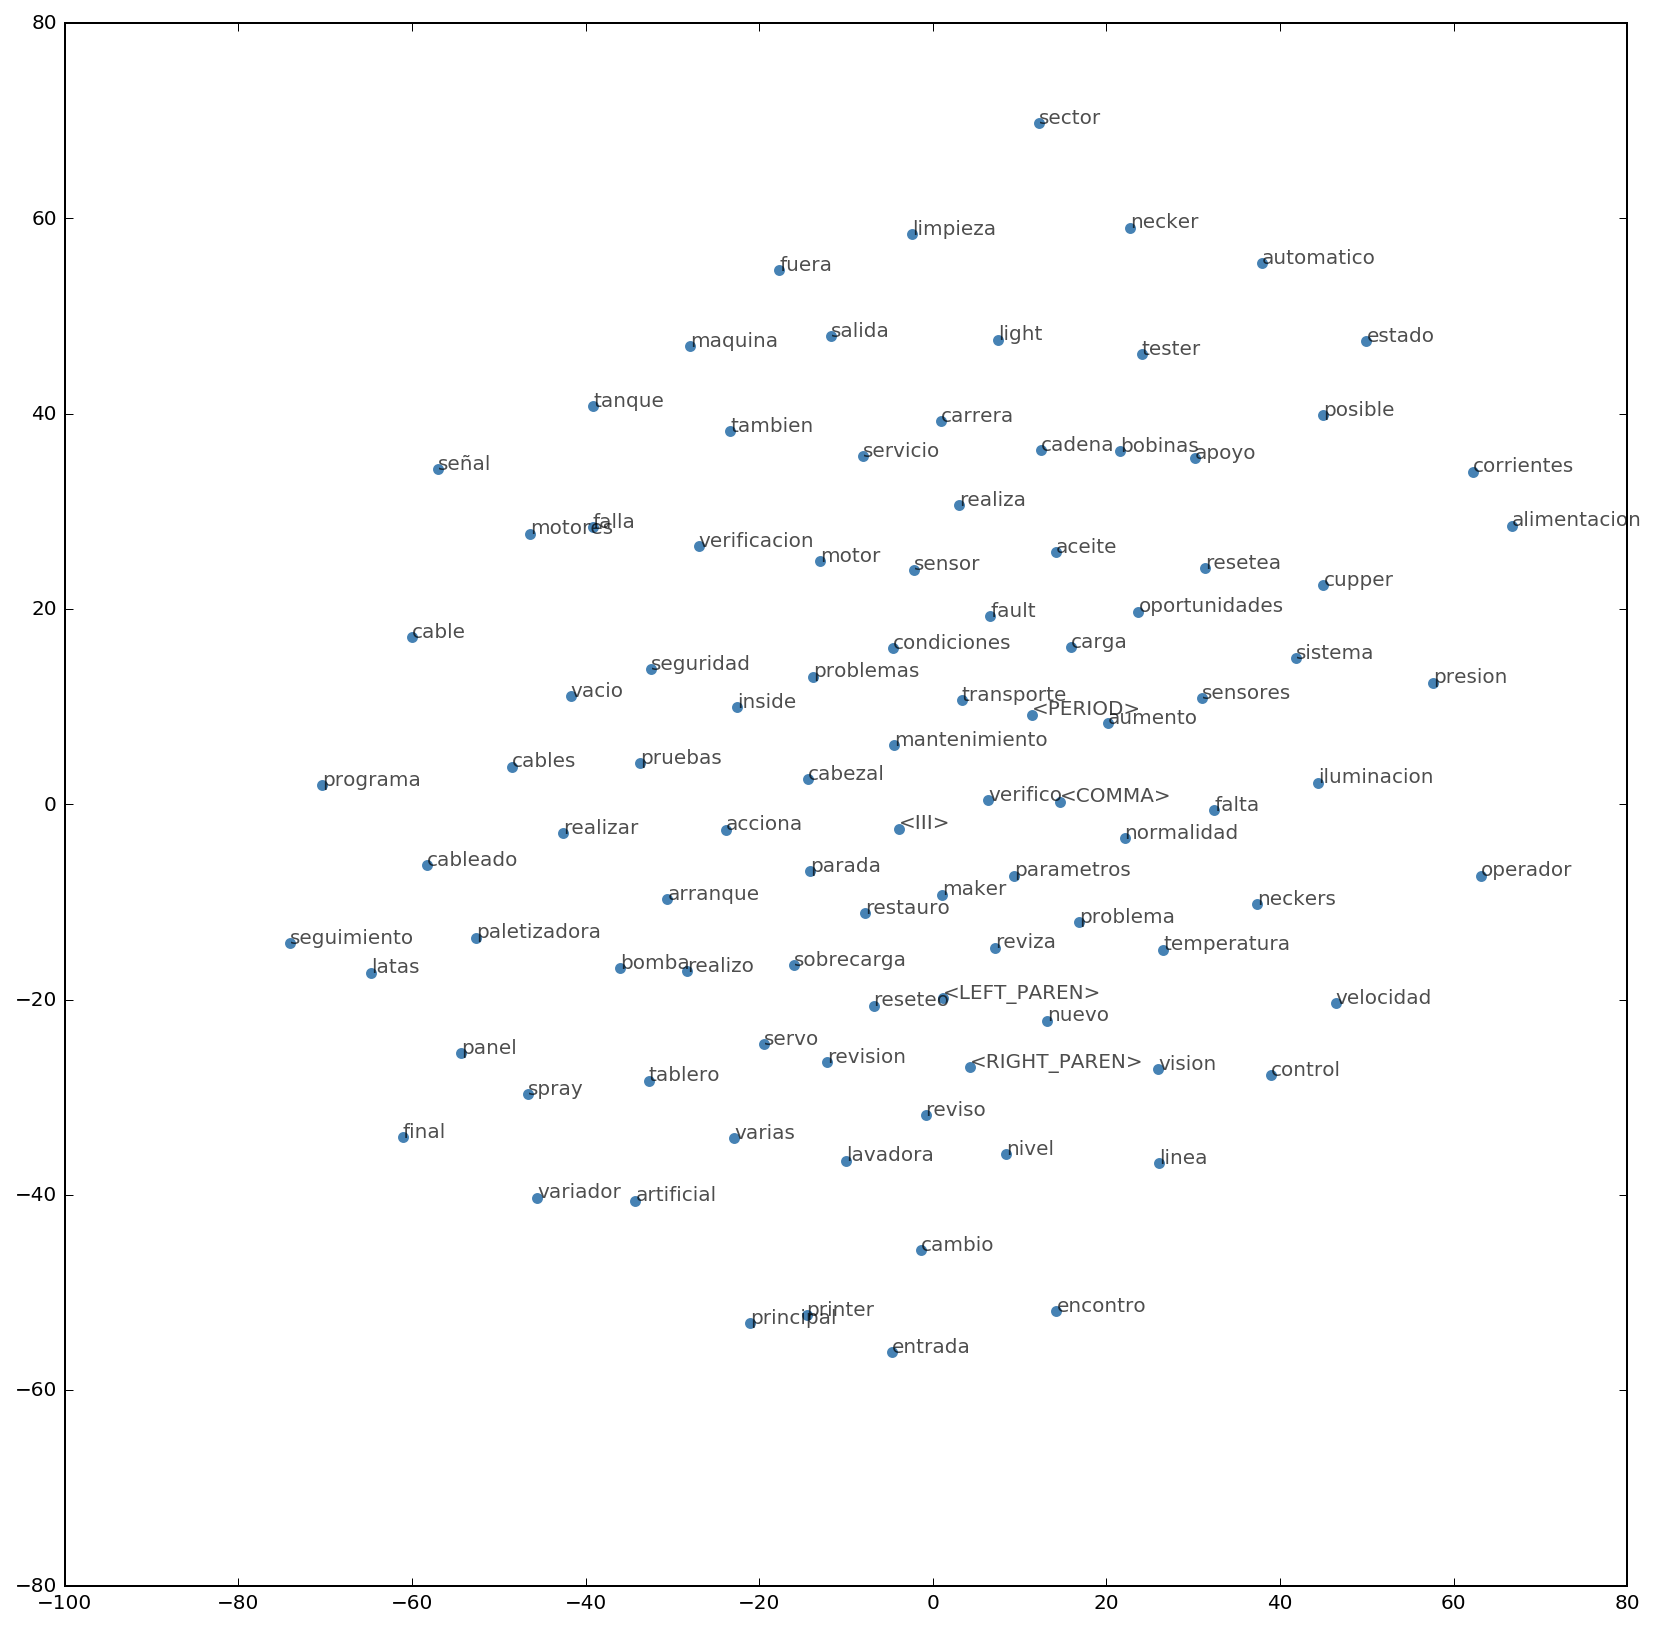

In [25]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

In [26]:
import os
with open(os.path.join('checkpoints', "metadata.tsv"), 'w') as f:
         for idx in range(len(int_to_vocab)):
            f.write(int_to_vocab[idx] + '\n')

In [27]:
from tensorflow.contrib.tensorboard.plugins import projector
summary_writer = tf.summary.FileWriter('checkpoints', sess.graph)
config = projector.ProjectorConfig()
embedding_conf = config.embeddings.add()
# embedding_conf.tensor_name = 'embedding:0'
embedding_conf.metadata_path = os.path.join('checkpoints', 'metadata.tsv')
projector.visualize_embeddings(summary_writer, config)